# Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import VotingClassifier
from sklearn import metrics

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
debug = True

In [3]:
# load expression data

f = open("./GSE123302_series_matrix.txt", "r")
#f = open("/content/drive/MyDrive/Laura Speggiorin - TCC/GSE123302_series_matrix.txt/GSE123302_series_matrix.txt", "r")

tmp = f.readlines()

f.close()

# select relevant parts (as strings)
header_str = tmp[69]
class_str = tmp[42]
matrix_str = tmp[70:-1]

In [4]:
# make list of instance ID's

header = header_str.replace("\"", "")
header = header.replace("\n", "")
header = header.replace("ID_REF\t", "")

header = header.split("\t")

#header
#['GSM3499537',
# 'GSM3499538',
# 'GSM3499539',
# ...
# 'GSM3499758',
# 'GSM3499759',
# 'GSM3499760']

In [5]:
# make list of diagnosis class ('ASD', 'Non-TD', 'TD')

classes = class_str.replace("\"", "")
classes = classes.replace("\n", "")
classes = classes.replace("!Sample_characteristics_ch1\t", "")
classes = classes.replace("diagnosis: ", "")

classes = classes.split("\t")

#classes
# ['ASD',
# 'ASD',
# 'ASD',
# ...
# 'Non-TD',
# 'Non-TD',
# 'Non-TD',
# ...
# 'TD',
# 'TD',
# 'TD']

In [6]:
("TD instances: " + str(len([y for y in classes if y=='TD'])),
"Non-TD instances: " + str(len([y for y in classes if y=='Non-TD'])),
"ASD instances: " + str(len([y for y in classes if y=='ASD'])))

('TD instances: 91', 'Non-TD instances: 80', 'ASD instances: 53')

In [7]:
# make dataframe out of expression matrix

matrix_str = [matrix_str[i].replace("\n", "") for i in range(len(matrix_str))]

header.insert(0,"ID")
df = []
string = ""
for i in range(len(matrix_str)):
    string = matrix_str[i]
    df.append(string.split("\t"))

df = pd.DataFrame(df)
df.columns = header
df.set_index('ID', inplace=True)

df.head()

GSM3499537 GSM3499538 GSM3499539 GSM3499540 GSM3499541 GSM3499542  \
ID                                                                           
16657436    6.59413    7.87068    8.24341    8.82145    7.28308    7.20000   
16657440    5.93156    5.69836    5.51954    5.28161    5.78602    5.48469   
16657445    3.15314    2.83453    3.95568    3.44626    3.32776    3.41798   
16657447    3.65784    2.08780    2.41832    2.53530    4.08640    2.70086   
16657450   11.64852   11.21240   11.29504   11.51345   11.52633   11.47545   

         GSM3499543 GSM3499544 GSM3499545 GSM3499546  ... GSM3499751  \
ID                                                    ...              
16657436    9.23493    7.20748    7.42416    7.64885  ...    7.89938   
16657440    5.81990    6.45421    5.99021    5.89918  ...    5.89504   
16657445    2.64097    2.97989    3.29357    3.04085  ...    3.37387   
16657447    2.23447    2.27813    2.21519    3.25745  ...    2.62774   
16657450   11.52348   11.55696   11.58122   11.55579  ...   10.73590   

         GSM3499752 GSM3499753 GSM3499754 GSM3499755 GSM3499756 GSM3499757  \
ID                                                                           
16657436    7.05351    6.51581    7.79333    8.15164    7.57387    7.53656   
16657440    5.49660    4.94837    5.33726    5.31676    5.20505    5.13099   
16657445    3.39238    2.42227    3.20146    2.70834    2.77802    2.93332   
16657447    2.77415    2.07024    2.66232    2.26471    2.23681    2.42367   
16657450   10.72824   10.30400   10.47405   10.01123   10.54521   10.68286   

         GSM3499758 GSM3499759 GSM3499760  
ID                                         
16657436    7.70415    7.49588    7.01858  
16657440    5.44787    5.49887    5.28380  
16657445    2.72043    2.45639    2.74394  
16657447    2.34175    2.62971    2.54580  
16657450   10.85129   10.71401   10.51731  

[5 rows x 224 columns]

In [8]:
df_t = df.transpose()

df_t = df_t.astype('float')

df_t.head()

ID          16657436  16657440  16657445  16657447  16657450  16657469  \
GSM3499537   6.59413   5.93156   3.15314   3.65784  11.64852   9.18746   
GSM3499538   7.87068   5.69836   2.83453   2.08780  11.21240   8.69769   
GSM3499539   8.24341   5.51954   3.95568   2.41832  11.29504   8.52116   
GSM3499540   8.82145   5.28161   3.44626   2.53530  11.51345   8.72665   
GSM3499541   7.28308   5.78602   3.32776   4.08640  11.52633   8.69042   

ID          16657473  16657476  16657489  16657492  ...  17118432  17118434  \
GSM3499537   4.59582   6.50885   5.50111   4.76784  ...   6.36994   5.18167   
GSM3499538   3.90464   6.17625   5.54039   4.40995  ...   6.38951   4.71130   
GSM3499539   3.85387   6.26045   4.82621   5.19215  ...   6.06655   4.88073   
GSM3499540   4.05922   5.95970   5.52619   4.58389  ...   6.42090   5.08474   
GSM3499541   4.29833   6.47306   4.79904   4.92781  ...   6.17093   5.61961   

ID          17118436  17118438  17118440  17118442  17118444  17118446  \
GSM3499537   6.14821   5.98637   3.89763   1.95365   3.45978   2.80000   
GSM3499538   5.74481   6.17986   4.39488   2.34992   3.46852   3.49701   
GSM3499539   5.45233   5.95467   4.39322   2.10524   3.83358   2.79608   
GSM3499540   5.62217   5.78808   4.22873   2.07298   3.14549   2.75074   
GSM3499541   5.27742   5.94552   3.71425   2.13377   3.38367   3.52271   

ID          17118451  17118478  
GSM3499537   3.44546   5.01391  
GSM3499538   3.32475   5.10275  
GSM3499539   3.43109   4.52188  
GSM3499540   3.65670   5.14589  
GSM3499541   3.40723   4.72626  

[5 rows x 36459 columns]

## Data Filtering

### Platform data loading

In [9]:
# load platform data

f = open("./GSE123302_family.soft", "r")
#f = open("/content/drive/MyDrive/Laura Speggiorin - TCC/GSE123302_family.soft", "r")

tmp = f.readlines()

f.close()

# select relevant parts (as strings)
platform_table_str = tmp[309:54291]

In [10]:
# make dataframe out of platform matrix
platform_table = []
line = ""
for i in range(len(platform_table_str)):
    line = platform_table_str[i]
    platform_table.append(line.split("\t"))

platform_table = pd.DataFrame(platform_table)

platform_table.columns = platform_table.iloc[0]
platform_table = platform_table[1:]

platform_table.head()

0        ID RANGE_STRAND RANGE_START RANGE_END total_probes     GB_ACC  \
1  16657436            +       12190     13639           25  NR_046018   
2  16657440            +       29554     31109           28              
3  16657445            +       69091     70008            8              
4  16657447            +      160446    161525           13              
5  16657450            +      317811    328581           36  NR_024368   

0             SPOT_ID      RANGE_GB\n  
1    chr1:12190-13639  NC_000001.10\n  
2    chr1:29554-31109  NC_000001.10\n  
3    chr1:69091-70008  NC_000001.10\n  
4  chr1:160446-161525  NC_000001.10\n  
5  chr1:317811-328581  NC_000001.10\n

In [11]:
platform_table.shape

(53981, 8)

### Dataframe feature filtering

In [12]:
#contagem de sondas com o prefixo NM_xxxxxx
platform_table['GB_ACC'].str.startswith('NM').value_counts()

GB_ACC
False    40731
True     13250
Name: count, dtype: int64

In [13]:
#selecionar IDs das sondas com prefixo 'NM' na coluna 'GB_ACC'

filtered_list = platform_table[platform_table['GB_ACC'].str.startswith('NM')]

filtered_list = list(filtered_list['ID'])

filtered_df = df_t.loc[:,[sonda for sonda in df_t.columns.tolist() if sonda in filtered_list]]
filtered_df.shape

(224, 12896)

In [14]:
top_t_genes = 5000 #@param {type:"integer"}

In [15]:
#filtrar por variancia (manter top 5000 atributos que mais variam)

variance = filtered_df.var()
filtered_varlist = variance.rank().sort_values(ascending=False)

filtered_varlist = list(filtered_varlist[0:top_t_genes].index)

filtered_df = filtered_df.loc[:,[sonda for sonda in df_t.columns.tolist() if sonda in filtered_varlist]]
filtered_df.shape

(224, 5000)

# Data pre-processing

Data pre-processing

In [16]:
#separar em desenvolvimento tipico e atipico
#0 == desenvolvimento typico, 1 == desenvolvimento atipico
def is_TD(class_list):
    isTD = np.array([0 if y=='TD' else 1 for y in class_list])
    
    if(debug):
        print("Number Non-Tipical Development: " + str(len(isTD[isTD == 1])))
        print("Number Tipical Development: " + str(len(isTD[isTD == 0])))

    return isTD

#separar em nao-ASD e ASD
#0 == não TEA, 1 == TEA
def is_ASD(class_list):
    isASD = np.array([1 if y=='ASD' else 0 for y in class_list])
    
    if(debug):
        print("Number ASD Development: " + str((len(isASD[isASD == 1]))))

    return isASD

#dentro de desenvolvimento não-típico 0 == não TEA, 1 == TEA
def NonTD_isASD(df):
    # dataframe de desenvolvimento não-típico
    NonTD_df = df[is_TD(df["Class"]) == 1]

    NonTD_isASD = np.array([1 if y=='ASD' else 0 for y in NonTD_df["Class"]])
    
    if(debug):
        print("Number other non-TD Development: " + str((len(NonTD_isASD[NonTD_isASD == 0]))))

    return NonTD_isASD


In [17]:
#holdout 80/20

X_train, X_test, y_train, y_test = train_test_split(filtered_df, classes, test_size=0.2, random_state=3, stratify=classes)

In [18]:
pd.Series(y_train).value_counts()

TD        73
Non-TD    64
ASD       42
Name: count, dtype: int64

In [19]:
print(pd.Series(y_test).value_counts())

TD        18
Non-TD    16
ASD       11
Name: count, dtype: int64


# Models 

**Fazer tuning de hiper parametros**

In [20]:
param_dict = {}
pipeline_dict = {}

In [21]:
#knn
pipeline_dict["KNN"] = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])

# KNN Rule of thumb: k should be the square root of the number of points
param_dict["KNN"] = {
    'classifier__n_neighbors': list(range(1, 15)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size': list(range(20, 40)),
    'classifier__p': [1, 2, 3],
    'classifier__metric': ['minkowski', 'chebyshev']
}


In [22]:
#nayve bayes
pipeline_dict["NB"] = Pipeline([('scaler', StandardScaler()), ('classifier', GaussianNB())])

param_dict["NB"] = {
    'classifier__var_smoothing': np.linspace(0,1,101)
}


In [23]:
#logistic regression

pipeline_dict["LR"] = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=5000))])

param_dict["LR"] =  {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 2, 20),
    'classifier__solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
}


In [24]:
#support vector machine

pipeline_dict["SVM"] = Pipeline([('scaler', StandardScaler()), ('classifier', svm.SVC(probability=True))])

C_range = np.logspace(-2, 2, 20)

param_dict["SVM"] = {
    'classifier__C': C_range,
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__coef0': range(1, 11),
    'classifier__shrinking': [True, False]
}


In [25]:
#multi layer perceptron (neural network)

pipeline_dict["MLP"] = Pipeline([('scaler', StandardScaler()), ('classifier', MLPClassifier(max_iter=1000, 
                                                                                            random_state=3))])

alpha_range = np.logspace(-5, -1, 15)

param_dict["MLP"] = {
    'classifier__hidden_layer_sizes': [(100,100,100), (50,100,50), (10,30,10) ],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
    'classifier__alpha': alpha_range,
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
}

In [26]:
#random forest
n_estimators_range = range(1,402,20)
n_estimators_range = [i-1 if i!= 1 else i for i in n_estimators_range]

max_depth_range = range(1,52,5)
max_depth_range = [i-1 if i!= 1 else i for i in max_depth_range]
max_depth_range.append(None)

pipeline_dict["RF-1"] = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
pipeline_dict["RF-2"] = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])

param_dict["RF-1"] = {
    'classifier__n_estimators': n_estimators_range,
    'classifier__max_depth': max_depth_range
}

param_dict["RF-2"] = {
    'classifier__min_samples_split': [5, 10, 15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10, 15, 20, 25 ,30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2']
}


In [27]:
# xgboost tree
pipeline_dict["XGB-1"] = Pipeline([('scaler', StandardScaler()), 
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-2"] = Pipeline([('scaler', StandardScaler()), 
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-3"] = Pipeline([('scaler', StandardScaler()), 
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])
pipeline_dict["XGB-4"] = Pipeline([('scaler', StandardScaler()), 
                                ('classifier', XGBClassifier(seed=3, scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
                                            ))])


param_dict["XGB-1"] = {
    'classifier__n_estimators': range(1,201, 5),
    'classifier__max_depth': range(0,16)
}

param_dict["XGB-2"] = {
    'classifier__min_child_weight':range(1,16),
    'classifier__gamma':np.linspace(0,1,101)
}

param_dict["XGB-3"] = {
    'classifier__subsample': np.linspace(0,1,25),
    'classifier__colsample_bytree': np.linspace(0,1,25)
}

param_dict["XGB-4"] = {
    'classifier__objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
    'classifier__learning_rate': np.linspace(0.005, 0.5, 100)
}


In [28]:
# light gbm

pipeline_dict["LGBM-1"] = Pipeline([('scaler', StandardScaler()), ('classifier', LGBMClassifier(random_state=3,
                                                                                               verbose=-1))])
pipeline_dict["LGBM-2"] = Pipeline([('scaler', StandardScaler()), ('classifier', LGBMClassifier(random_state=3,
                                                                                               verbose=-1))])

param_dict["LGBM-1"] =  {
    'classifier__boosting_type' : ['gbdt', 'dart', 'rf'],
    'classifier__feature_fraction':np.linspace(0.05, 1, 19, endpoint=False)
}

param_dict["LGBM-2"] =  {
    'classifier__learning_rate' : np.logspace(-4, 0, 15),
    'classifier__subsample' : np.linspace(0.05, 1, 20)
}

In [29]:
class GridSearch_Results:
    def __init__(self, gc):
        self.cv_results_ = gc.cv_results_
        self.best_estimator_ = gc.best_estimator_
        self.best_score_ = gc.best_score_
        self.best_params_ = gc.best_params_

In [30]:
def grid_search_cv_fit_and_print(X, y, estimator, param_grid, cv = 5, scoring = 'f1', printing_name = ""):
    grid_search = GridSearchCV(estimator,
                             param_grid,
                             cv=cv,
                             n_jobs=-1,
                             scoring=scoring,
                             return_train_score=True,
                             verbose = True)

    grid_search.fit(X, y)
    
    print(printing_name)
    print("   Best score: ", grid_search.best_score_)
    print("   Best params: ", grid_search.best_params_)

    return GridSearch_Results(grid_search)

In [31]:
#nro de folds
K = 5 #@param {type:"integer"}

In [32]:
#separar dataframe de treino em k folds para k fold cross validation
kfold = StratifiedKFold(n_splits=K, random_state=3, shuffle=True)

In [33]:
b = 1.5 #@param {type:"float"}

f2 = metrics.make_scorer(metrics.fbeta_score, beta=b)

### MODELO 1: TD ou NAO-TD

Descomentar celula (teclas 'ctrl'+'/' ou 'command'+'/') para rodar o hiperparameter tunning com GridSearchCV, comentado para facilitar execução de todas as celulas de uma vez

In [34]:
# gs_results_dict_m1={
#     'KNN':[], 
#     'NB':[], 
#     'LR':[], 
#     'SVM':[],
#     'MLP':[],
#     'RF-1':[], 
#     'RF-2':[],  
#     'XGB-1':[], 
#     'XGB-2':[], 
#     'XGB-3':[], 
#     'XGB-4':[],
#     'LGBM-1':[],
#     'LGBM-2':[]
# }

# pipeline_dict_m1 = copy.deepcopy(pipeline_dict)

# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     print("\nFOLD: " + str(i))

#     X_train_CV = X_train.iloc[train_index]
#     X_val_CV = X_train.iloc[test_index]

#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
#     y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])
    
#     ## GRID SEARCHES FOR BEST PARAMETERS

#     inner_kfold_cv = StratifiedKFold(n_splits=3, random_state=4, shuffle=True)
    
#     for j, (inner_train_index, inner_test_index) in enumerate(inner_kfold_cv.split(X_train_CV, pd.Series(y_train).iloc[train_index])):
#         print("INNER FOLD: " + str(j))
#         print(X_train_CV.iloc[inner_train_index].shape)
#         print(X_train_CV.iloc[inner_test_index].shape)
        
    
#     for key in pipeline_dict_m1.keys():
#         gs = grid_search_cv_fit_and_print(X = X_train_CV,
#                                           y = y_train_CV,
#                                           estimator = pipeline_dict_m1[key],
#                                           param_grid = param_dict[key],
#                                           scoring = f2,
#                                           cv = inner_kfold_cv.split(X_train_CV,
#                                                                     pd.Series(y_train).iloc[train_index]),
#                                           printing_name = key)
        
#         gs_results_dict_m1[key].append(gs)
        
#         if(key == "RF-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])
            
#         if(key == "XGB-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-2"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__min_child_weight=gs.best_params_['classifier__min_child_weight'],
#                 classifier__gamma=gs.best_params_['classifier__gamma'])

#         if(key == "XGB-3"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__subsample=gs.best_params_['classifier__subsample'],
#                 classifier__colsample_bytree=gs.best_params_['classifier__colsample_bytree'])
            
#         if(key == "LGBM-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m1[key].set_params(
#                 classifier__boosting_type=gs.best_params_['classifier__boosting_type'],
#                 classifier__feature_fraction=gs.best_params_['classifier__feature_fraction'])
    


FOLD: 0
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 84
Number Tipical Development: 59
Number Non-Tipical Development: 22
Number Tipical Development: 14
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.6435019841269841
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Fitting 3 folds for each of 101 candidates, totalling 303 fits
NB
   Best score:  0.5370660623800082
   Best params:  {'classifier__var_smoothing': 0.0}
Fitting 3 folds for each of 200 candidates, totalling 600 fits


/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8223041223041223
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8247884247884247
   Best params:  {'classifier__C': 0.4832930238571752, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.710583297821274
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.764454384268214
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 120}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8223041223041223
   Best params:  {'classifier__criterion': 'gini', 'classifi

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:25:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:24] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:28:44] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:16] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:31:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:31:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:31:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:31:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:31:30] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:32:36] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:30] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:15] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:35:00] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8223041223041223
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7162228199775709
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8223041223041223
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 1
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7297186461648709
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neigh

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8289705952382908
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8340316334797571
   Best params:  {'classifier__C': 0.11288378916846889, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7792269621044973
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8420563248377818
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 360}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8325583566760036
   Best params:  {'classifier__criterion': 'gini', 'classifie

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:32] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:14:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:14:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:14:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:14:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:14:48] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:16:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:16:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:16:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:16:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:16:19] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:17:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:17:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:17:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:17:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:17:32] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:35] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:29] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:13] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:56] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7847122563089132
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 2
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.6888070796474791
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neig

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.753885260535827
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8242199110769363
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 120}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8339892768464198
   Best params:  {'classifier__criterion': 'gini', 'classifier__max_features

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:58:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:58:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:58:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:58:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:58:25] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:48] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:02:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:02:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:02:20] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:03:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:03:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:03:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:03:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:03:35] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:38] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:05:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:05:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:05:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:05:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:05:30] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:18] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:06:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:07:03] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7281336322057692
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 3
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7085102317603771
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neigh

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8289705952382908
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7183318901113829
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8194468105538829
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 80}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8315473309954546
   Best params:  {'classifier__criterion': 'entropy', 'classifier__max_featur

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:44:14] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:34] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:06] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:49:22] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:50:24] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:15] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:51:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:04] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:52:47] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7527945757742348
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.15}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 4
(144, 5000)
(35, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 59
Number Non-Tipical Development: 21
Number Tipical Development: 14
INNER FOLD: 0
(96, 5000)
(48, 5000)
INNER FOLD: 1
(96, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(48, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7048987216145082
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neig

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR
   Best score:  0.8239564067378637
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8239564067378637
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7628677533635556
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (100, 100, 100), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8289250117064686
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 40}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8289705952382908
   Best params:  {'classifier__criterion': 'gini', 'classifier__max_featur

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:30:22] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:32:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:32:40] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:34:15] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:35:25] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:36:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:36:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:36:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:36:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:36:28] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:37:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:37:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:37:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:37:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:37:20] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:06] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:38:50] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8239564067378637
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7603625541125542
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8239564067378637
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}


Descomentar para salvar novos resultados, comentado para evitar sobrescrever arquivos em uso

In [35]:
# with open('Model1_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#     pickle.dump(gs_results_dict_m1, f,)

with open('Model1_GridSearchResults_kfoldcv.pkl', 'rb') as f:
    gs_results_dict_m1 = pickle.load(f)


In [36]:
def print_all_scores(score_series):
    #print("\n---------------------------------------------------\n")
    
    print("Confusion matrix:")
    disp = metrics.ConfusionMatrixDisplay(score_series["Confusion matrix"])
    disp.plot()
    plt.show()
    
    print("All metric scores:")
    
    [print(" - ", score_series.index[i], ": ", score_series.values[i]) for i in range(1, score_series.size)]
    
    

In [37]:
def all_scores(y_true, y_pred, to_print = False):
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    f2_score = metrics.fbeta_score(y_true, y_pred, beta = 2)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    
    all_score = pd.Series({
        "Confusion matrix": cm,
        "Accuracy": accuracy, 
        "Precision": precision,
        "Recall": recall,
        "F1 score": f1,
        "F2 score": f2_score,
        "ROC AUC": roc_auc
    })
    
    
    if(to_print):
        print_all_scores(all_score)
    
    return all_score

Celula de visalização extensa dos modelos, comparando os resultados dos pipelines resultantes do GridSearchCV com o setup original dos parametros de cada classificador, e comparando estes com a seleção dos melhores classificadores. Compara também estes resultados para Hard Voting e Soft Voting

(143, 5000)
(36, 5000)
Number Non-Tipical Development: 84
Number Tipical Development: 59
Number Non-Tipical Development: 22
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


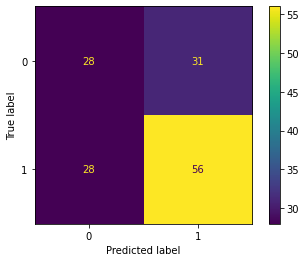

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6436781609195402
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6549707602339181
 -  F2 score :  0.6619385342789598
 -  ROC AUC :  0.5706214689265536

- KNN Test
Confusion matrix:


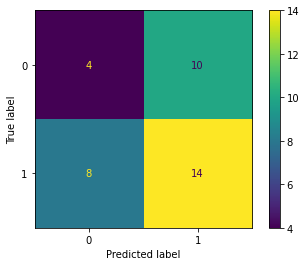

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5833333333333334
 -  Recall :  0.6363636363636364
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.625
 -  ROC AUC :  0.461038961038961

-------------------------
- NB Train
Confusion matrix:


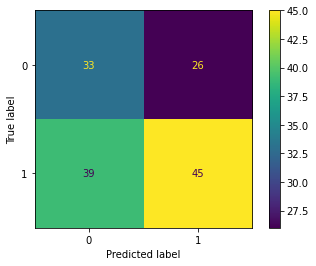

All metric scores:
 -  Accuracy :  0.5454545454545454
 -  Precision :  0.6338028169014085
 -  Recall :  0.5357142857142857
 -  F1 score :  0.5806451612903227
 -  F2 score :  0.5528255528255529
 -  ROC AUC :  0.5475181598062954

- NB Test
Confusion matrix:


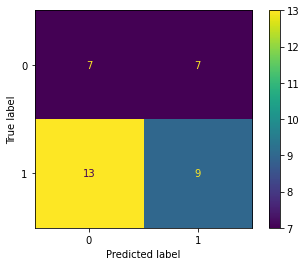

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5625
 -  Recall :  0.4090909090909091
 -  F1 score :  0.47368421052631576
 -  F2 score :  0.4326923076923077
 -  ROC AUC :  0.4545454545454546

-------------------------
- LR Train
Confusion matrix:


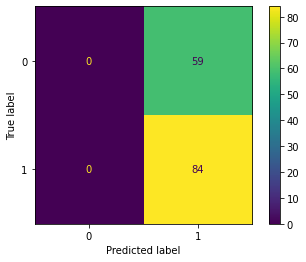

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


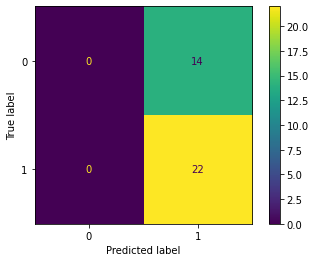

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


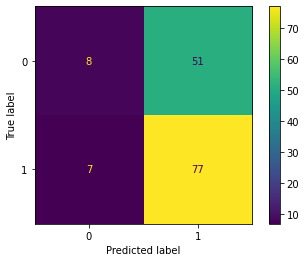

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.6015625
 -  Recall :  0.9166666666666666
 -  F1 score :  0.7264150943396227
 -  F2 score :  0.8297413793103448
 -  ROC AUC :  0.5261299435028248

- SVM Test
Confusion matrix:


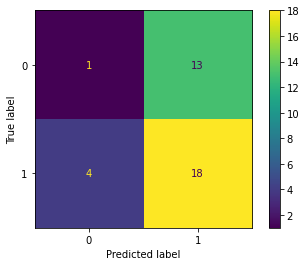

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5806451612903226
 -  Recall :  0.8181818181818182
 -  F1 score :  0.679245283018868
 -  F2 score :  0.7563025210084033
 -  ROC AUC :  0.4448051948051948

-------------------------
- MLP Train
Confusion matrix:


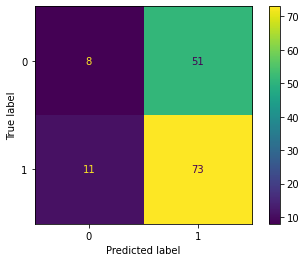

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.5887096774193549
 -  Recall :  0.8690476190476191
 -  F1 score :  0.701923076923077
 -  F2 score :  0.7934782608695653
 -  ROC AUC :  0.502320419693301

- MLP Test
Confusion matrix:


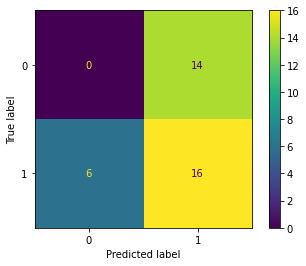

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5333333333333333
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6153846153846153
 -  F2 score :  0.6779661016949153
 -  ROC AUC :  0.36363636363636365

-------------------------
- RF-2 Train
Confusion matrix:


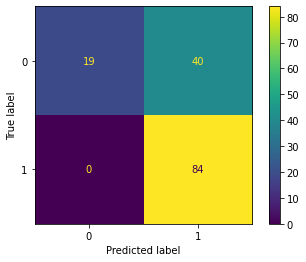

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.6774193548387096
 -  Recall :  1.0
 -  F1 score :  0.8076923076923077
 -  F2 score :  0.9130434782608695
 -  ROC AUC :  0.6610169491525424

- RF-2 Test
Confusion matrix:


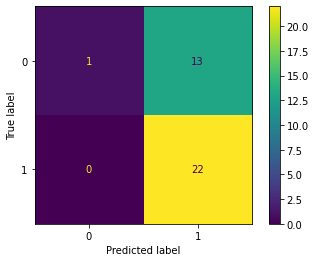

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6285714285714286
 -  Recall :  1.0
 -  F1 score :  0.7719298245614035
 -  F2 score :  0.8943089430894309
 -  ROC AUC :  0.5357142857142857

-------------------------
- XGB-4 Train
Confusion matrix:


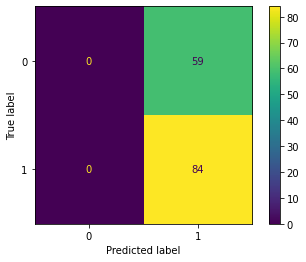

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


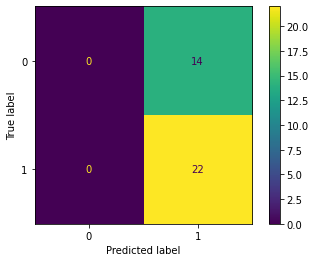

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


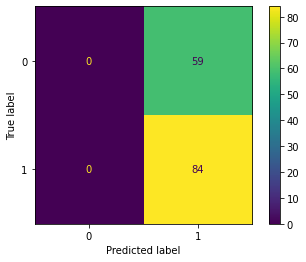

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


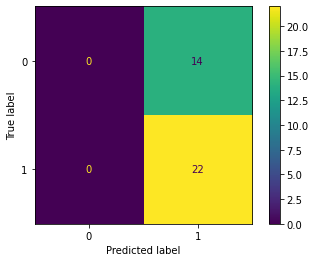

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


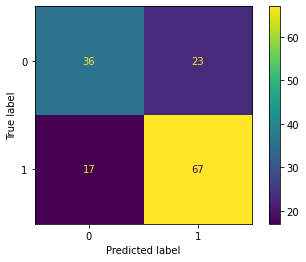

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.7444444444444445
 -  Recall :  0.7976190476190477
 -  F1 score :  0.7701149425287357
 -  F2 score :  0.7863849765258217
 -  ROC AUC :  0.7038942695722357

- KNN(original) Test
Confusion matrix:


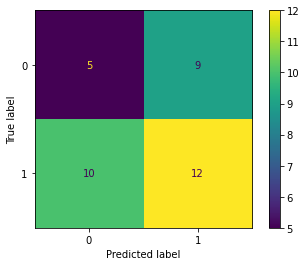

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5714285714285714
 -  Recall :  0.5454545454545454
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5504587155963302
 -  ROC AUC :  0.45129870129870125

-------------------------
- NB(original) Train
Confusion matrix:


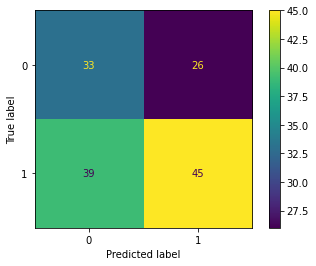

All metric scores:
 -  Accuracy :  0.5454545454545454
 -  Precision :  0.6338028169014085
 -  Recall :  0.5357142857142857
 -  F1 score :  0.5806451612903227
 -  F2 score :  0.5528255528255529
 -  ROC AUC :  0.5475181598062954

- NB(original) Test
Confusion matrix:


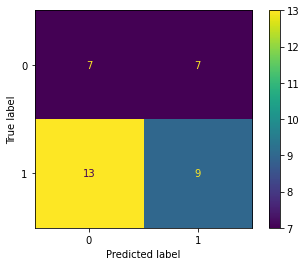

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5625
 -  Recall :  0.4090909090909091
 -  F1 score :  0.47368421052631576
 -  F2 score :  0.4326923076923077
 -  ROC AUC :  0.4545454545454546

-------------------------
- LR(original) Train
Confusion matrix:


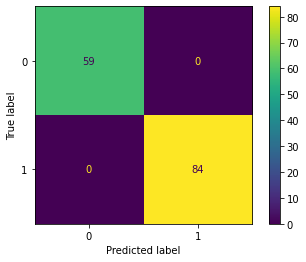

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


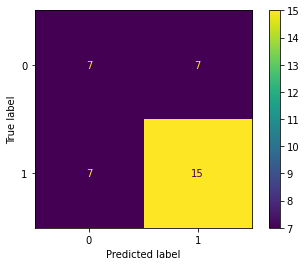

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6818181818181818
 -  Recall :  0.6818181818181818
 -  F1 score :  0.6818181818181818
 -  F2 score :  0.6818181818181818
 -  ROC AUC :  0.5909090909090908

-------------------------
- SVM(original) Train
Confusion matrix:


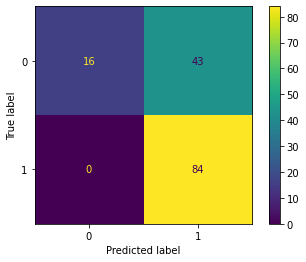

All metric scores:
 -  Accuracy :  0.6993006993006993
 -  Precision :  0.6614173228346457
 -  Recall :  1.0
 -  F1 score :  0.7962085308056872
 -  F2 score :  0.9071274298056156
 -  ROC AUC :  0.6355932203389831

- SVM(original) Test
Confusion matrix:


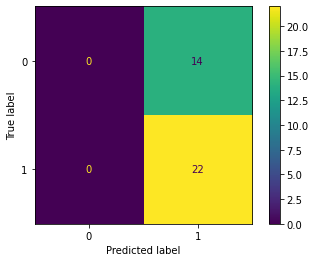

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


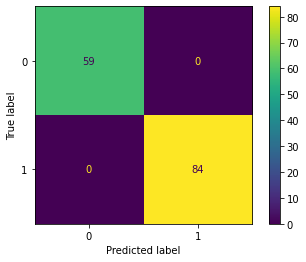

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


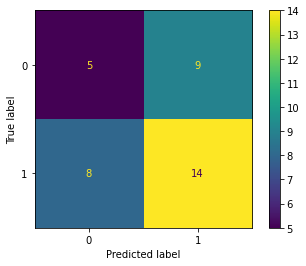

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.6086956521739131
 -  Recall :  0.6363636363636364
 -  F1 score :  0.6222222222222223
 -  F2 score :  0.6306306306306306
 -  ROC AUC :  0.4967532467532467

-------------------------
- RF(original) Train
Confusion matrix:


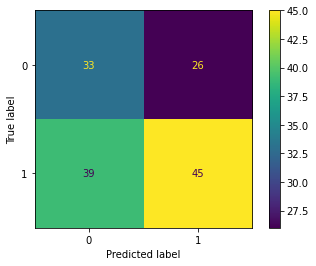

All metric scores:
 -  Accuracy :  0.5454545454545454
 -  Precision :  0.6338028169014085
 -  Recall :  0.5357142857142857
 -  F1 score :  0.5806451612903227
 -  F2 score :  0.5528255528255529
 -  ROC AUC :  0.5475181598062954

- RF(original) Test
Confusion matrix:


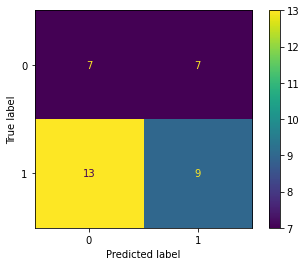

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5625
 -  Recall :  0.4090909090909091
 -  F1 score :  0.47368421052631576
 -  F2 score :  0.4326923076923077
 -  ROC AUC :  0.4545454545454546

-------------------------
- XGB(original) Train
Confusion matrix:


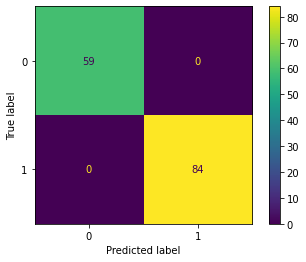

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


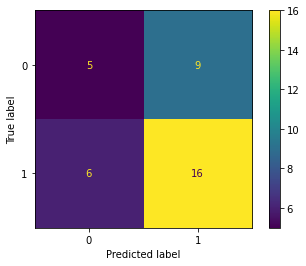

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.64
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6808510638297872
 -  F2 score :  0.7079646017699116
 -  ROC AUC :  0.5422077922077921
[LightGBM] [Info] Number of positive: 84, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246587
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587413 -> initscore=0.353279
[LightGBM] [Info] Start training from score 0.353279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

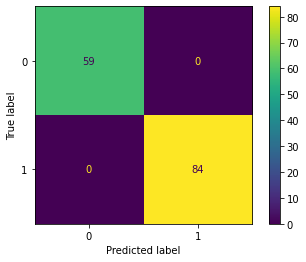

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


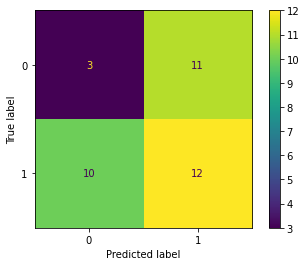

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5217391304347826
 -  Recall :  0.5454545454545454
 -  F1 score :  0.5333333333333332
 -  F2 score :  0.5405405405405406
 -  ROC AUC :  0.37987012987012986
KNN
NB(original)
LR
SVM(original)
MLP
RF-2
XGB-4
LGBM-2

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:10:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


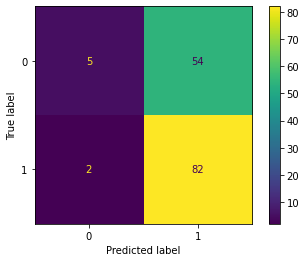

All metric scores:
 -  Accuracy :  0.6083916083916084
 -  Precision :  0.6029411764705882
 -  Recall :  0.9761904761904762
 -  F1 score :  0.7454545454545454
 -  F2 score :  0.8686440677966101
 -  ROC AUC :  0.5304681194511703
Validation Set: 
Confusion matrix:


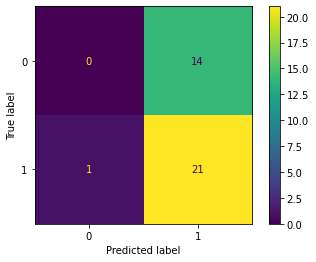

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6
 -  Recall :  0.9545454545454546
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.853658536585366
 -  ROC AUC :  0.4772727272727273
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:11:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


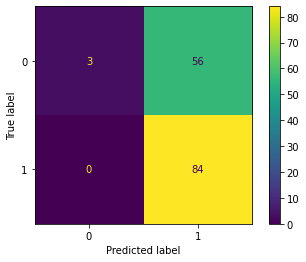

All metric scores:
 -  Accuracy :  0.6083916083916084
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5254237288135593
Validation Set: 
Confusion matrix:


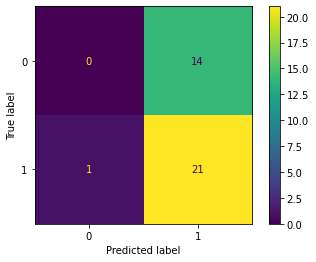

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6
 -  Recall :  0.9545454545454546
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.853658536585366
 -  ROC AUC :  0.4772727272727273

 -- Untuned estimators -- 
- Hard Voting: 
Training Set: 
Confusion matrix:


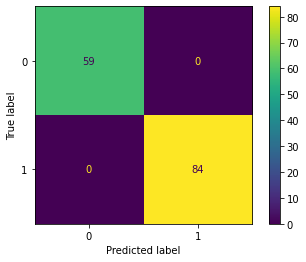

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


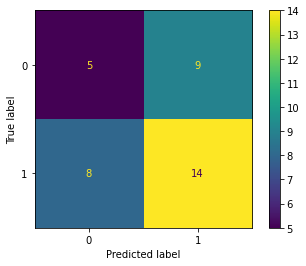

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.6086956521739131
 -  Recall :  0.6363636363636364
 -  F1 score :  0.6222222222222223
 -  F2 score :  0.6306306306306306
 -  ROC AUC :  0.4967532467532467
- Soft Voting: 
Training Set: 
Confusion matrix:


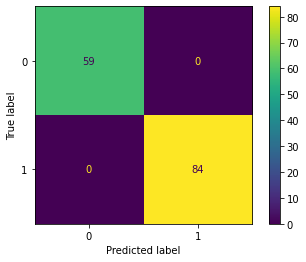

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


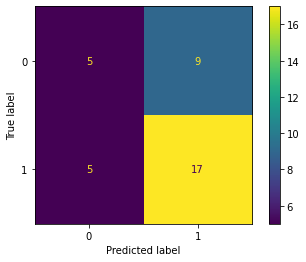

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6538461538461539
 -  Recall :  0.7727272727272727
 -  F1 score :  0.7083333333333333
 -  F2 score :  0.7456140350877193
 -  ROC AUC :  0.564935064935065

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:11:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


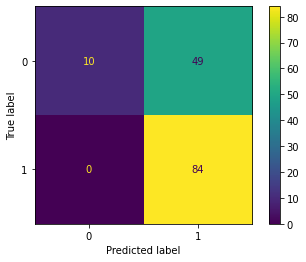

All metric scores:
 -  Accuracy :  0.6573426573426573
 -  Precision :  0.631578947368421
 -  Recall :  1.0
 -  F1 score :  0.7741935483870968
 -  F2 score :  0.8955223880597015
 -  ROC AUC :  0.5847457627118644
Validation Set: 
Confusion matrix:


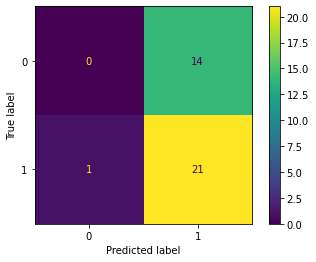

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6
 -  Recall :  0.9545454545454546
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.853658536585366
 -  ROC AUC :  0.4772727272727273
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:12:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


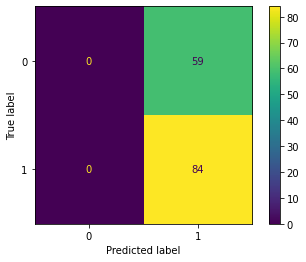

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


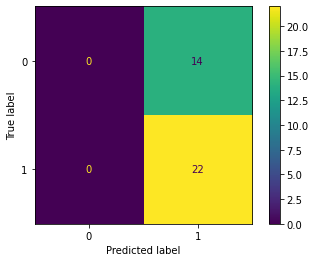

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5
Best voting:  MIX_SoftVoting
Scores:  Confusion matrix    [[0, 14], [0, 22]]
Accuracy                      0.611111
Precision                     0.611111
Recall                             1.0
F1 score                      0.758621
F2 score                      0.887097
ROC AUC                            0.5
dtype: object

---------------------------------------------------
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


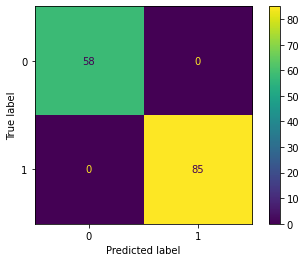

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


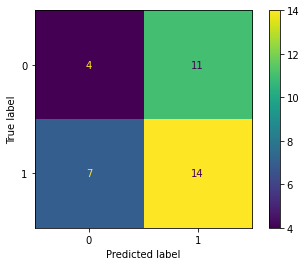

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.56
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.6422018348623854
 -  ROC AUC :  0.4666666666666667

-------------------------
- NB Train
Confusion matrix:


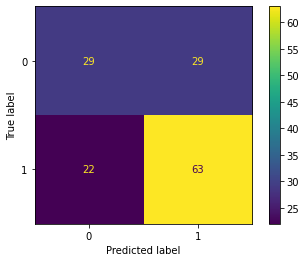

All metric scores:
 -  Accuracy :  0.6433566433566433
 -  Precision :  0.6847826086956522
 -  Recall :  0.7411764705882353
 -  F1 score :  0.7118644067796609
 -  F2 score :  0.7291666666666667
 -  ROC AUC :  0.6205882352941177

- NB Test
Confusion matrix:


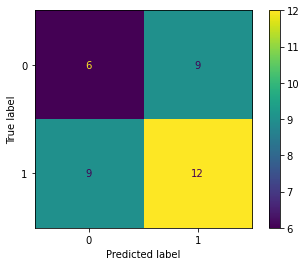

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- LR Train
Confusion matrix:


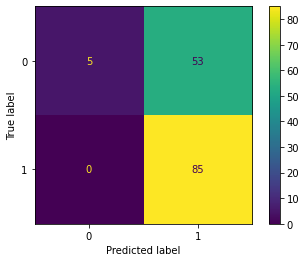

All metric scores:
 -  Accuracy :  0.6293706293706294
 -  Precision :  0.6159420289855072
 -  Recall :  1.0
 -  F1 score :  0.7623318385650223
 -  F2 score :  0.8891213389121339
 -  ROC AUC :  0.5431034482758621

- LR Test
Confusion matrix:


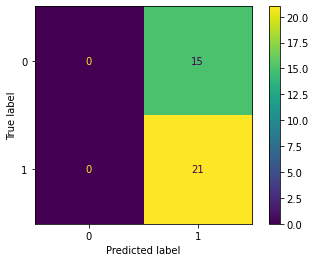

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


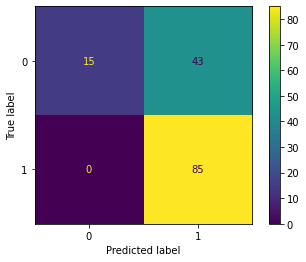

All metric scores:
 -  Accuracy :  0.6993006993006993
 -  Precision :  0.6640625
 -  Recall :  1.0
 -  F1 score :  0.7981220657276995
 -  F2 score :  0.9081196581196581
 -  ROC AUC :  0.6293103448275862

- SVM Test
Confusion matrix:


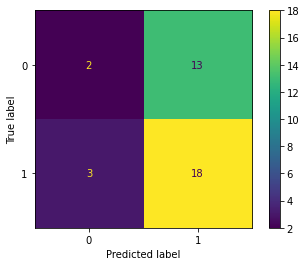

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- MLP Train
Confusion matrix:


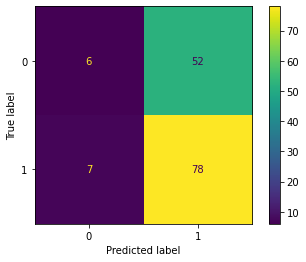

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7255813953488371
 -  F2 score :  0.8297872340425533
 -  ROC AUC :  0.5105476673427991

- MLP Test
Confusion matrix:


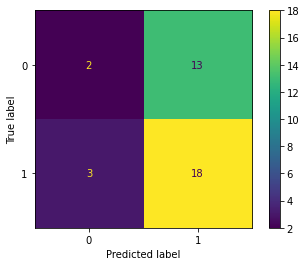

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- RF-2 Train
Confusion matrix:


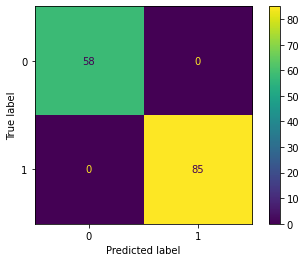

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- RF-2 Test
Confusion matrix:


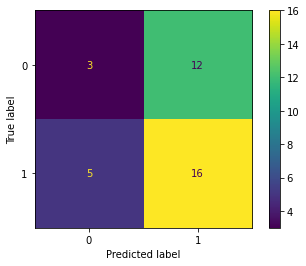

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5714285714285714
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6530612244897959
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.4809523809523809

-------------------------
- XGB-4 Train
Confusion matrix:


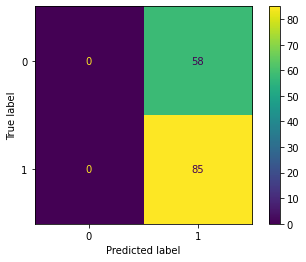

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


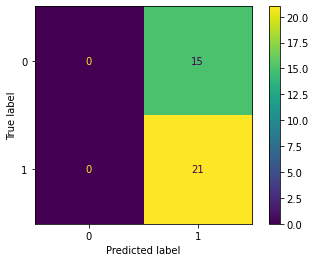

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


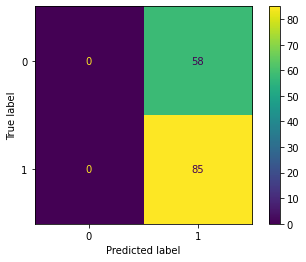

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


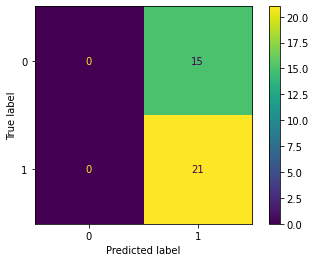

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


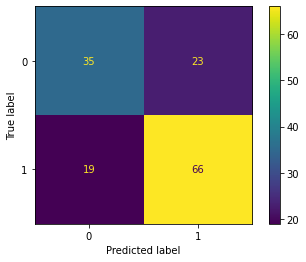

All metric scores:
 -  Accuracy :  0.7062937062937062
 -  Precision :  0.7415730337078652
 -  Recall :  0.7764705882352941
 -  F1 score :  0.7586206896551726
 -  F2 score :  0.7692307692307693
 -  ROC AUC :  0.6899594320486816

- KNN(original) Test
Confusion matrix:


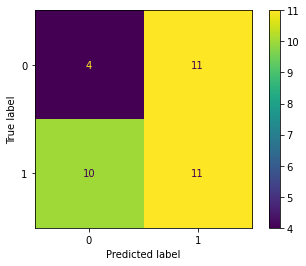

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5116279069767442
 -  F2 score :  0.5188679245283019
 -  ROC AUC :  0.3952380952380953

-------------------------
- NB(original) Train
Confusion matrix:


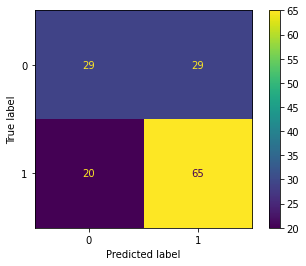

All metric scores:
 -  Accuracy :  0.6573426573426573
 -  Precision :  0.6914893617021277
 -  Recall :  0.7647058823529411
 -  F1 score :  0.7262569832402235
 -  F2 score :  0.748847926267281
 -  ROC AUC :  0.6323529411764706

- NB(original) Test
Confusion matrix:


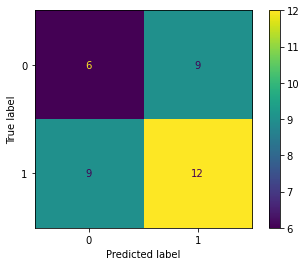

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- LR(original) Train
Confusion matrix:


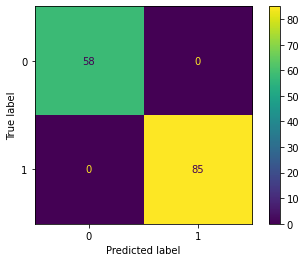

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


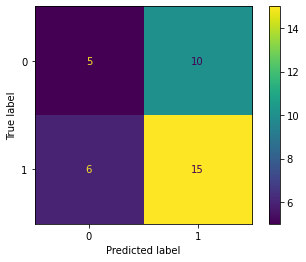

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6521739130434783
 -  F2 score :  0.6880733944954128
 -  ROC AUC :  0.5238095238095238

-------------------------
- SVM(original) Train
Confusion matrix:


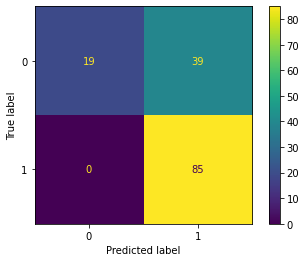

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.6854838709677419
 -  Recall :  1.0
 -  F1 score :  0.8133971291866028
 -  F2 score :  0.915948275862069
 -  ROC AUC :  0.6637931034482758

- SVM(original) Test
Confusion matrix:


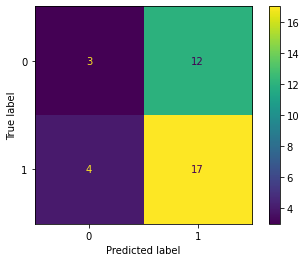

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5862068965517241
 -  Recall :  0.8095238095238095
 -  F1 score :  0.68
 -  F2 score :  0.752212389380531
 -  ROC AUC :  0.5047619047619047

-------------------------
- MLP(original) Train
Confusion matrix:


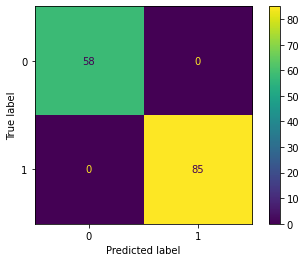

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


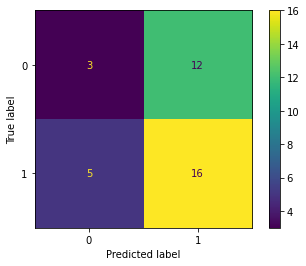

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5714285714285714
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6530612244897959
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.4809523809523809

-------------------------
- RF(original) Train
Confusion matrix:


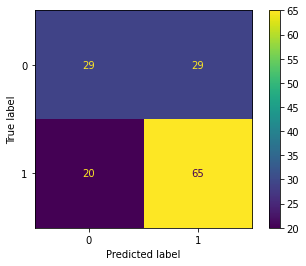

All metric scores:
 -  Accuracy :  0.6573426573426573
 -  Precision :  0.6914893617021277
 -  Recall :  0.7647058823529411
 -  F1 score :  0.7262569832402235
 -  F2 score :  0.748847926267281
 -  ROC AUC :  0.6323529411764706

- RF(original) Test
Confusion matrix:


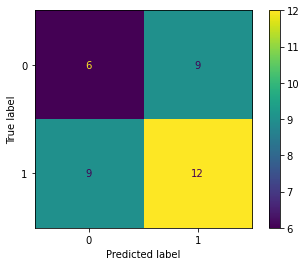

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- XGB(original) Train
Confusion matrix:


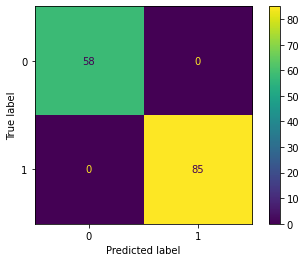

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


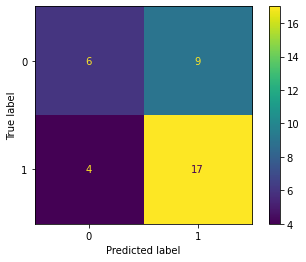

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6538461538461539
 -  Recall :  0.8095238095238095
 -  F1 score :  0.7234042553191489
 -  F2 score :  0.7727272727272726
 -  ROC AUC :  0.6047619047619048
[LightGBM] [Info] Number of positive: 85, number of negative: 58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246632
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

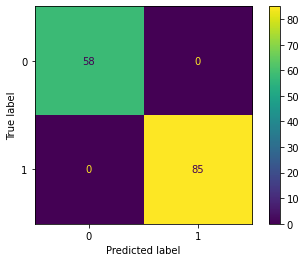

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


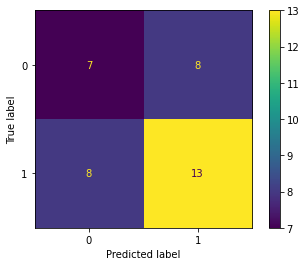

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6190476190476191
 -  Recall :  0.6190476190476191
 -  F1 score :  0.6190476190476191
 -  F2 score :  0.6190476190476191
 -  ROC AUC :  0.5428571428571428
KNN
NB(original)
LR
SVM
MLP
RF-2
XGB-4
LGBM-2

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:12:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


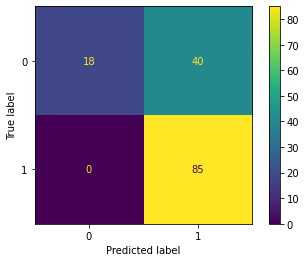

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.68
 -  Recall :  1.0
 -  F1 score :  0.8095238095238095
 -  F2 score :  0.913978494623656
 -  ROC AUC :  0.6551724137931034
Validation Set: 
Confusion matrix:


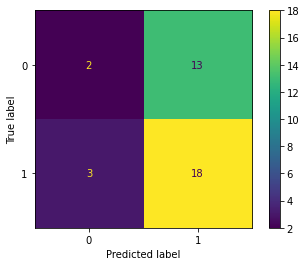

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:13:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


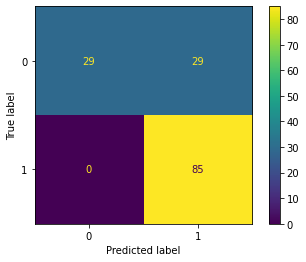

All metric scores:
 -  Accuracy :  0.7972027972027972
 -  Precision :  0.7456140350877193
 -  Recall :  1.0
 -  F1 score :  0.8542713567839196
 -  F2 score :  0.9361233480176211
 -  ROC AUC :  0.75
Validation Set: 
Confusion matrix:


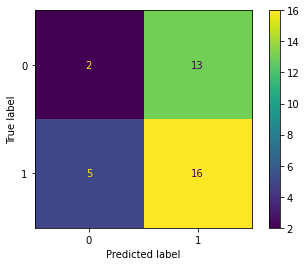

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5517241379310345
 -  Recall :  0.7619047619047619
 -  F1 score :  0.64
 -  F2 score :  0.7079646017699116
 -  ROC AUC :  0.4476190476190476

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of positive: 84, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246587
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587413 -> initscore=0.353279
[LightGBM] [Info] Start training from score 0.353279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

Training Set: 
Confusion matrix:


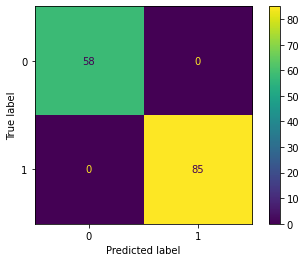

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


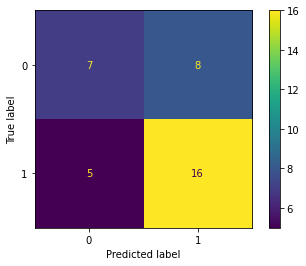

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6666666666666666
 -  Recall :  0.7619047619047619
 -  F1 score :  0.7111111111111111
 -  F2 score :  0.7407407407407406
 -  ROC AUC :  0.6142857142857142
- Soft Voting: 
[LightGBM] [Info] Number of positive: 84, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246587
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587413 -> initscore=0.353279
[LightGBM] [Info] Start training from score 0.353279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Training Set: 
Confusion matrix:


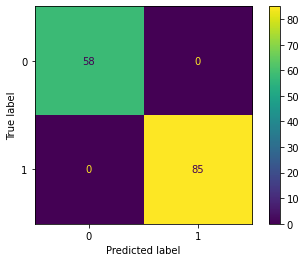

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


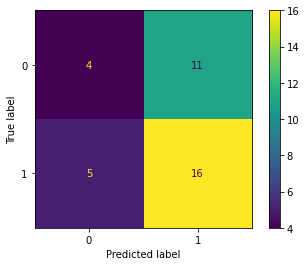

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5925925925925926
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6666666666666666
 -  F2 score :  0.7207207207207207
 -  ROC AUC :  0.5142857142857142

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:13:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


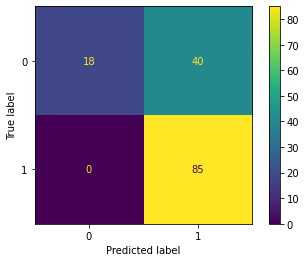

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.68
 -  Recall :  1.0
 -  F1 score :  0.8095238095238095
 -  F2 score :  0.913978494623656
 -  ROC AUC :  0.6551724137931034
Validation Set: 
Confusion matrix:


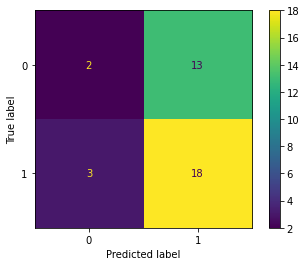

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:14:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


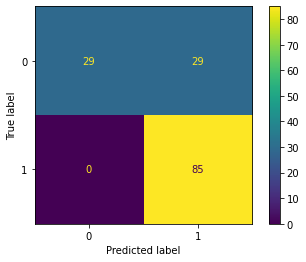

All metric scores:
 -  Accuracy :  0.7972027972027972
 -  Precision :  0.7456140350877193
 -  Recall :  1.0
 -  F1 score :  0.8542713567839196
 -  F2 score :  0.9361233480176211
 -  ROC AUC :  0.75
Validation Set: 
Confusion matrix:


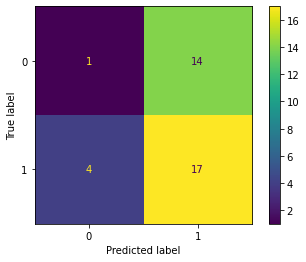

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5483870967741935
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6538461538461537
 -  F2 score :  0.7391304347826086
 -  ROC AUC :  0.4380952380952381
Best voting:  GS_HardVoting
Scores:  Confusion matrix    [[2, 13], [3, 18]]
Accuracy                      0.555556
Precision                     0.580645
Recall                        0.857143
F1 score                      0.692308
F2 score                      0.782609
ROC AUC                       0.495238
dtype: object

---------------------------------------------------
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


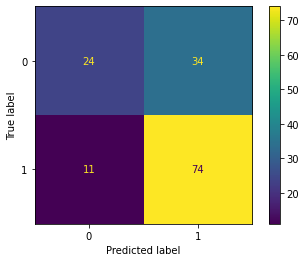

All metric scores:
 -  Accuracy :  0.6853146853146853
 -  Precision :  0.6851851851851852
 -  Recall :  0.8705882352941177
 -  F1 score :  0.766839378238342
 -  F2 score :  0.8258928571428572
 -  ROC AUC :  0.6421906693711967

- KNN Test
Confusion matrix:


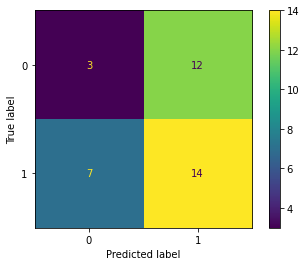

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5384615384615384
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5957446808510638
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.43333333333333324

-------------------------
- NB Train
Confusion matrix:


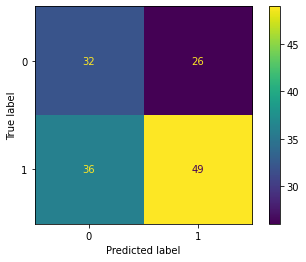

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.6533333333333333
 -  Recall :  0.5764705882352941
 -  F1 score :  0.6124999999999999
 -  F2 score :  0.5903614457831325
 -  ROC AUC :  0.5640973630831643

- NB Test
Confusion matrix:


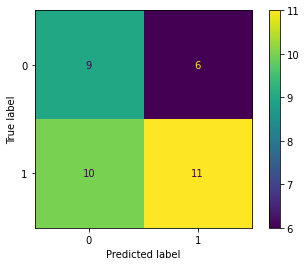

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5619047619047619

-------------------------
- LR Train
Confusion matrix:


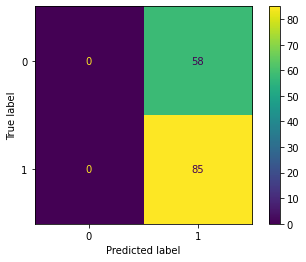

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


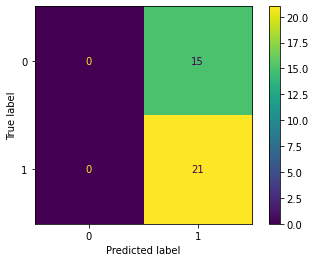

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


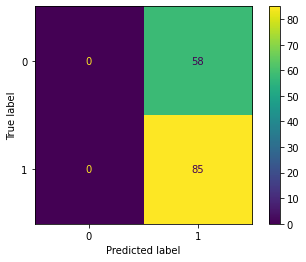

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


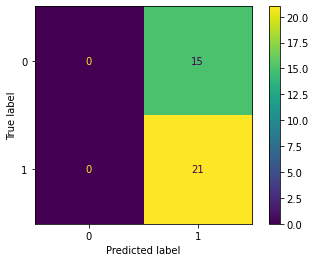

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


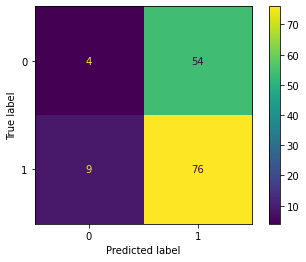

All metric scores:
 -  Accuracy :  0.5594405594405595
 -  Precision :  0.5846153846153846
 -  Recall :  0.8941176470588236
 -  F1 score :  0.7069767441860465
 -  F2 score :  0.8085106382978725
 -  ROC AUC :  0.48154158215010145

- MLP Test
Confusion matrix:


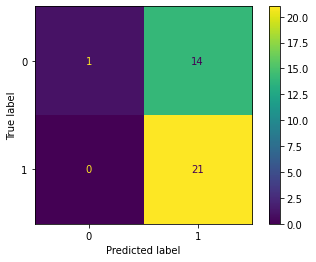

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------
- RF-2 Train
Confusion matrix:


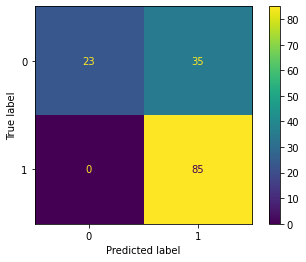

All metric scores:
 -  Accuracy :  0.7552447552447552
 -  Precision :  0.7083333333333334
 -  Recall :  1.0
 -  F1 score :  0.8292682926829268
 -  F2 score :  0.9239130434782609
 -  ROC AUC :  0.6982758620689655

- RF-2 Test
Confusion matrix:


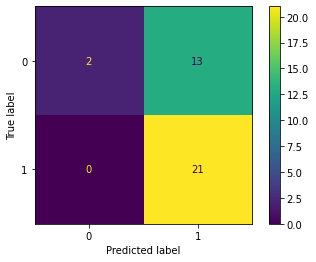

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6176470588235294
 -  Recall :  1.0
 -  F1 score :  0.7636363636363637
 -  F2 score :  0.8898305084745762
 -  ROC AUC :  0.5666666666666667

-------------------------
- XGB-4 Train
Confusion matrix:


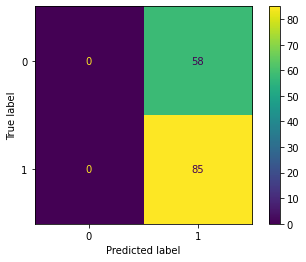

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


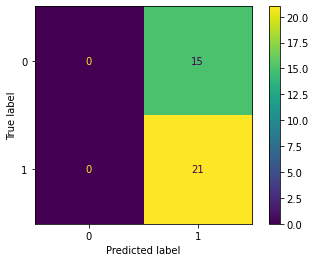

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


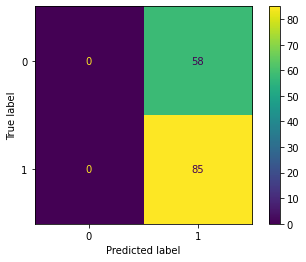

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


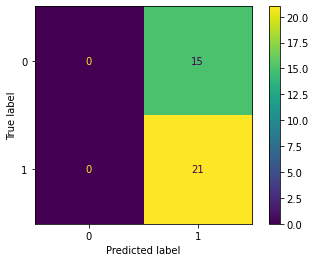

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


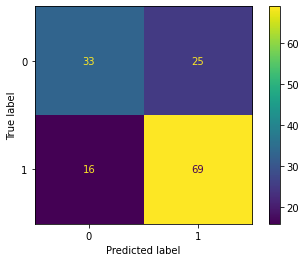

All metric scores:
 -  Accuracy :  0.7132867132867133
 -  Precision :  0.7340425531914894
 -  Recall :  0.8117647058823529
 -  F1 score :  0.7709497206703911
 -  F2 score :  0.7949308755760369
 -  ROC AUC :  0.6903651115618661

- KNN(original) Test
Confusion matrix:


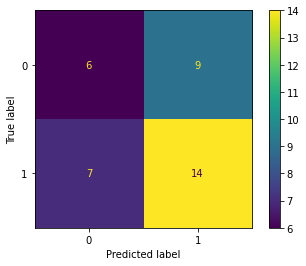

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6086956521739131
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6363636363636365
 -  F2 score :  0.6542056074766356
 -  ROC AUC :  0.5333333333333333

-------------------------
- NB(original) Train
Confusion matrix:


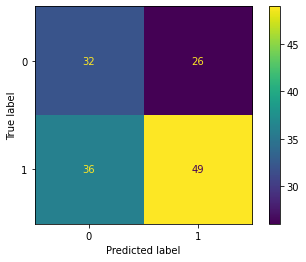

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.6533333333333333
 -  Recall :  0.5764705882352941
 -  F1 score :  0.6124999999999999
 -  F2 score :  0.5903614457831325
 -  ROC AUC :  0.5640973630831643

- NB(original) Test
Confusion matrix:


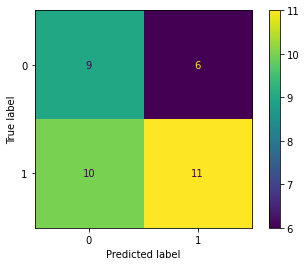

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5619047619047619

-------------------------
- LR(original) Train
Confusion matrix:


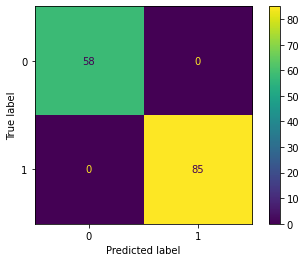

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


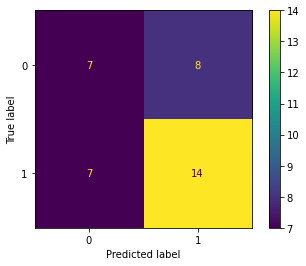

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6363636363636364
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6511627906976744
 -  F2 score :  0.660377358490566
 -  ROC AUC :  0.5666666666666667

-------------------------
- SVM(original) Train
Confusion matrix:


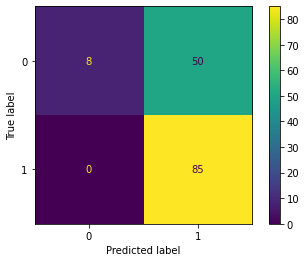

All metric scores:
 -  Accuracy :  0.6503496503496503
 -  Precision :  0.6296296296296297
 -  Recall :  1.0
 -  F1 score :  0.7727272727272727
 -  F2 score :  0.8947368421052632
 -  ROC AUC :  0.5689655172413793

- SVM(original) Test
Confusion matrix:


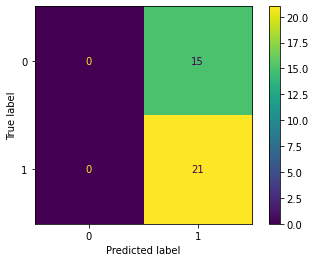

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


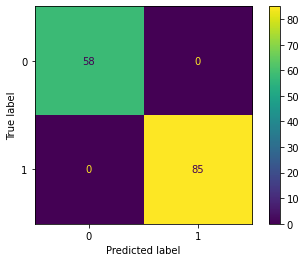

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


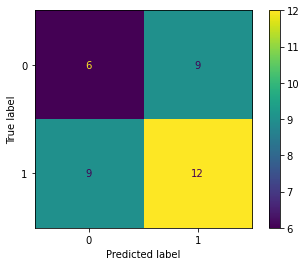

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- RF(original) Train
Confusion matrix:


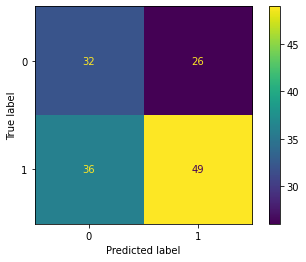

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.6533333333333333
 -  Recall :  0.5764705882352941
 -  F1 score :  0.6124999999999999
 -  F2 score :  0.5903614457831325
 -  ROC AUC :  0.5640973630831643

- RF(original) Test
Confusion matrix:


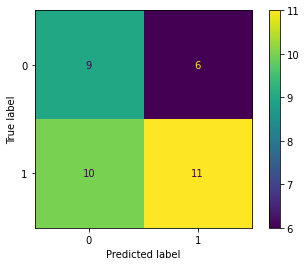

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5619047619047619

-------------------------
- XGB(original) Train
Confusion matrix:


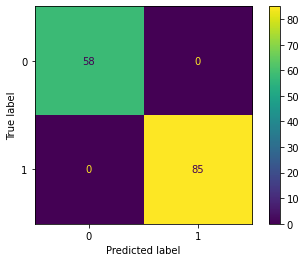

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


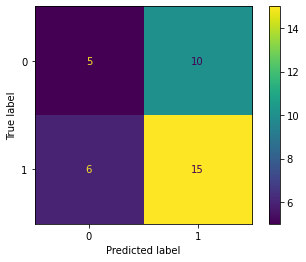

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6521739130434783
 -  F2 score :  0.6880733944954128
 -  ROC AUC :  0.5238095238095238
[LightGBM] [Info] Number of positive: 85, number of negative: 58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246571
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


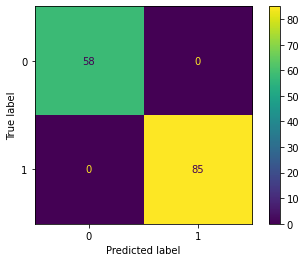

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


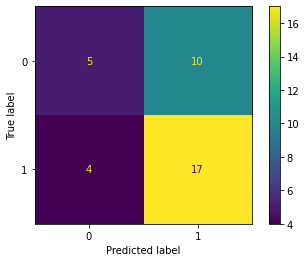

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6296296296296297
 -  Recall :  0.8095238095238095
 -  F1 score :  0.7083333333333334
 -  F2 score :  0.7657657657657657
 -  ROC AUC :  0.5714285714285714
KNN(original)
NB(original)
LR
SVM(original)
MLP
RF-2
XGB-4
LGBM-2

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:15:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


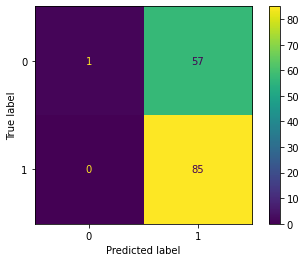

All metric scores:
 -  Accuracy :  0.6013986013986014
 -  Precision :  0.5985915492957746
 -  Recall :  1.0
 -  F1 score :  0.748898678414097
 -  F2 score :  0.8817427385892116
 -  ROC AUC :  0.5086206896551724
Validation Set: 
Confusion matrix:


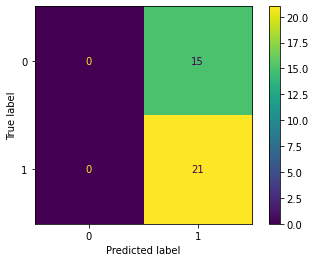

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:15:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


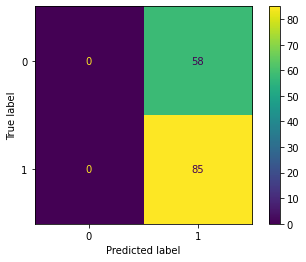

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


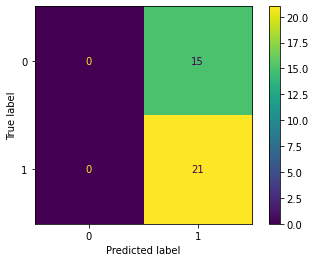

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246632
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Training Set: 
Confusion matrix:


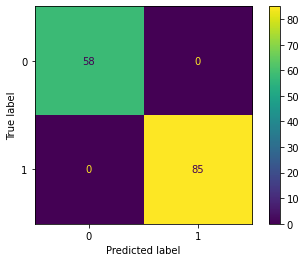

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


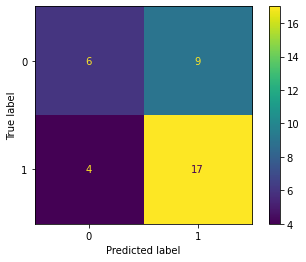

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6538461538461539
 -  Recall :  0.8095238095238095
 -  F1 score :  0.7234042553191489
 -  F2 score :  0.7727272727272726
 -  ROC AUC :  0.6047619047619048
- Soft Voting: 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246632
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Training Set: 
Confusion matrix:


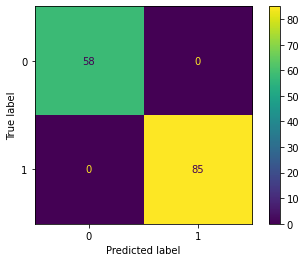

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


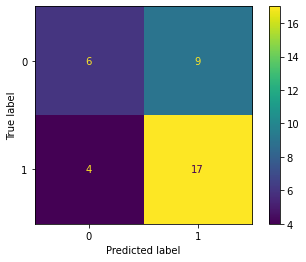

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6538461538461539
 -  Recall :  0.8095238095238095
 -  F1 score :  0.7234042553191489
 -  F2 score :  0.7727272727272726
 -  ROC AUC :  0.6047619047619048

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:16:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


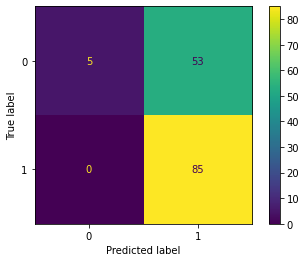

All metric scores:
 -  Accuracy :  0.6293706293706294
 -  Precision :  0.6159420289855072
 -  Recall :  1.0
 -  F1 score :  0.7623318385650223
 -  F2 score :  0.8891213389121339
 -  ROC AUC :  0.5431034482758621
Validation Set: 
Confusion matrix:


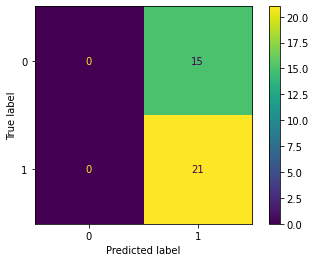

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:16:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


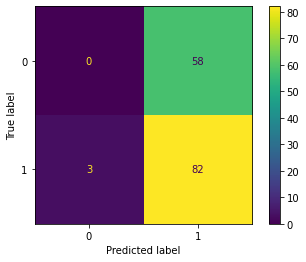

All metric scores:
 -  Accuracy :  0.5734265734265734
 -  Precision :  0.5857142857142857
 -  Recall :  0.9647058823529412
 -  F1 score :  0.7288888888888889
 -  F2 score :  0.8541666666666666
 -  ROC AUC :  0.4823529411764706
Validation Set: 
Confusion matrix:


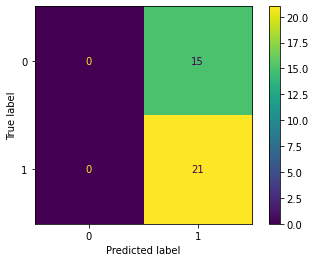

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
Best voting:  GS_HardVoting
Scores:  Confusion matrix    [[0, 15], [0, 21]]
Accuracy                      0.583333
Precision                     0.583333
Recall                             1.0
F1 score                      0.736842
F2 score                         0.875
ROC AUC                            0.5
dtype: object

---------------------------------------------------
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


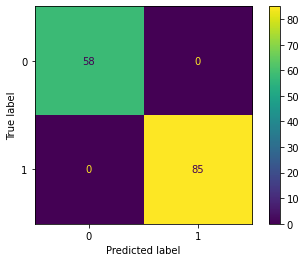

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


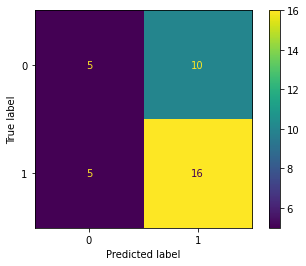

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6153846153846154
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6808510638297872
 -  F2 score :  0.7272727272727273
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


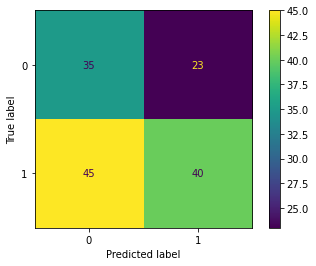

All metric scores:
 -  Accuracy :  0.5244755244755245
 -  Precision :  0.6349206349206349
 -  Recall :  0.47058823529411764
 -  F1 score :  0.5405405405405405
 -  F2 score :  0.4962779156327543
 -  ROC AUC :  0.5370182555780934

- NB Test
Confusion matrix:


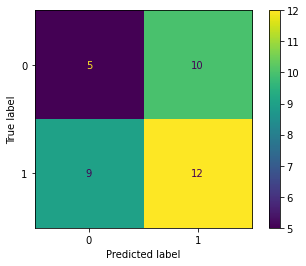

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5454545454545454
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5660377358490566
 -  ROC AUC :  0.4523809523809524

-------------------------
- LR Train
Confusion matrix:


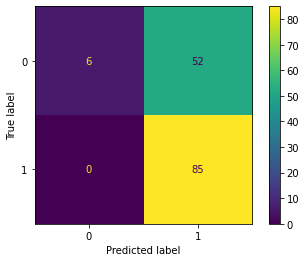

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.6204379562043796
 -  Recall :  1.0
 -  F1 score :  0.7657657657657658
 -  F2 score :  0.8909853249475891
 -  ROC AUC :  0.5517241379310345

- LR Test
Confusion matrix:


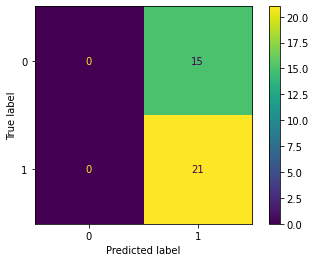

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


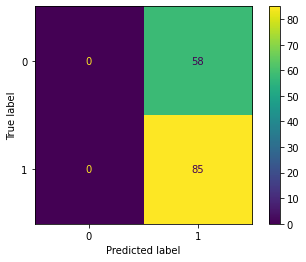

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


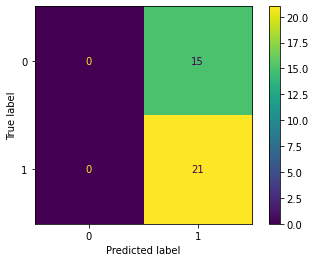

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


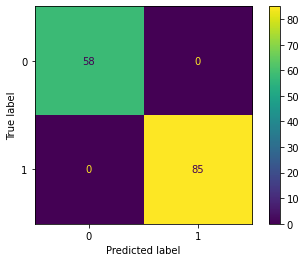

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


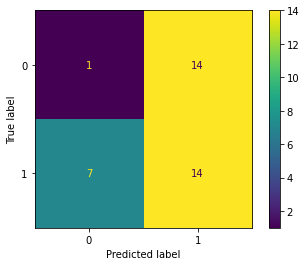

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5714285714285715
 -  F2 score :  0.625
 -  ROC AUC :  0.36666666666666664

-------------------------
- RF-2 Train
Confusion matrix:


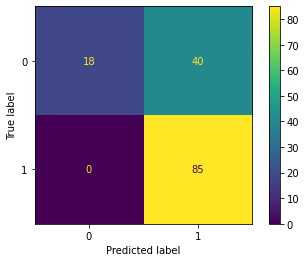

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.68
 -  Recall :  1.0
 -  F1 score :  0.8095238095238095
 -  F2 score :  0.913978494623656
 -  ROC AUC :  0.6551724137931034

- RF-2 Test
Confusion matrix:


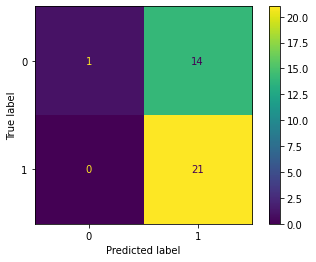

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------
- XGB-4 Train
Confusion matrix:


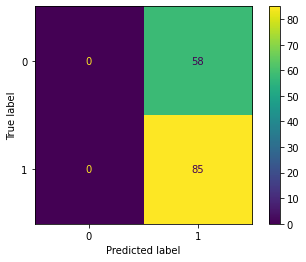

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


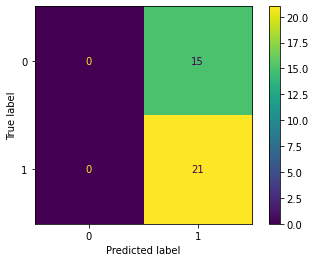

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


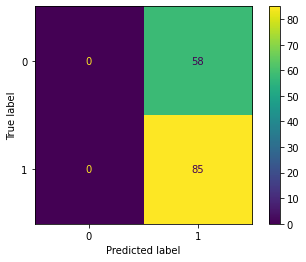

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


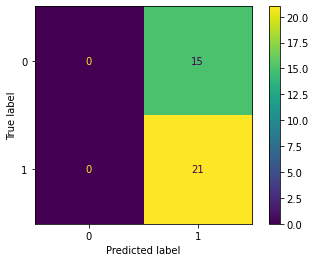

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


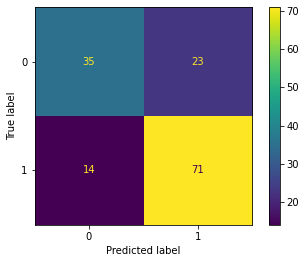

All metric scores:
 -  Accuracy :  0.7412587412587412
 -  Precision :  0.7553191489361702
 -  Recall :  0.8352941176470589
 -  F1 score :  0.7932960893854748
 -  F2 score :  0.8179723502304147
 -  ROC AUC :  0.719371196754564

- KNN(original) Test
Confusion matrix:


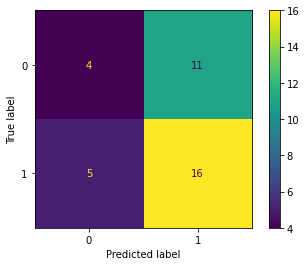

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5925925925925926
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6666666666666666
 -  F2 score :  0.7207207207207207
 -  ROC AUC :  0.5142857142857142

-------------------------
- NB(original) Train
Confusion matrix:


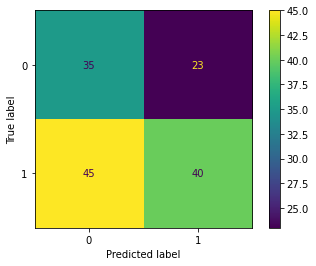

All metric scores:
 -  Accuracy :  0.5244755244755245
 -  Precision :  0.6349206349206349
 -  Recall :  0.47058823529411764
 -  F1 score :  0.5405405405405405
 -  F2 score :  0.4962779156327543
 -  ROC AUC :  0.5370182555780934

- NB(original) Test
Confusion matrix:


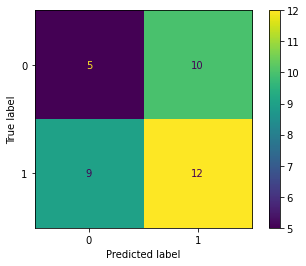

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5454545454545454
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5660377358490566
 -  ROC AUC :  0.4523809523809524

-------------------------
- LR(original) Train
Confusion matrix:


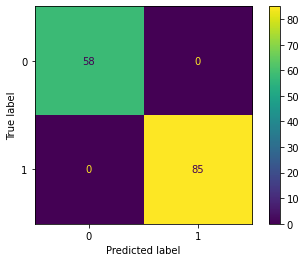

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


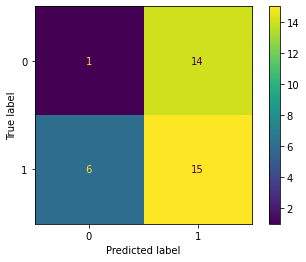

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5172413793103449
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6000000000000001
 -  F2 score :  0.663716814159292
 -  ROC AUC :  0.39047619047619053

-------------------------
- SVM(original) Train
Confusion matrix:


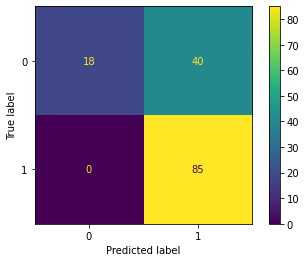

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.68
 -  Recall :  1.0
 -  F1 score :  0.8095238095238095
 -  F2 score :  0.913978494623656
 -  ROC AUC :  0.6551724137931034

- SVM(original) Test
Confusion matrix:


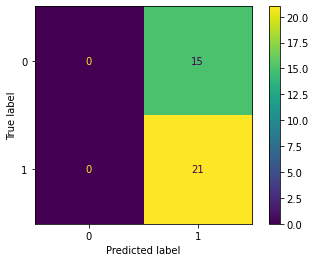

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


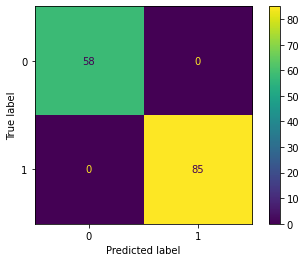

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


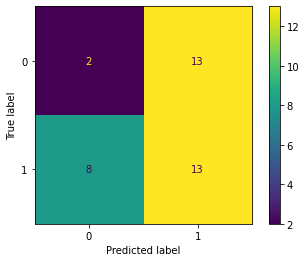

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5
 -  Recall :  0.6190476190476191
 -  F1 score :  0.5531914893617021
 -  F2 score :  0.5909090909090909
 -  ROC AUC :  0.3761904761904762

-------------------------
- RF(original) Train
Confusion matrix:


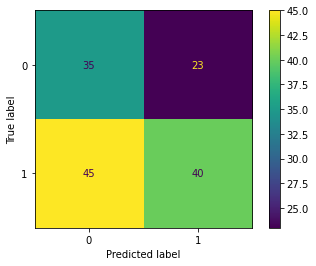

All metric scores:
 -  Accuracy :  0.5244755244755245
 -  Precision :  0.6349206349206349
 -  Recall :  0.47058823529411764
 -  F1 score :  0.5405405405405405
 -  F2 score :  0.4962779156327543
 -  ROC AUC :  0.5370182555780934

- RF(original) Test
Confusion matrix:


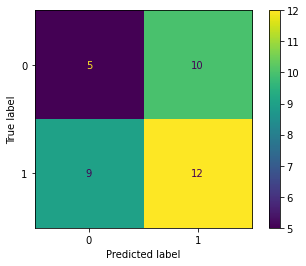

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5454545454545454
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5660377358490566
 -  ROC AUC :  0.4523809523809524

-------------------------
- XGB(original) Train
Confusion matrix:


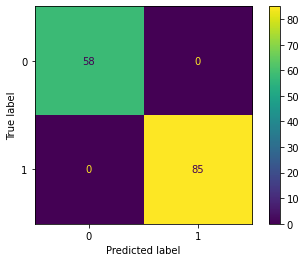

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


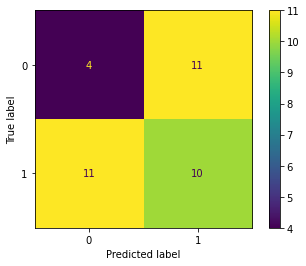

All metric scores:
 -  Accuracy :  0.3888888888888889
 -  Precision :  0.47619047619047616
 -  Recall :  0.47619047619047616
 -  F1 score :  0.47619047619047616
 -  F2 score :  0.4761904761904762
 -  ROC AUC :  0.37142857142857144
[LightGBM] [Info] Number of positive: 85, number of negative: 58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246635
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

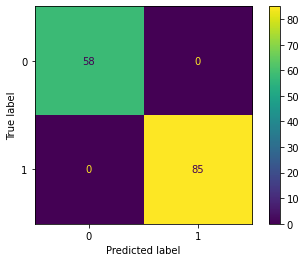

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


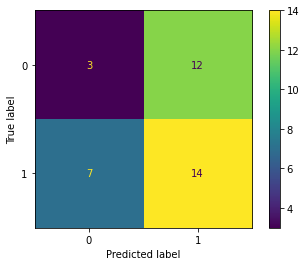

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5384615384615384
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5957446808510638
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.43333333333333324
KNN
NB(original)
LR
SVM(original)
MLP
RF-2
XGB-4
LGBM-2

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:17:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


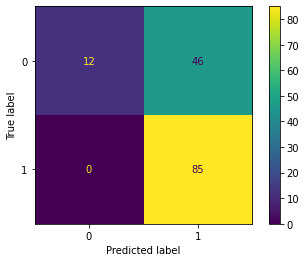

All metric scores:
 -  Accuracy :  0.6783216783216783
 -  Precision :  0.648854961832061
 -  Recall :  1.0
 -  F1 score :  0.787037037037037
 -  F2 score :  0.9023354564755839
 -  ROC AUC :  0.603448275862069
Validation Set: 
Confusion matrix:


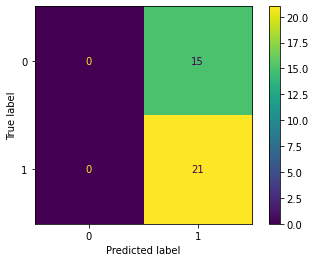

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:18:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


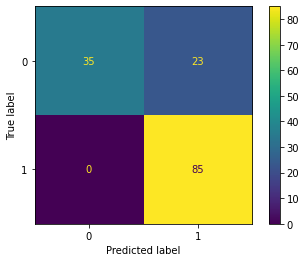

All metric scores:
 -  Accuracy :  0.8391608391608392
 -  Precision :  0.7870370370370371
 -  Recall :  1.0
 -  F1 score :  0.8808290155440415
 -  F2 score :  0.9486607142857142
 -  ROC AUC :  0.8017241379310345
Validation Set: 
Confusion matrix:


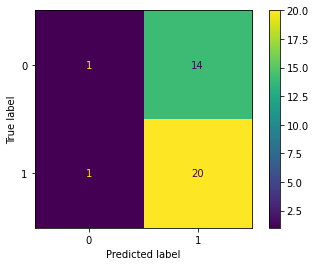

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.5095238095238095

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Training Set: 
Confusion matrix:


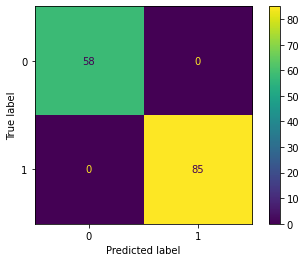

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


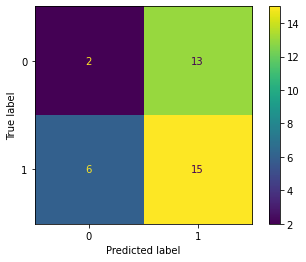

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5357142857142857
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6122448979591837
 -  F2 score :  0.6696428571428571
 -  ROC AUC :  0.4238095238095238
- Soft Voting: 
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.594406 -> initscore=0.382208
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

Training Set: 
Confusion matrix:


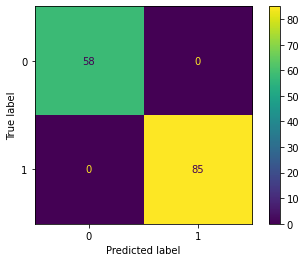

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


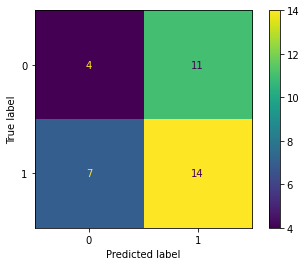

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.56
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.6422018348623854
 -  ROC AUC :  0.4666666666666667

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:18:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


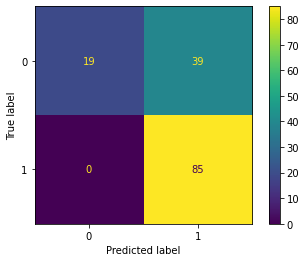

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.6854838709677419
 -  Recall :  1.0
 -  F1 score :  0.8133971291866028
 -  F2 score :  0.915948275862069
 -  ROC AUC :  0.6637931034482758
Validation Set: 
Confusion matrix:


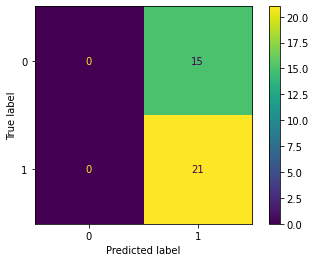

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:19:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


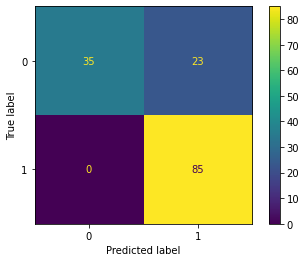

All metric scores:
 -  Accuracy :  0.8391608391608392
 -  Precision :  0.7870370370370371
 -  Recall :  1.0
 -  F1 score :  0.8808290155440415
 -  F2 score :  0.9486607142857142
 -  ROC AUC :  0.8017241379310345
Validation Set: 
Confusion matrix:


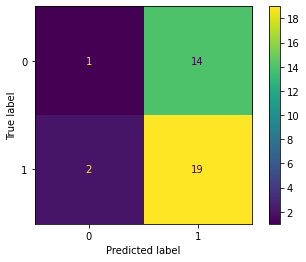

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5757575757575758
 -  Recall :  0.9047619047619048
 -  F1 score :  0.7037037037037038
 -  F2 score :  0.811965811965812
 -  ROC AUC :  0.4857142857142857
Best voting:  GS_HardVoting
Scores:  Confusion matrix    [[0, 15], [0, 21]]
Accuracy                      0.583333
Precision                     0.583333
Recall                             1.0
F1 score                      0.736842
F2 score                         0.875
ROC AUC                            0.5
dtype: object

---------------------------------------------------
(144, 5000)
(35, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 59
Number Non-Tipical Development: 21
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


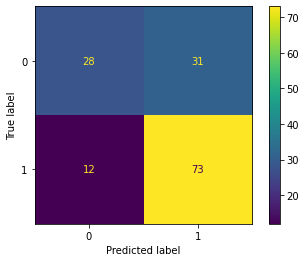

All metric scores:
 -  Accuracy :  0.7013888888888888
 -  Precision :  0.7019230769230769
 -  Recall :  0.8588235294117647
 -  F1 score :  0.7724867724867726
 -  F2 score :  0.822072072072072
 -  ROC AUC :  0.6666999002991026

- KNN Test
Confusion matrix:


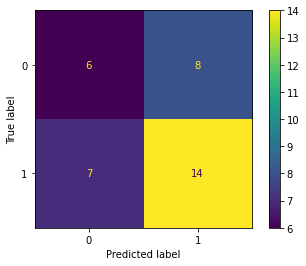

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.6363636363636364
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6511627906976744
 -  F2 score :  0.660377358490566
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


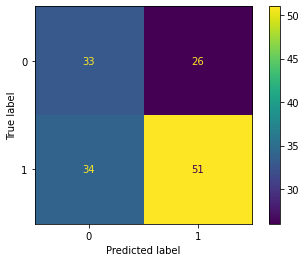

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6623376623376623
 -  Recall :  0.6
 -  F1 score :  0.6296296296296295
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5796610169491526

- NB Test
Confusion matrix:


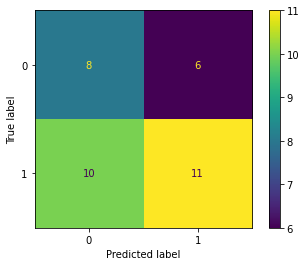

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5476190476190476

-------------------------
- LR Train
Confusion matrix:


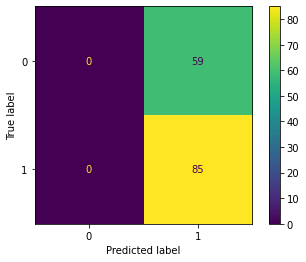

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


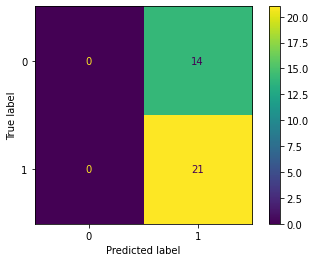

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


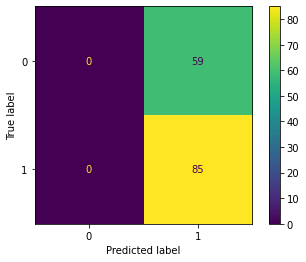

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


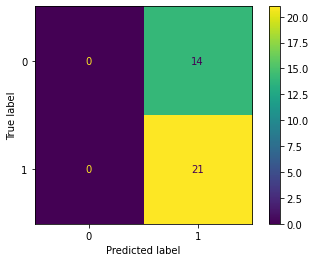

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


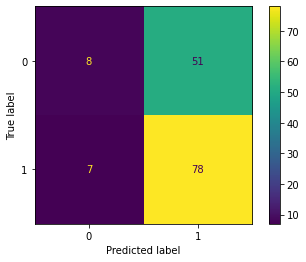

All metric scores:
 -  Accuracy :  0.5972222222222222
 -  Precision :  0.6046511627906976
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7289719626168223
 -  F2 score :  0.8315565031982943
 -  ROC AUC :  0.5266201395812562

- MLP Test
Confusion matrix:


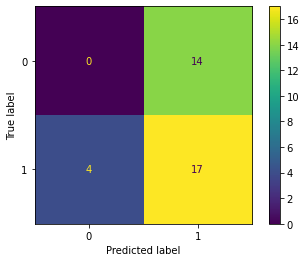

All metric scores:
 -  Accuracy :  0.4857142857142857
 -  Precision :  0.5483870967741935
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6538461538461537
 -  F2 score :  0.7391304347826086
 -  ROC AUC :  0.40476190476190477

-------------------------
- RF-2 Train
Confusion matrix:


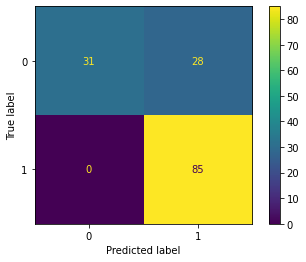

All metric scores:
 -  Accuracy :  0.8055555555555556
 -  Precision :  0.7522123893805309
 -  Recall :  1.0
 -  F1 score :  0.8585858585858585
 -  F2 score :  0.9381898454746136
 -  ROC AUC :  0.7627118644067796

- RF-2 Test
Confusion matrix:


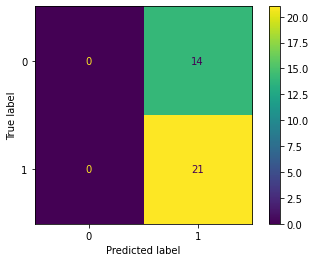

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


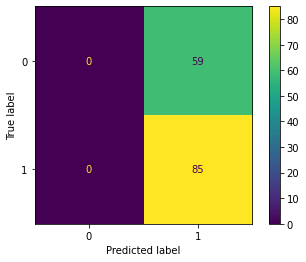

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


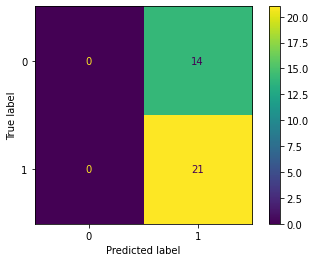

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


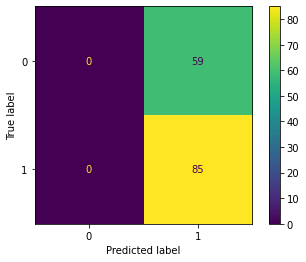

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


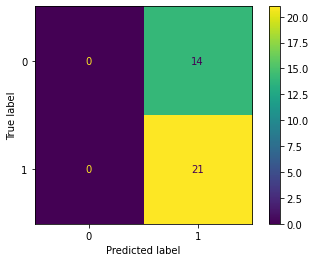

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


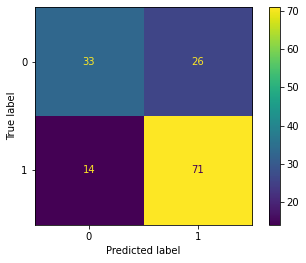

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.7319587628865979
 -  Recall :  0.8352941176470589
 -  F1 score :  0.7802197802197801
 -  F2 score :  0.8123569794050343
 -  ROC AUC :  0.6973080757726821

- KNN(original) Test
Confusion matrix:


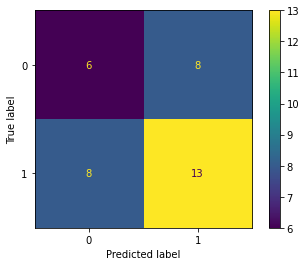

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6190476190476191
 -  Recall :  0.6190476190476191
 -  F1 score :  0.6190476190476191
 -  F2 score :  0.6190476190476191
 -  ROC AUC :  0.5238095238095238

-------------------------
- NB(original) Train
Confusion matrix:


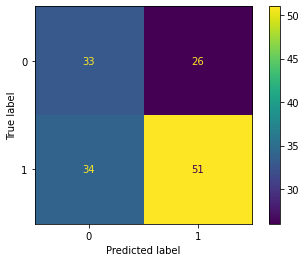

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6623376623376623
 -  Recall :  0.6
 -  F1 score :  0.6296296296296295
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5796610169491526

- NB(original) Test
Confusion matrix:


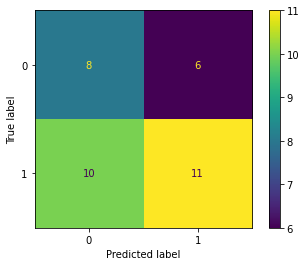

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5476190476190476

-------------------------
- LR(original) Train
Confusion matrix:


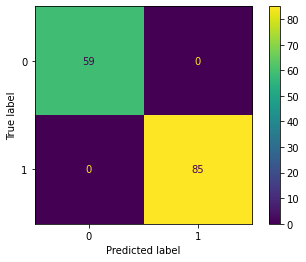

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


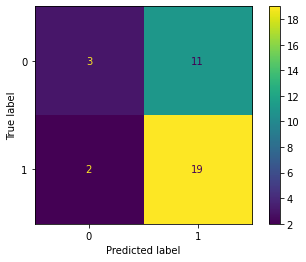

All metric scores:
 -  Accuracy :  0.6285714285714286
 -  Precision :  0.6333333333333333
 -  Recall :  0.9047619047619048
 -  F1 score :  0.7450980392156863
 -  F2 score :  0.8333333333333334
 -  ROC AUC :  0.5595238095238095

-------------------------
- SVM(original) Train
Confusion matrix:


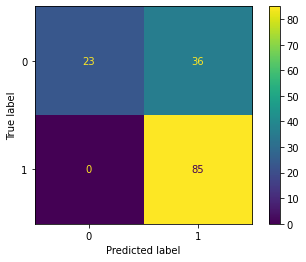

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.7024793388429752
 -  Recall :  1.0
 -  F1 score :  0.8252427184466019
 -  F2 score :  0.9219088937093276
 -  ROC AUC :  0.6949152542372881

- SVM(original) Test
Confusion matrix:


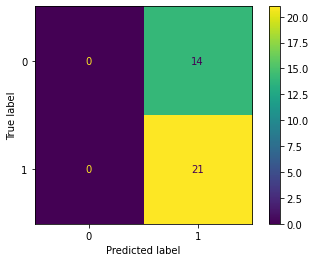

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


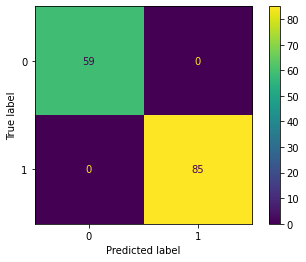

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


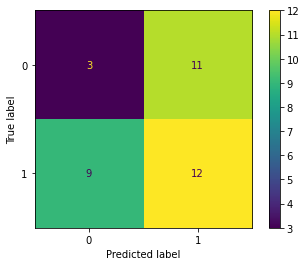

All metric scores:
 -  Accuracy :  0.42857142857142855
 -  Precision :  0.5217391304347826
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5454545454545454
 -  F2 score :  0.5607476635514018
 -  ROC AUC :  0.39285714285714285

-------------------------
- RF(original) Train
Confusion matrix:


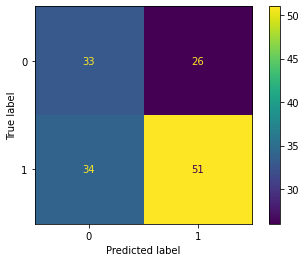

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6623376623376623
 -  Recall :  0.6
 -  F1 score :  0.6296296296296295
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5796610169491526

- RF(original) Test
Confusion matrix:


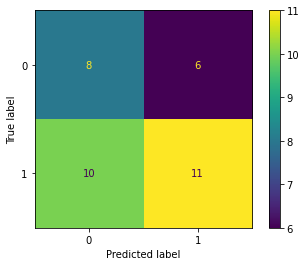

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5476190476190476

-------------------------
- XGB(original) Train
Confusion matrix:


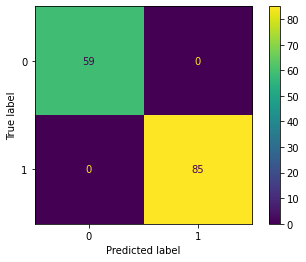

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


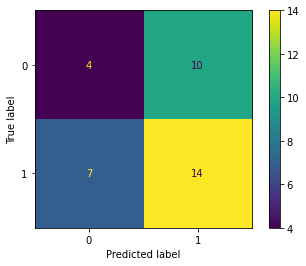

All metric scores:
 -  Accuracy :  0.5142857142857142
 -  Precision :  0.5833333333333334
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6222222222222222
 -  F2 score :  0.6481481481481483
 -  ROC AUC :  0.47619047619047616
[LightGBM] [Info] Number of positive: 85, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248260
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590278 -> initscore=0.365114
[LightGBM] [Info] Start training from score 0.365114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

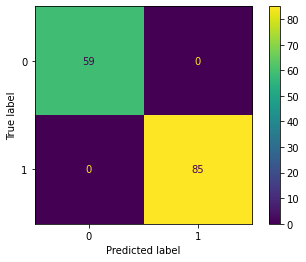

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


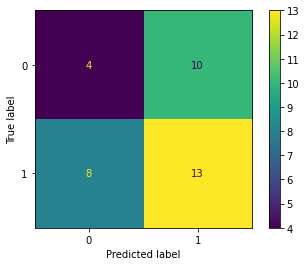

All metric scores:
 -  Accuracy :  0.4857142857142857
 -  Precision :  0.5652173913043478
 -  Recall :  0.6190476190476191
 -  F1 score :  0.5909090909090909
 -  F2 score :  0.6074766355140186
 -  ROC AUC :  0.4523809523809524
KNN
NB(original)
LR
SVM(original)
MLP
RF-2
XGB-4
LGBM-2

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:19:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


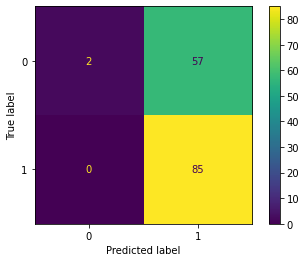

All metric scores:
 -  Accuracy :  0.6041666666666666
 -  Precision :  0.5985915492957746
 -  Recall :  1.0
 -  F1 score :  0.748898678414097
 -  F2 score :  0.8817427385892116
 -  ROC AUC :  0.5169491525423728
Validation Set: 
Confusion matrix:


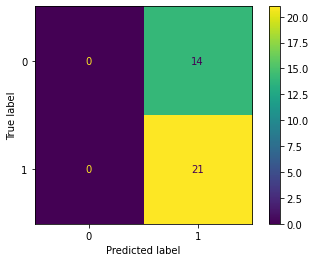

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:20:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


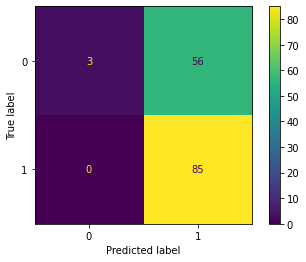

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6028368794326241
 -  Recall :  1.0
 -  F1 score :  0.752212389380531
 -  F2 score :  0.8835758835758836
 -  ROC AUC :  0.5254237288135593
Validation Set: 
Confusion matrix:


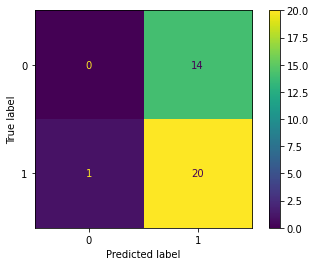

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.47619047619047616

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Training Set: 
Confusion matrix:


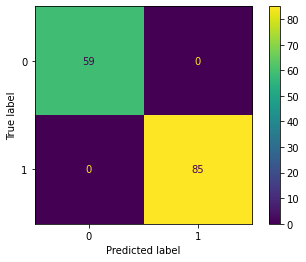

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


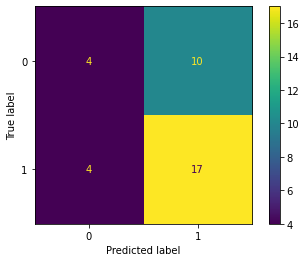

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6296296296296297
 -  Recall :  0.8095238095238095
 -  F1 score :  0.7083333333333334
 -  F2 score :  0.7657657657657657
 -  ROC AUC :  0.5476190476190477
- Soft Voting: 
[LightGBM] [Info] Start training from score 0.382208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Training Set: 
Confusion matrix:


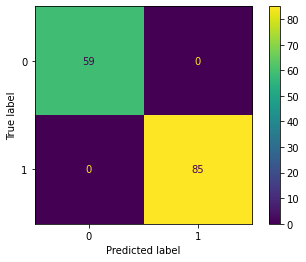

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


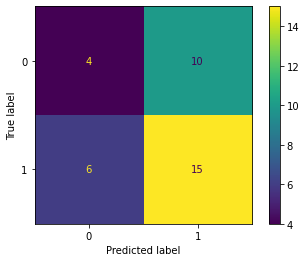

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6
 -  Recall :  0.7142857142857143
 -  F1 score :  0.6521739130434783
 -  F2 score :  0.6880733944954128
 -  ROC AUC :  0.5

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:20:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


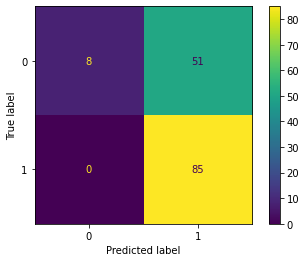

All metric scores:
 -  Accuracy :  0.6458333333333334
 -  Precision :  0.625
 -  Recall :  1.0
 -  F1 score :  0.7692307692307693
 -  F2 score :  0.8928571428571429
 -  ROC AUC :  0.5677966101694916
Validation Set: 
Confusion matrix:


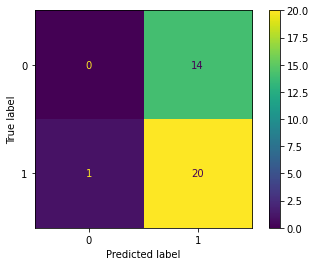

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.47619047619047616
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:21:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


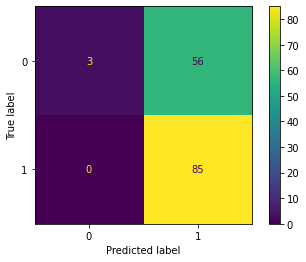

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6028368794326241
 -  Recall :  1.0
 -  F1 score :  0.752212389380531
 -  F2 score :  0.8835758835758836
 -  ROC AUC :  0.5254237288135593
Validation Set: 
Confusion matrix:


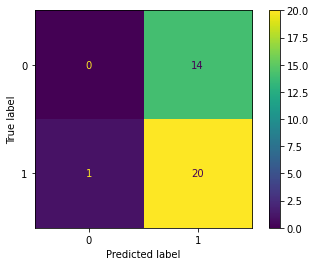

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.47619047619047616
Best voting:  GS_HardVoting
Scores:  Confusion matrix    [[0, 14], [0, 21]]
Accuracy                           0.6
Precision                          0.6
Recall                             1.0
F1 score                          0.75
F2 score                      0.882353
ROC AUC                            0.5
dtype: object

---------------------------------------------------


In [41]:
# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     X_train_CV = X_train.iloc[train_index]
#     X_val_CV = X_train.iloc[test_index]
    
#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
#     y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])
    
#     est_og = [("KNN(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', KNeighborsClassifier())])),
#               ("NB(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', GaussianNB())])),
#               ("LR(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', LogisticRegression(max_iter=5000))])),
#               ("SVM(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', svm.SVC(probability=True))])),
#               ("MLP(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', MLPClassifier(random_state=3))])),
#               ("RF(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', GaussianNB())])),
#               ("XGB(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', XGBClassifier(seed=3,scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
#                                                                       ))])),
#               ("LGBM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', LGBMClassifier(random_state=3))]))
#              ]   
    
#     est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]
    
#     est_gs.pop(5)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(7)
    
#     print("\n---------------------------------------------------")
    
#     print("\n---Fold Summary---")
    
#     train_scores_gs = []
#     val_scores_gs = []
    
#     print("\n--Grid Search Estimators")
#     for (key, estimator) in est_gs:
#         estimator.fit(X_train_CV, y_train_CV)
        
#         print("\n-------------------------")
#         print("-", key, "Train")
        
#         train_scores_gs.append(all_scores(y_train_CV,
#                                           estimator.predict(X_train_CV),
#                                           to_print = True))
        
#         print("\n-", key, "Test")
#         val_scores_gs.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
#     train_scores_og = []
#     val_scores_og = []
    
#     print("\n  --Original Estimators")
#     for (key, estimator) in est_og:
#         estimator.fit(X_train_CV, y_train_CV)
        
#         print("\n-------------------------")
#         print("-", key, "Train")
        
#         train_scores_og.append(all_scores(y_true = y_train_CV,
#                                        y_pred = estimator.predict(X_train_CV),
#                                        to_print = True))
        
#         print("\n-", key, "Test")
#         val_scores_og.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
        
    
#     est_mix = []
    
#     for j, (key, _) in enumerate(est_gs):
#         if(val_scores_gs[j]["F2 score"] > val_scores_og[j]["F2 score"]):
#             est_mix.append(est_gs[j])
#         else:
#             est_mix.append(est_og[j])
      
        
#     [print(key) for (key, _) in est_mix]
    
    
#     voting_training_scores = []
#     voting_validation_scores = []
    
#     #hard voting
    
#     print("\n -- Grid Search estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_gs, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_gs, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)
                
#     print("Training Set: ")
#     voting_training_scores.append(("GS_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
    
    
    
#     print("\n -- Untuned estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_og, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_og, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True))) 
    
    
#     print("\n -- Mixed estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_mix, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_mix, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     best_scores = ("null", {"F2 score": -1})
#     for tup in voting_validation_scores:
#         if (tup[1]["F2 score"] > best_scores[1]["F2 score"]):
#             best_scores = tup
        
#     print("Best voting: ", best_scores[0])
#     print("Scores: ", best_scores[1])
    
#     print("\n---------------------------------------------------")

(143, 5000)
(36, 5000)
Number Non-Tipical Development: 84
Number Tipical Development: 59
Number Non-Tipical Development: 22
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


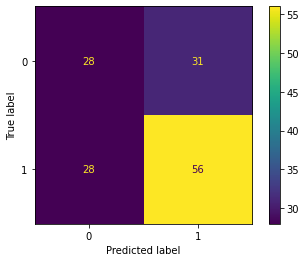

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6436781609195402
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6549707602339181
 -  F2 score :  0.6619385342789598
 -  ROC AUC :  0.5706214689265536

- KNN Test
Confusion matrix:


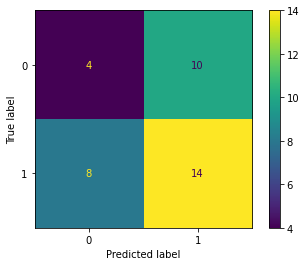

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5833333333333334
 -  Recall :  0.6363636363636364
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.625
 -  ROC AUC :  0.461038961038961

-------------------------
- NB Train
Confusion matrix:


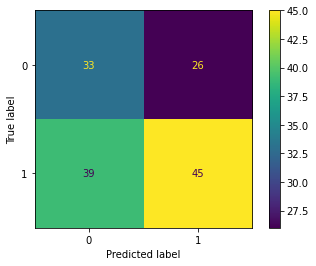

All metric scores:
 -  Accuracy :  0.5454545454545454
 -  Precision :  0.6338028169014085
 -  Recall :  0.5357142857142857
 -  F1 score :  0.5806451612903227
 -  F2 score :  0.5528255528255529
 -  ROC AUC :  0.5475181598062954

- NB Test
Confusion matrix:


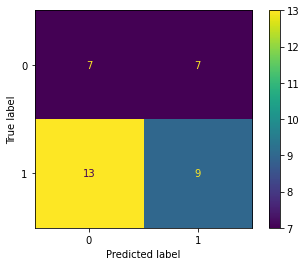

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5625
 -  Recall :  0.4090909090909091
 -  F1 score :  0.47368421052631576
 -  F2 score :  0.4326923076923077
 -  ROC AUC :  0.4545454545454546

-------------------------
- LR Train
Confusion matrix:


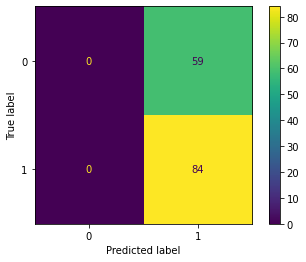

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


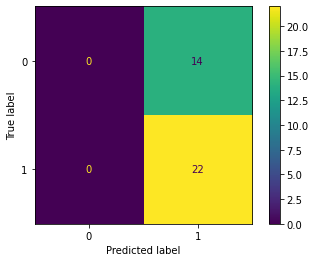

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


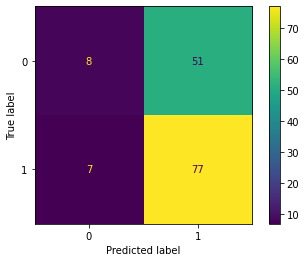

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.6015625
 -  Recall :  0.9166666666666666
 -  F1 score :  0.7264150943396227
 -  F2 score :  0.8297413793103448
 -  ROC AUC :  0.5261299435028248

- SVM Test
Confusion matrix:


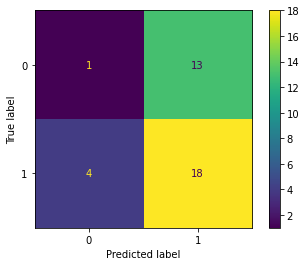

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5806451612903226
 -  Recall :  0.8181818181818182
 -  F1 score :  0.679245283018868
 -  F2 score :  0.7563025210084033
 -  ROC AUC :  0.4448051948051948

-------------------------
- MLP Train
Confusion matrix:


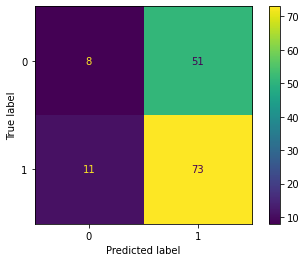

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.5887096774193549
 -  Recall :  0.8690476190476191
 -  F1 score :  0.701923076923077
 -  F2 score :  0.7934782608695653
 -  ROC AUC :  0.502320419693301

- MLP Test
Confusion matrix:


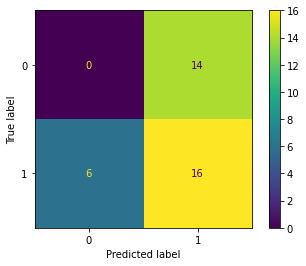

All metric scores:
 -  Accuracy :  0.4444444444444444
 -  Precision :  0.5333333333333333
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6153846153846153
 -  F2 score :  0.6779661016949153
 -  ROC AUC :  0.36363636363636365

-------------------------
- RF-2 Train
Confusion matrix:


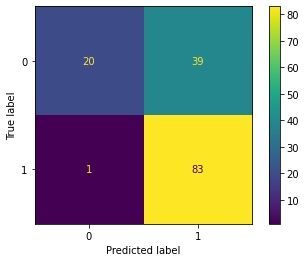

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.680327868852459
 -  Recall :  0.9880952380952381
 -  F1 score :  0.8058252427184467
 -  F2 score :  0.906113537117904
 -  ROC AUC :  0.6635391444713479

- RF-2 Test
Confusion matrix:


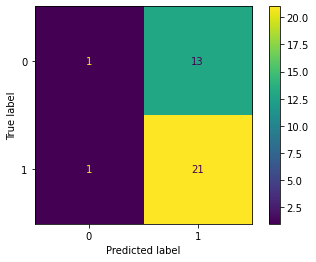

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6176470588235294
 -  Recall :  0.9545454545454546
 -  F1 score :  0.75
 -  F2 score :  0.8606557377049181
 -  ROC AUC :  0.512987012987013

-------------------------
- XGB-4 Train
Confusion matrix:


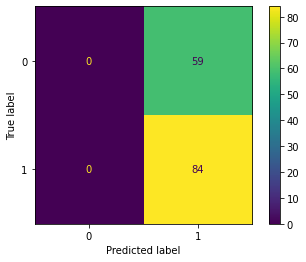

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


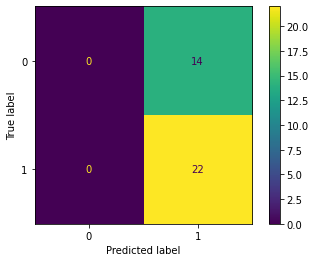

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


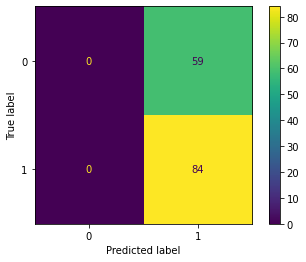

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.5874125874125874
 -  Recall :  1.0
 -  F1 score :  0.7400881057268722
 -  F2 score :  0.8768267223382046
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


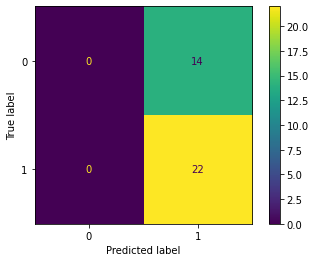

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6111111111111112
 -  Recall :  1.0
 -  F1 score :  0.7586206896551725
 -  F2 score :  0.8870967741935484
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:21:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


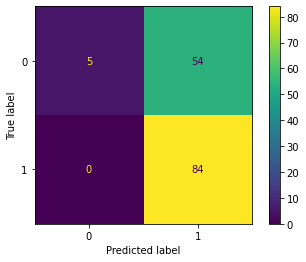

All metric scores:
 -  Accuracy :  0.6223776223776224
 -  Precision :  0.6086956521739131
 -  Recall :  1.0
 -  F1 score :  0.7567567567567568
 -  F2 score :  0.8860759493670887
 -  ROC AUC :  0.5423728813559322
Validation Set: 
Confusion matrix:


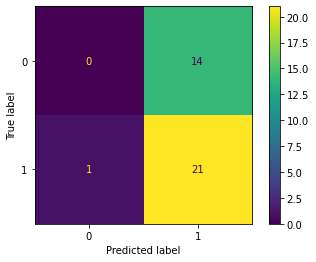

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6
 -  Recall :  0.9545454545454546
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.853658536585366
 -  ROC AUC :  0.4772727272727273
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


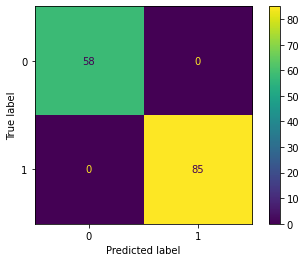

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


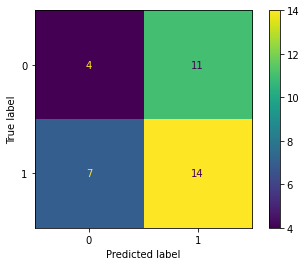

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.56
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.6422018348623854
 -  ROC AUC :  0.4666666666666667

-------------------------
- NB Train
Confusion matrix:


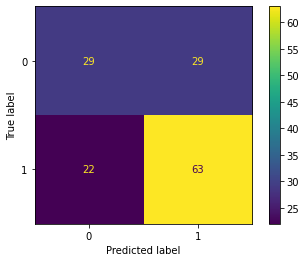

All metric scores:
 -  Accuracy :  0.6433566433566433
 -  Precision :  0.6847826086956522
 -  Recall :  0.7411764705882353
 -  F1 score :  0.7118644067796609
 -  F2 score :  0.7291666666666667
 -  ROC AUC :  0.6205882352941177

- NB Test
Confusion matrix:


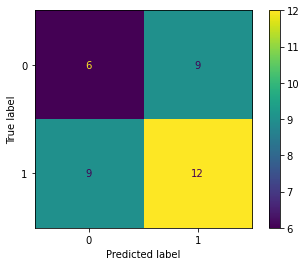

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.5714285714285714
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5714285714285714
 -  F2 score :  0.5714285714285714
 -  ROC AUC :  0.48571428571428565

-------------------------
- LR Train
Confusion matrix:


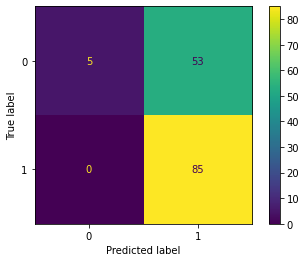

All metric scores:
 -  Accuracy :  0.6293706293706294
 -  Precision :  0.6159420289855072
 -  Recall :  1.0
 -  F1 score :  0.7623318385650223
 -  F2 score :  0.8891213389121339
 -  ROC AUC :  0.5431034482758621

- LR Test
Confusion matrix:


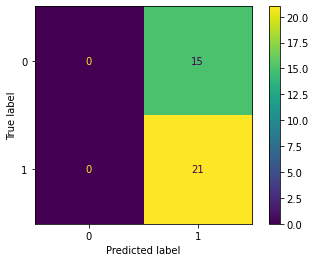

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


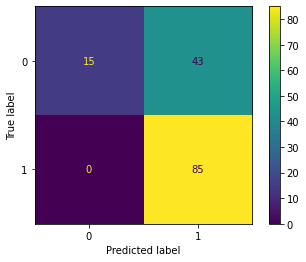

All metric scores:
 -  Accuracy :  0.6993006993006993
 -  Precision :  0.6640625
 -  Recall :  1.0
 -  F1 score :  0.7981220657276995
 -  F2 score :  0.9081196581196581
 -  ROC AUC :  0.6293103448275862

- SVM Test
Confusion matrix:


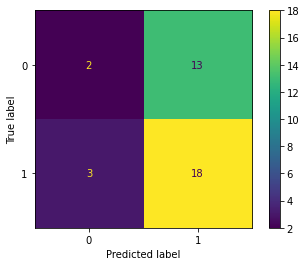

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- MLP Train
Confusion matrix:


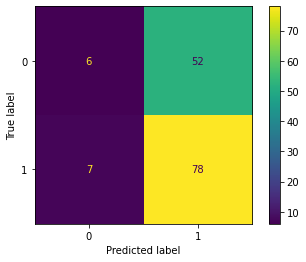

All metric scores:
 -  Accuracy :  0.5874125874125874
 -  Precision :  0.6
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7255813953488371
 -  F2 score :  0.8297872340425533
 -  ROC AUC :  0.5105476673427991

- MLP Test
Confusion matrix:


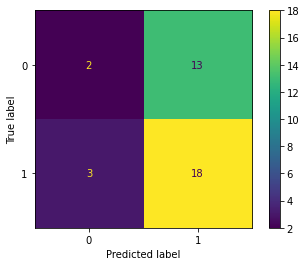

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5806451612903226
 -  Recall :  0.8571428571428571
 -  F1 score :  0.6923076923076923
 -  F2 score :  0.7826086956521738
 -  ROC AUC :  0.49523809523809526

-------------------------
- RF-2 Train
Confusion matrix:


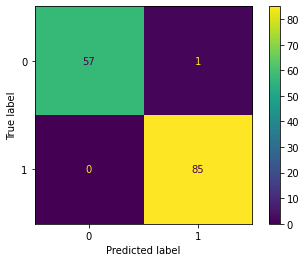

All metric scores:
 -  Accuracy :  0.993006993006993
 -  Precision :  0.9883720930232558
 -  Recall :  1.0
 -  F1 score :  0.9941520467836257
 -  F2 score :  0.9976525821596244
 -  ROC AUC :  0.9913793103448275

- RF-2 Test
Confusion matrix:


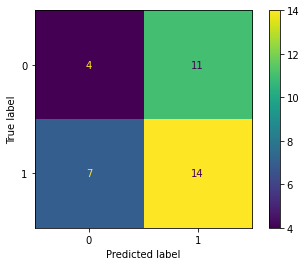

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.56
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6086956521739131
 -  F2 score :  0.6422018348623854
 -  ROC AUC :  0.4666666666666667

-------------------------
- XGB-4 Train
Confusion matrix:


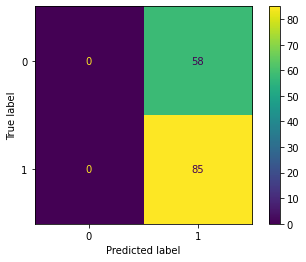

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


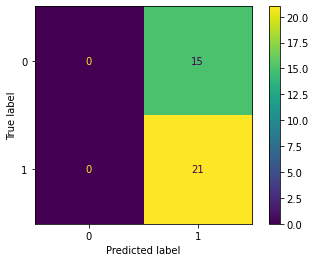

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


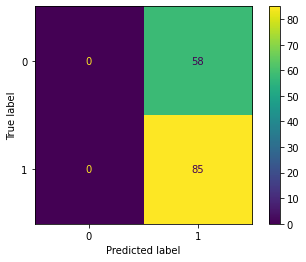

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


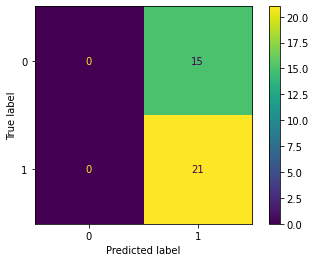

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:22:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


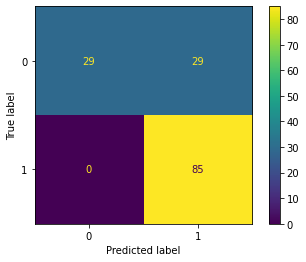

All metric scores:
 -  Accuracy :  0.7972027972027972
 -  Precision :  0.7456140350877193
 -  Recall :  1.0
 -  F1 score :  0.8542713567839196
 -  F2 score :  0.9361233480176211
 -  ROC AUC :  0.75
Validation Set: 
Confusion matrix:


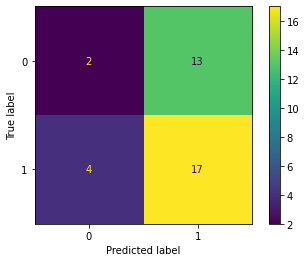

All metric scores:
 -  Accuracy :  0.5277777777777778
 -  Precision :  0.5666666666666667
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6666666666666666
 -  F2 score :  0.7456140350877193
 -  ROC AUC :  0.4714285714285714
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


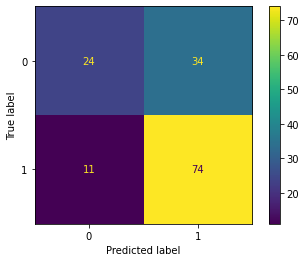

All metric scores:
 -  Accuracy :  0.6853146853146853
 -  Precision :  0.6851851851851852
 -  Recall :  0.8705882352941177
 -  F1 score :  0.766839378238342
 -  F2 score :  0.8258928571428572
 -  ROC AUC :  0.6421906693711967

- KNN Test
Confusion matrix:


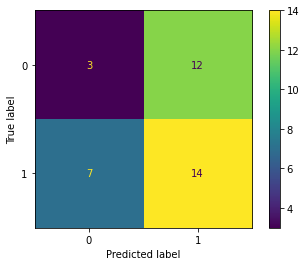

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5384615384615384
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5957446808510638
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.43333333333333324

-------------------------
- NB Train
Confusion matrix:


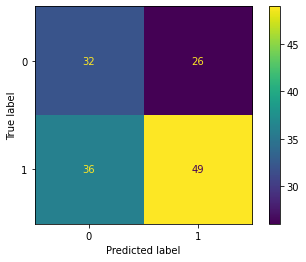

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.6533333333333333
 -  Recall :  0.5764705882352941
 -  F1 score :  0.6124999999999999
 -  F2 score :  0.5903614457831325
 -  ROC AUC :  0.5640973630831643

- NB Test
Confusion matrix:


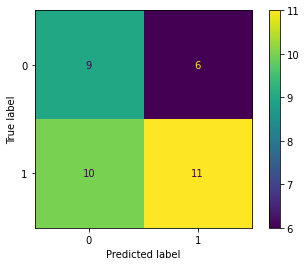

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5619047619047619

-------------------------
- LR Train
Confusion matrix:


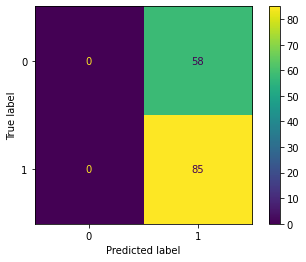

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


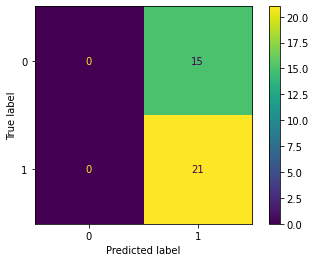

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


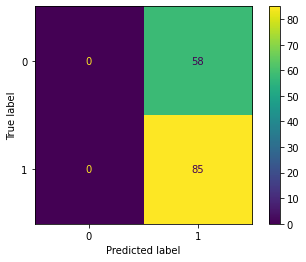

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


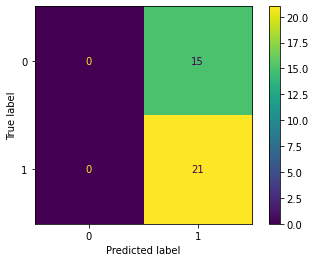

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


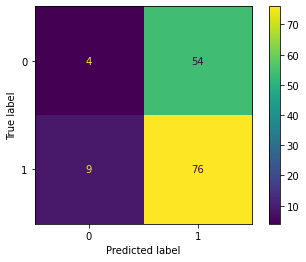

All metric scores:
 -  Accuracy :  0.5594405594405595
 -  Precision :  0.5846153846153846
 -  Recall :  0.8941176470588236
 -  F1 score :  0.7069767441860465
 -  F2 score :  0.8085106382978725
 -  ROC AUC :  0.48154158215010145

- MLP Test
Confusion matrix:


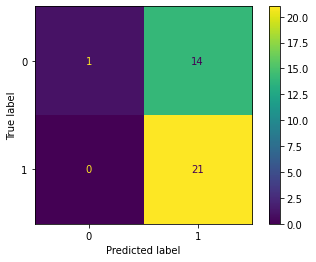

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------
- RF-2 Train
Confusion matrix:


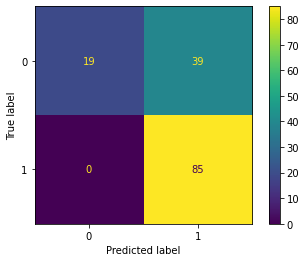

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.6854838709677419
 -  Recall :  1.0
 -  F1 score :  0.8133971291866028
 -  F2 score :  0.915948275862069
 -  ROC AUC :  0.6637931034482758

- RF-2 Test
Confusion matrix:


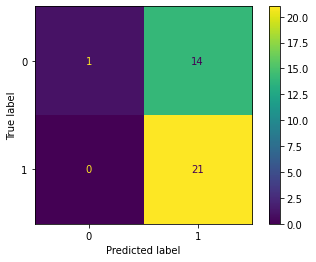

All metric scores:
 -  Accuracy :  0.6111111111111112
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5333333333333333

-------------------------
- XGB-4 Train
Confusion matrix:


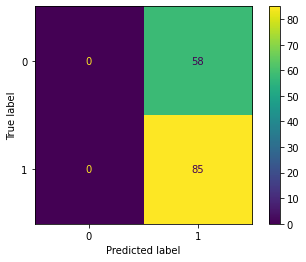

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


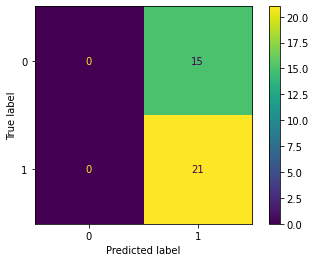

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


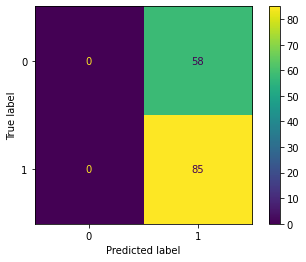

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


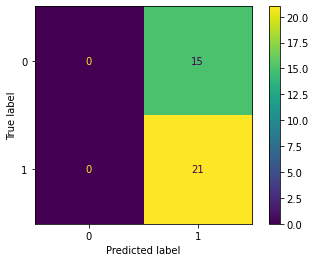

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:23:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


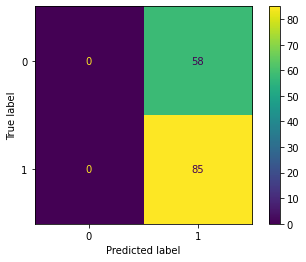

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


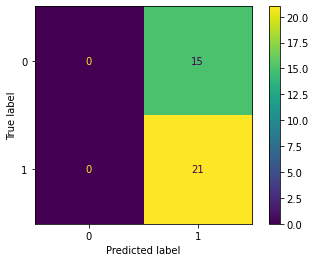

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


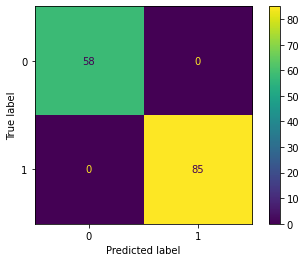

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


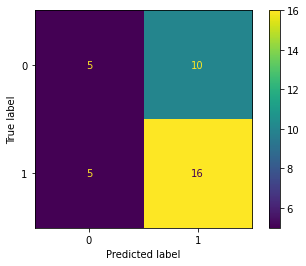

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6153846153846154
 -  Recall :  0.7619047619047619
 -  F1 score :  0.6808510638297872
 -  F2 score :  0.7272727272727273
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


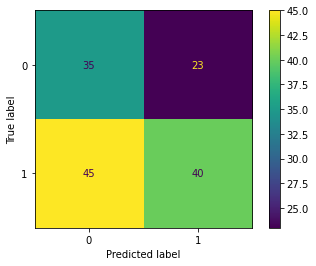

All metric scores:
 -  Accuracy :  0.5244755244755245
 -  Precision :  0.6349206349206349
 -  Recall :  0.47058823529411764
 -  F1 score :  0.5405405405405405
 -  F2 score :  0.4962779156327543
 -  ROC AUC :  0.5370182555780934

- NB Test
Confusion matrix:


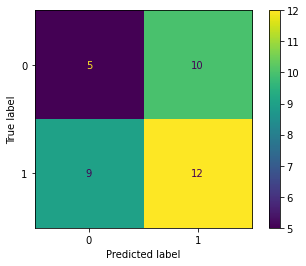

All metric scores:
 -  Accuracy :  0.4722222222222222
 -  Precision :  0.5454545454545454
 -  Recall :  0.5714285714285714
 -  F1 score :  0.5581395348837208
 -  F2 score :  0.5660377358490566
 -  ROC AUC :  0.4523809523809524

-------------------------
- LR Train
Confusion matrix:


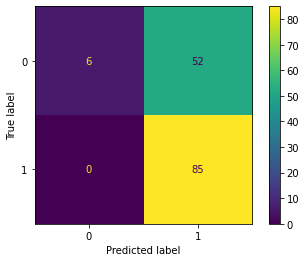

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.6204379562043796
 -  Recall :  1.0
 -  F1 score :  0.7657657657657658
 -  F2 score :  0.8909853249475891
 -  ROC AUC :  0.5517241379310345

- LR Test
Confusion matrix:


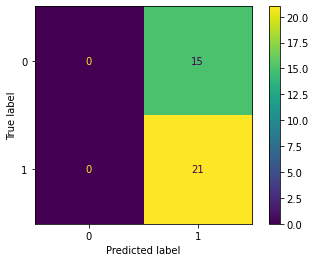

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


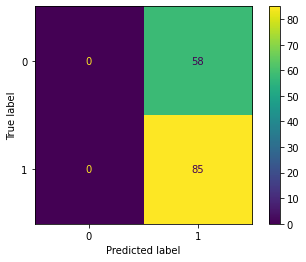

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


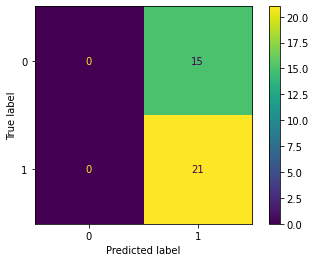

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


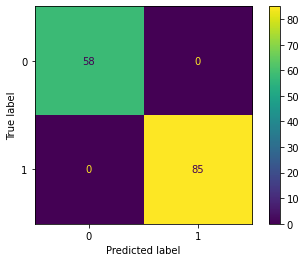

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


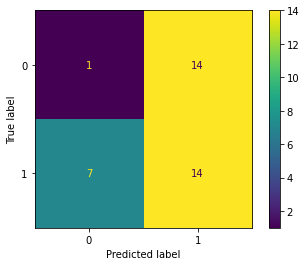

All metric scores:
 -  Accuracy :  0.4166666666666667
 -  Precision :  0.5
 -  Recall :  0.6666666666666666
 -  F1 score :  0.5714285714285715
 -  F2 score :  0.625
 -  ROC AUC :  0.36666666666666664

-------------------------
- RF-2 Train
Confusion matrix:


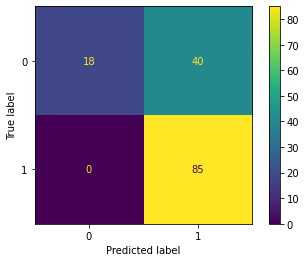

All metric scores:
 -  Accuracy :  0.7202797202797203
 -  Precision :  0.68
 -  Recall :  1.0
 -  F1 score :  0.8095238095238095
 -  F2 score :  0.913978494623656
 -  ROC AUC :  0.6551724137931034

- RF-2 Test
Confusion matrix:


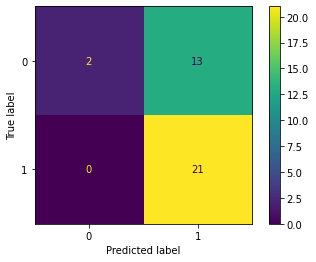

All metric scores:
 -  Accuracy :  0.6388888888888888
 -  Precision :  0.6176470588235294
 -  Recall :  1.0
 -  F1 score :  0.7636363636363637
 -  F2 score :  0.8898305084745762
 -  ROC AUC :  0.5666666666666667

-------------------------
- XGB-4 Train
Confusion matrix:


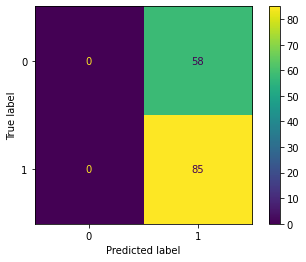

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


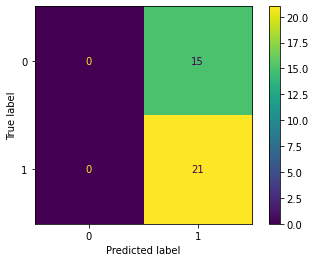

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


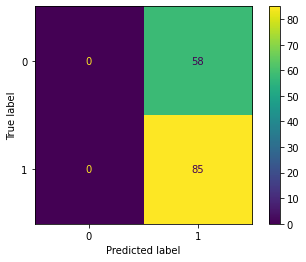

All metric scores:
 -  Accuracy :  0.5944055944055944
 -  Precision :  0.5944055944055944
 -  Recall :  1.0
 -  F1 score :  0.7456140350877193
 -  F2 score :  0.8799171842650103
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


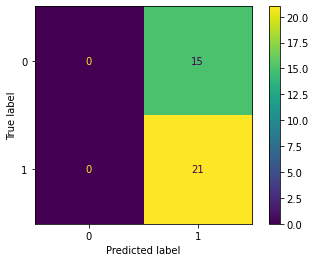

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.5833333333333334
 -  Recall :  1.0
 -  F1 score :  0.7368421052631579
 -  F2 score :  0.875
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:23:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


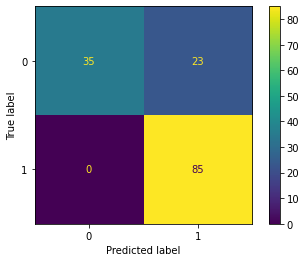

All metric scores:
 -  Accuracy :  0.8391608391608392
 -  Precision :  0.7870370370370371
 -  Recall :  1.0
 -  F1 score :  0.8808290155440415
 -  F2 score :  0.9486607142857142
 -  ROC AUC :  0.8017241379310345
Validation Set: 
Confusion matrix:


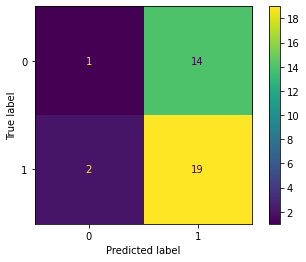

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.5757575757575758
 -  Recall :  0.9047619047619048
 -  F1 score :  0.7037037037037038
 -  F2 score :  0.811965811965812
 -  ROC AUC :  0.4857142857142857
(144, 5000)
(35, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 59
Number Non-Tipical Development: 21
Number Tipical Development: 14

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


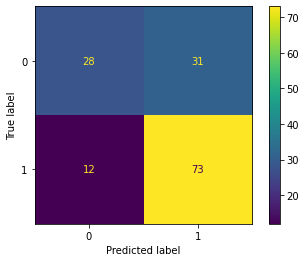

All metric scores:
 -  Accuracy :  0.7013888888888888
 -  Precision :  0.7019230769230769
 -  Recall :  0.8588235294117647
 -  F1 score :  0.7724867724867726
 -  F2 score :  0.822072072072072
 -  ROC AUC :  0.6666999002991026

- KNN Test
Confusion matrix:


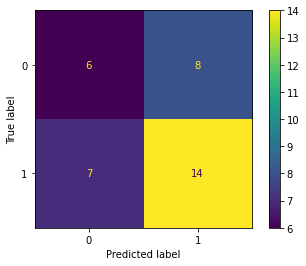

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.6363636363636364
 -  Recall :  0.6666666666666666
 -  F1 score :  0.6511627906976744
 -  F2 score :  0.660377358490566
 -  ROC AUC :  0.5476190476190477

-------------------------
- NB Train
Confusion matrix:


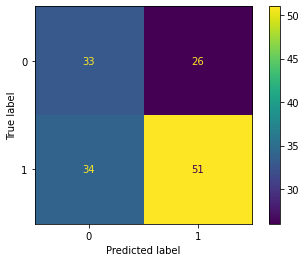

All metric scores:
 -  Accuracy :  0.5833333333333334
 -  Precision :  0.6623376623376623
 -  Recall :  0.6
 -  F1 score :  0.6296296296296295
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5796610169491526

- NB Test
Confusion matrix:


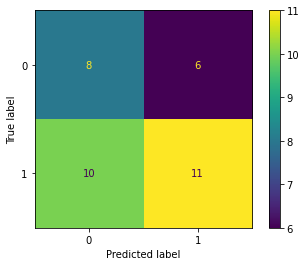

All metric scores:
 -  Accuracy :  0.5428571428571428
 -  Precision :  0.6470588235294118
 -  Recall :  0.5238095238095238
 -  F1 score :  0.5789473684210527
 -  F2 score :  0.5445544554455446
 -  ROC AUC :  0.5476190476190476

-------------------------
- LR Train
Confusion matrix:


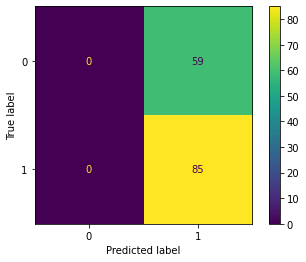

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


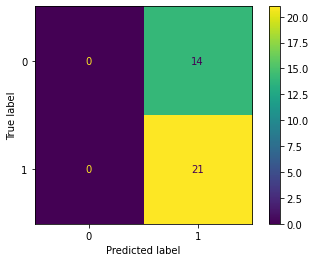

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


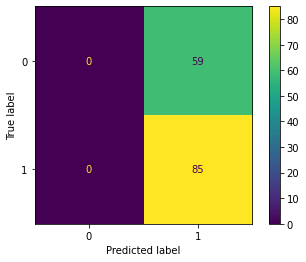

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


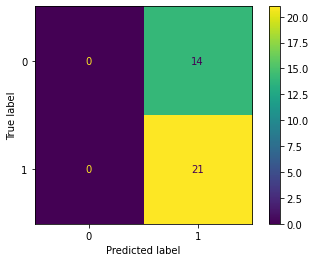

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


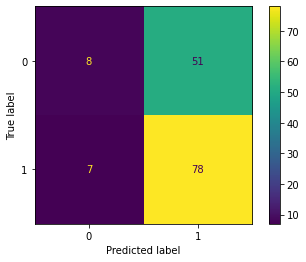

All metric scores:
 -  Accuracy :  0.5972222222222222
 -  Precision :  0.6046511627906976
 -  Recall :  0.9176470588235294
 -  F1 score :  0.7289719626168223
 -  F2 score :  0.8315565031982943
 -  ROC AUC :  0.5266201395812562

- MLP Test
Confusion matrix:


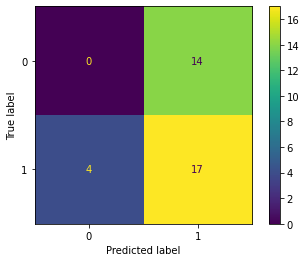

All metric scores:
 -  Accuracy :  0.4857142857142857
 -  Precision :  0.5483870967741935
 -  Recall :  0.8095238095238095
 -  F1 score :  0.6538461538461537
 -  F2 score :  0.7391304347826086
 -  ROC AUC :  0.40476190476190477

-------------------------
- RF-2 Train
Confusion matrix:


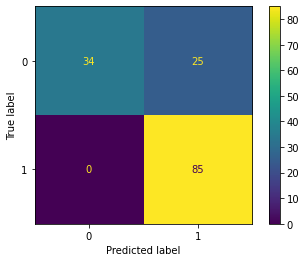

All metric scores:
 -  Accuracy :  0.8263888888888888
 -  Precision :  0.7727272727272727
 -  Recall :  1.0
 -  F1 score :  0.8717948717948718
 -  F2 score :  0.9444444444444444
 -  ROC AUC :  0.788135593220339

- RF-2 Test
Confusion matrix:


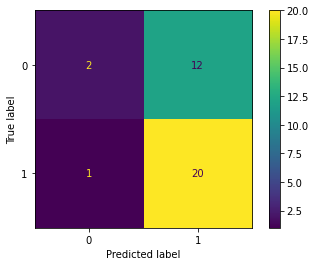

All metric scores:
 -  Accuracy :  0.6285714285714286
 -  Precision :  0.625
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7547169811320755
 -  F2 score :  0.8620689655172412
 -  ROC AUC :  0.5476190476190477

-------------------------
- XGB-4 Train
Confusion matrix:


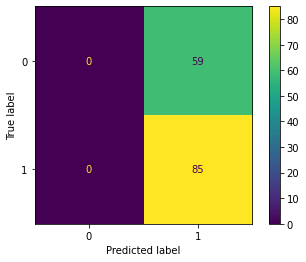

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


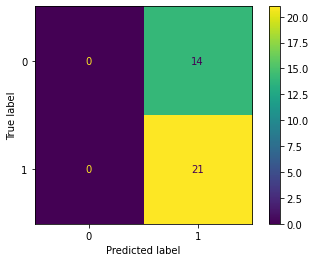

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


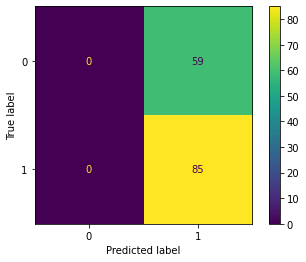

All metric scores:
 -  Accuracy :  0.5902777777777778
 -  Precision :  0.5902777777777778
 -  Recall :  1.0
 -  F1 score :  0.7423580786026202
 -  F2 score :  0.878099173553719
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


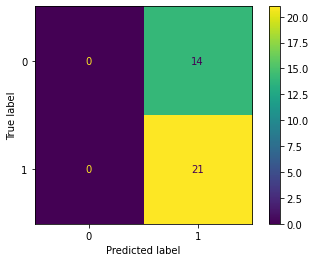

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.6
 -  Recall :  1.0
 -  F1 score :  0.7499999999999999
 -  F2 score :  0.8823529411764706
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:24:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


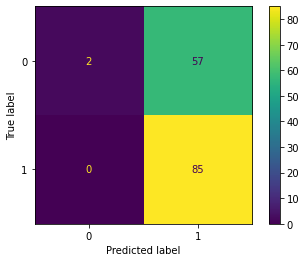

All metric scores:
 -  Accuracy :  0.6041666666666666
 -  Precision :  0.5985915492957746
 -  Recall :  1.0
 -  F1 score :  0.748898678414097
 -  F2 score :  0.8817427385892116
 -  ROC AUC :  0.5169491525423728
Validation Set: 
Confusion matrix:


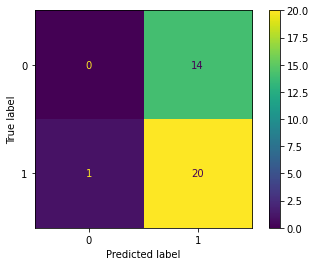

All metric scores:
 -  Accuracy :  0.5714285714285714
 -  Precision :  0.5882352941176471
 -  Recall :  0.9523809523809523
 -  F1 score :  0.7272727272727274
 -  F2 score :  0.8474576271186443
 -  ROC AUC :  0.47619047619047616


In [42]:
model_1_prediction_train = []
model_1_prediction_validation = []
view_scores = True

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    X_train_CV = X_train.iloc[train_index]
    X_val_CV = X_train.iloc[test_index]
    
    print(X_train_CV.shape)
    print(X_val_CV.shape)

    y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
    y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])
    
    est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]
    
    est_gs.pop(5)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(7)
    
    print("\n---------------------------------------------------")
    
    print("\n---Fold Summary---")
    
    for (key, estimator) in est_gs:
        estimator.fit(X_train_CV, y_train_CV)
        
        if(view_scores):
            print("-", key, "Train")

            all_scores(y_train_CV,
                       estimator.predict(X_train_CV),
                       to_print = True)

            print("\n-", key, "Test")
            all_scores(y_true = y_val_CV,
                       y_pred = estimator.predict(X_val_CV),
                       to_print = True)
            
            print("\n-------------------------")
    

    #soft voting
    
    print("\n -- Grid Search estimators -- ")
    
    print("- Soft Voting: ")

    voting = VotingClassifier(estimators=est_gs, 
                                   voting='soft', 
                                   n_jobs=-1,
                                   verbose=False)

    voting.fit(X_train_CV, y_train_CV)

    print("Training Set: ")
    all_scores(y_true = y_train_CV,
               y_pred = voting.predict(X_train_CV),
               to_print = True)
    
    print("Validation Set: ")
    all_scores(y_true = y_val_CV,
               y_pred = voting.predict(X_val_CV),
               to_print = True)

  
    model_1_prediction_train.append(voting.predict(X_train_CV))
    model_1_prediction_validation.append(voting.predict(X_val_CV))

In [43]:
t = [print("\nFold ", i, ": \n", pd.Series(model_1_prediction_train[i]).value_counts()) for i in range(K)]


Fold  0 : 
 1    138
0      5
Name: count, dtype: int64

Fold  1 : 
 1    114
0     29
Name: count, dtype: int64

Fold  2 : 
 1    143
Name: count, dtype: int64

Fold  3 : 
 1    108
0     35
Name: count, dtype: int64

Fold  4 : 
 1    142
0      2
Name: count, dtype: int64


In [44]:
t = [print("\nFold ", i, ": \n", pd.Series(model_1_prediction_validation[i]).value_counts()) for i in range(K)]


Fold  0 : 
 1    35
0     1
Name: count, dtype: int64

Fold  1 : 
 1    30
0     6
Name: count, dtype: int64

Fold  2 : 
 1    36
Name: count, dtype: int64

Fold  3 : 
 1    33
0     3
Name: count, dtype: int64

Fold  4 : 
 1    34
0     1
Name: count, dtype: int64


### MODELO 2: ASD ou NAO-TD

In [45]:
# gs_results_dict_m2={
#     'KNN':[], 
#     'NB':[], 
#     'LR':[], 
#     'SVM':[],
#     'MLP':[],
#     'RF-1':[], 
#     'RF-2':[],  
#     'XGB-1':[], 
#     'XGB-2':[], 
#     'XGB-3':[], 
#     'XGB-4':[],
#     'LGBM-1':[],
#     'LGBM-2':[]
# }

# pipeline_dict_m2 = copy.deepcopy(pipeline_dict)

# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     print("\nFOLD: " + str(i))

#     X_train_CV = X_train.iloc[train_index]
#     X_val_CV = X_train.iloc[test_index]

#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_TD(pd.Series(y_train).iloc[train_index])
#     y_val_CV = is_TD(pd.Series(y_train).iloc[test_index])
    
#     ## GRID SEARCHES FOR BEST PARAMETERS

#     inner_kfold_cv = StratifiedKFold(n_splits=3, random_state=4, shuffle=True)
    
#     for j, (inner_train_index, inner_test_index) in enumerate(inner_kfold_cv.split(X_train_CV, pd.Series(y_train).iloc[train_index])):
#         print("INNER FOLD: " + str(j))
#         print(X_train_CV.iloc[inner_train_index].shape)
#         print(X_train_CV.iloc[inner_test_index].shape)
        
    
#     for key in pipeline_dict_m2.keys():
#         gs = grid_search_cv_fit_and_print(X = X_train_CV,
#                                           y = y_train_CV,
#                                           estimator = pipeline_dict_m2[key],
#                                           param_grid = param_dict[key],
#                                           scoring = f2,
#                                           cv = inner_kfold_cv.split(X_train_CV,
#                                                                     pd.Series(y_train).iloc[train_index]),
#                                           printing_name = key)
        
#         gs_results_dict_m2[key].append(gs)
        
#         if(key == "RF-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m2[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])
            
#         if(key == "XGB-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m2[key].set_params(
#                 classifier__n_estimators=gs.best_params_['classifier__n_estimators'],
#                 classifier__max_depth=gs.best_params_['classifier__max_depth'])

#         if(key == "XGB-2"):
#             pipeline_dict_m1[key] = pipeline_dict_m2[key].set_params(
#                 classifier__min_child_weight=gs.best_params_['classifier__min_child_weight'],
#                 classifier__gamma=gs.best_params_['classifier__gamma'])

#         if(key == "XGB-3"):
#             pipeline_dict_m1[key] = pipeline_dict_m2[key].set_params(
#                 classifier__subsample=gs.best_params_['classifier__subsample'],
#                 classifier__colsample_bytree=gs.best_params_['classifier__colsample_bytree'])
            
#         if(key == "LGBM-1"):
#             pipeline_dict_m1[key] = pipeline_dict_m2[key].set_params(
#                 classifier__boosting_type=gs.best_params_['classifier__boosting_type'],
#                 classifier__feature_fraction=gs.best_params_['classifier__feature_fraction'])
    


FOLD: 0
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 84
Number Tipical Development: 59
Number Non-Tipical Development: 22
Number Tipical Development: 14
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.6435019841269841
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Fitting 3 folds for each of 101 candidates, totalling 303 fits
NB
   Best score:  0.5370660623800082
   Best params:  {'classifier__var_smoothing': 0.0}
Fitting 3 folds for each of 200 candidates, totalling 600 fits


/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8223041223041223
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8247884247884247
   Best params:  {'classifier__C': 0.4832930238571752, 'classifier__coef0': 1, 'classifier__kernel': 'sigmoid', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.710583297821274
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.7607728662774534
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 220}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8223041223041223
   Best params:  {'classifier__criterion': 'gini', 'classif

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:48:29] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:50:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:50:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:50:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:50:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:50:48] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:20] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:53:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:53:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:53:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:53:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:53:32] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:34] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:55:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:55:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:55:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:55:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:55:29] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:14] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:56:57] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8223041223041223
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7162228199775709
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8223041223041223
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 1
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7297186461648709
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neigh

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8289705952382908
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8340316334797571
   Best params:  {'classifier__C': 0.11288378916846889, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7792269621044973
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8341722300377992
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 380}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8345379803299448
   Best params:  {'classifier__criterion': 'gini', 'classifie

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:58] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:15] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:37:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:37:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:37:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:37:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:37:44] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:38:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:38:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:38:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:38:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:38:56] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:56] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:47] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:41:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:41:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:41:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:41:34] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:15] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7847122563089132
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 2
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.6888070796474791
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'chebyshev', 'classifier__n_neig

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.753885260535827
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8217795913070197
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 20}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__criterion': 'gini', 'classifier__max_features'

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:18:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:18:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:18:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:18:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:19:22] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:21:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:21:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:21:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:21:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:21:42] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:23:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:23:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:23:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:23:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:23:15] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:24:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:24:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:24:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:24:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:24:29] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:25:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:25:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:25:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:25:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:25:31] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:26:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:26:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:26:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:26:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:26:25] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:11] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:27:54] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7281336322057692
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.1}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 3
(143, 5000)
(36, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 58
Number Non-Tipical Development: 21
Number Tipical Development: 15
INNER FOLD: 0
(95, 5000)
(48, 5000)
INNER FOLD: 1
(95, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(47, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7085102317603771
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neigh

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

LR
   Best score:  0.8289705952382908
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8264407092221662
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7183318901113829
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8092266847677193
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 320}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8315473309954546
   Best params:  {'classifier__criterion': 'gini', 'classifier__max_features

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:04:37] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:06:53] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:08:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:08:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:08:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:08:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:08:26] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:09:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:09:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:09:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:09:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:09:39] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:10:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:10:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:10:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:10:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:10:42] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:11:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:11:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:11:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:11:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:11:33] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:19] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:12:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:13:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:13:02] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7527945757742348
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.15}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8264407092221662
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}

FOLD: 4
(144, 5000)
(35, 5000)
Number Non-Tipical Development: 85
Number Tipical Development: 59
Number Non-Tipical Development: 21
Number Tipical Development: 14
INNER FOLD: 0
(96, 5000)
(48, 5000)
INNER FOLD: 1
(96, 5000)
(48, 5000)
INNER FOLD: 2
(96, 5000)
(48, 5000)
Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
KNN
   Best score:  0.7048987216145082
   Best params:  {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neig

/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/laura/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR
   Best score:  0.8239564067378637
   Best params:  {'classifier__C': 0.0001, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
SVM
   Best score:  0.8239564067378637
   Best params:  {'classifier__C': 0.01, 'classifier__coef0': 1, 'classifier__kernel': 'poly', 'classifier__shrinking': True}
Fitting 3 folds for each of 405 candidates, totalling 1215 fits
MLP
   Best score:  0.7628677533635556
   Best params:  {'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (100, 100, 100), 'classifier__learning_rate': 'invscaling', 'classifier__solver': 'sgd'}
Fitting 3 folds for each of 252 candidates, totalling 756 fits
RF-1
   Best score:  0.8264407092221662
   Best params:  {'classifier__max_depth': 1, 'classifier__n_estimators': 180}
Fitting 3 folds for each of 140 candidates, totalling 420 fits
RF-2
   Best score:  0.8289705952382906
   Best params:  {'classifier__criterion': 'gini', 'classifier__max_featu

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:49:56] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:52:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:52:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:52:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:52:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:52:13] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:53:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:53:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:53:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:53:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:53:43] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:54:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:54:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:54:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:54:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:54:56] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:55:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:55:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:55:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:55:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:55:59] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:56:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:56:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:56:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:56:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:56:53] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:57:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:57:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:57:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:57:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:57:38] WARNING: /workspace/src/learner

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:58:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:58:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:58:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:58:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:58:22] WARNING: /workspace/src/learner

XGB-4
   Best score:  0.8239564067378637
   Best params:  {'classifier__learning_rate': 0.005, 'classifier__objective': 'binary:hinge'}
Fitting 3 folds for each of 57 candidates, totalling 171 fits
LGBM-1
   Best score:  0.7603625541125542
   Best params:  {'classifier__boosting_type': 'rf', 'classifier__feature_fraction': 0.05}
Fitting 3 folds for each of 300 candidates, totalling 900 fits
LGBM-2
   Best score:  0.8239564067378637
   Best params:  {'classifier__learning_rate': 0.0001, 'classifier__subsample': 0.05}


In [46]:
# with open('Model2_GridSearchResults_kfoldcv.pkl', 'wb') as f:
#     pickle.dump(gs_results_dict_m2, f,)

with open('Model2_GridSearchResults_kfoldcv.pkl', 'rb') as f:
    gs_results_dict_m2 = pickle.load(f)


(138, 5000)
(35, 5000)
Number ASD Development: 33
Number ASD Development: 9

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


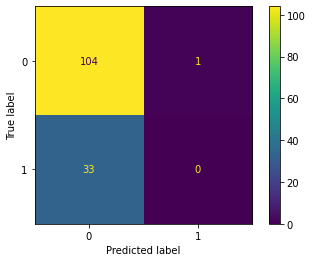

All metric scores:
 -  Accuracy :  0.7536231884057971
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.49523809523809526

- KNN Test
Confusion matrix:


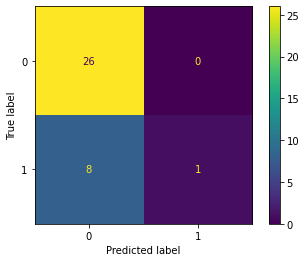

All metric scores:
 -  Accuracy :  0.7714285714285715
 -  Precision :  1.0
 -  Recall :  0.1111111111111111
 -  F1 score :  0.19999999999999998
 -  F2 score :  0.13513513513513514
 -  ROC AUC :  0.5555555555555556

-------------------------
- NB Train
Confusion matrix:


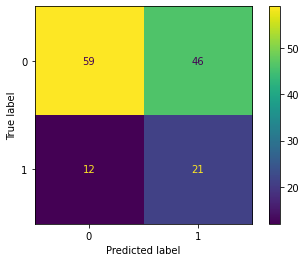

All metric scores:
 -  Accuracy :  0.5797101449275363
 -  Precision :  0.31343283582089554
 -  Recall :  0.6363636363636364
 -  F1 score :  0.42000000000000004
 -  F2 score :  0.5276381909547739
 -  ROC AUC :  0.5991341991341992

- NB Test
Confusion matrix:


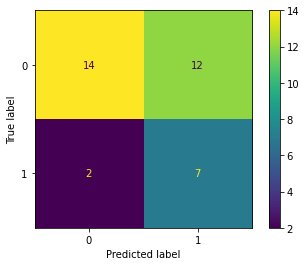

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.3684210526315789
 -  Recall :  0.7777777777777778
 -  F1 score :  0.5
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.6581196581196581

-------------------------
- LR Train
Confusion matrix:


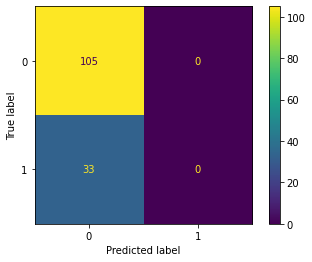

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


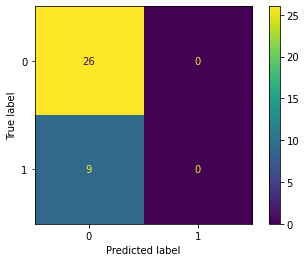

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


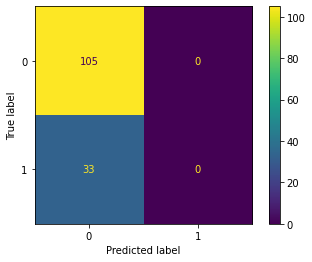

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


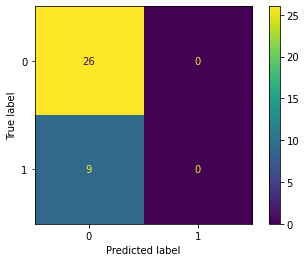

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


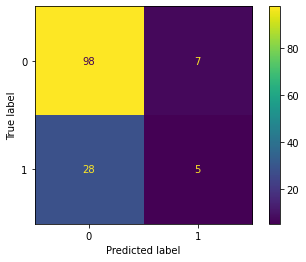

All metric scores:
 -  Accuracy :  0.7463768115942029
 -  Precision :  0.4166666666666667
 -  Recall :  0.15151515151515152
 -  F1 score :  0.2222222222222222
 -  F2 score :  0.1736111111111111
 -  ROC AUC :  0.5424242424242425

- MLP Test
Confusion matrix:


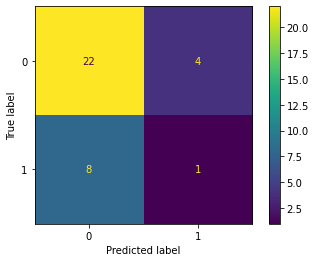

All metric scores:
 -  Accuracy :  0.6571428571428571
 -  Precision :  0.2
 -  Recall :  0.1111111111111111
 -  F1 score :  0.14285714285714285
 -  F2 score :  0.1219512195121951
 -  ROC AUC :  0.47863247863247865

-------------------------
- RF-2 Train
Confusion matrix:


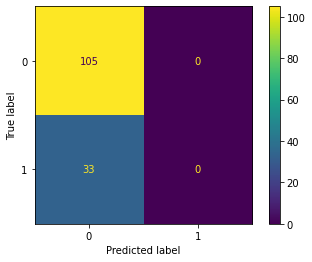

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


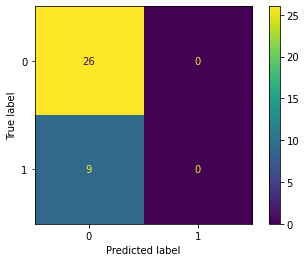

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


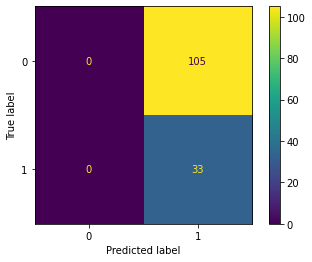

All metric scores:
 -  Accuracy :  0.2391304347826087
 -  Precision :  0.2391304347826087
 -  Recall :  1.0
 -  F1 score :  0.3859649122807018
 -  F2 score :  0.611111111111111
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


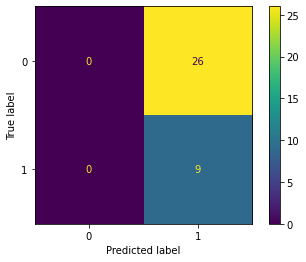

All metric scores:
 -  Accuracy :  0.2571428571428571
 -  Precision :  0.2571428571428571
 -  Recall :  1.0
 -  F1 score :  0.40909090909090906
 -  F2 score :  0.6338028169014084
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


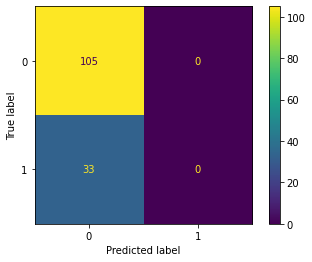

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


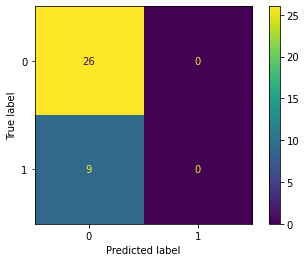

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


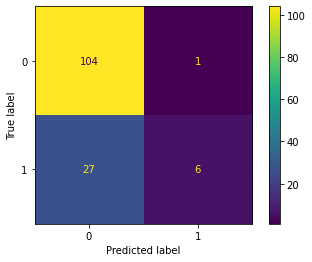

All metric scores:
 -  Accuracy :  0.7971014492753623
 -  Precision :  0.8571428571428571
 -  Recall :  0.18181818181818182
 -  F1 score :  0.30000000000000004
 -  F2 score :  0.21582733812949642
 -  ROC AUC :  0.5861471861471862

- KNN(original) Test
Confusion matrix:


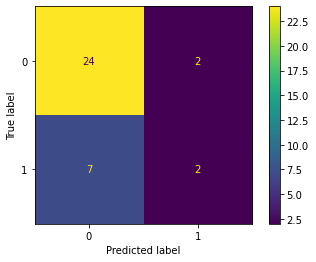

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.5
 -  Recall :  0.2222222222222222
 -  F1 score :  0.30769230769230765
 -  F2 score :  0.25
 -  ROC AUC :  0.5726495726495727

-------------------------
- NB(original) Train
Confusion matrix:


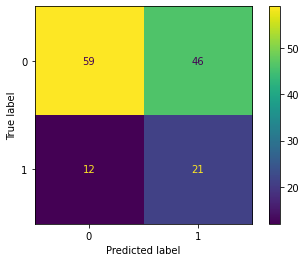

All metric scores:
 -  Accuracy :  0.5797101449275363
 -  Precision :  0.31343283582089554
 -  Recall :  0.6363636363636364
 -  F1 score :  0.42000000000000004
 -  F2 score :  0.5276381909547739
 -  ROC AUC :  0.5991341991341992

- NB(original) Test
Confusion matrix:


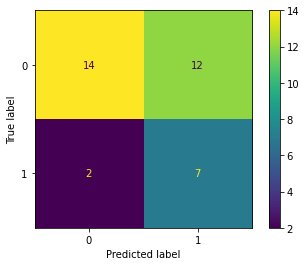

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.3684210526315789
 -  Recall :  0.7777777777777778
 -  F1 score :  0.5
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.6581196581196581

-------------------------
- LR(original) Train
Confusion matrix:


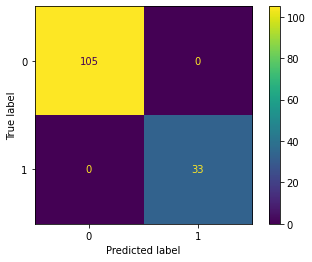

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


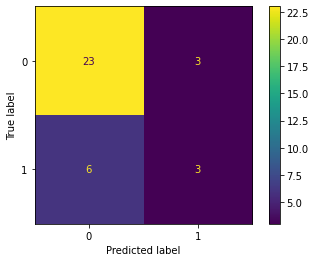

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.5
 -  Recall :  0.3333333333333333
 -  F1 score :  0.4
 -  F2 score :  0.3571428571428571
 -  ROC AUC :  0.6089743589743589

-------------------------
- SVM(original) Train
Confusion matrix:


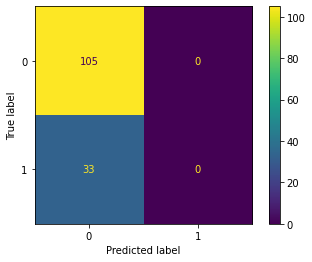

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM(original) Test
Confusion matrix:


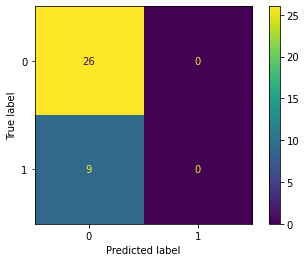

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


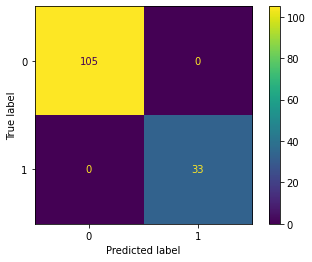

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


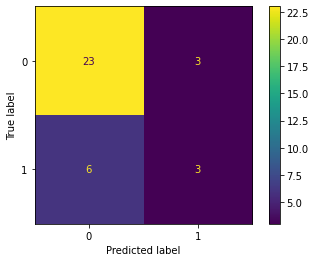

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.5
 -  Recall :  0.3333333333333333
 -  F1 score :  0.4
 -  F2 score :  0.3571428571428571
 -  ROC AUC :  0.6089743589743589

-------------------------
- RF(original) Train
Confusion matrix:


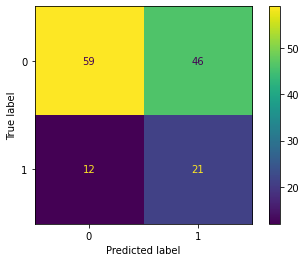

All metric scores:
 -  Accuracy :  0.5797101449275363
 -  Precision :  0.31343283582089554
 -  Recall :  0.6363636363636364
 -  F1 score :  0.42000000000000004
 -  F2 score :  0.5276381909547739
 -  ROC AUC :  0.5991341991341992

- RF(original) Test
Confusion matrix:


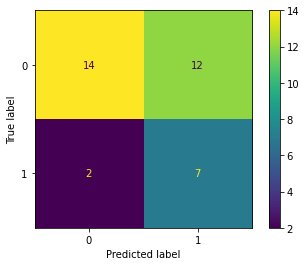

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.3684210526315789
 -  Recall :  0.7777777777777778
 -  F1 score :  0.5
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.6581196581196581

-------------------------
- XGB(original) Train
Confusion matrix:


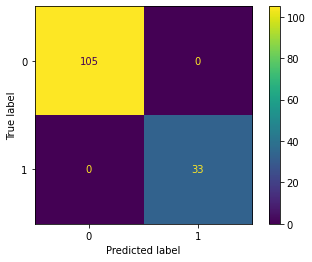

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


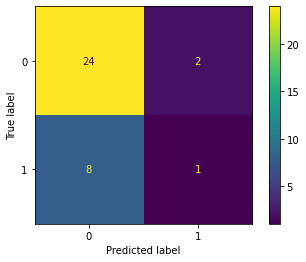

All metric scores:
 -  Accuracy :  0.7142857142857143
 -  Precision :  0.3333333333333333
 -  Recall :  0.1111111111111111
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.1282051282051282
 -  ROC AUC :  0.5170940170940171
[LightGBM] [Info] Number of positive: 33, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238287
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239130 -> initscore=-1.157453
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

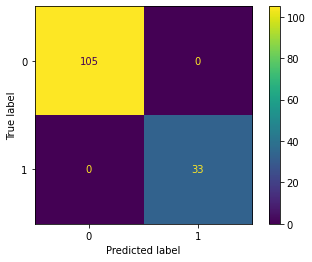

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


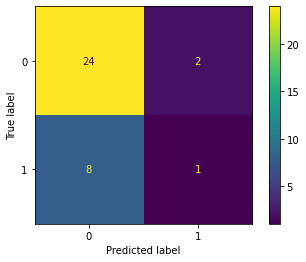

All metric scores:
 -  Accuracy :  0.7142857142857143
 -  Precision :  0.3333333333333333
 -  Recall :  0.1111111111111111
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.1282051282051282
 -  ROC AUC :  0.5170940170940171
KNN(original)
NB(original)
LR(original)
SVM(original)
MLP(original)
RF(original)
XGB-4
LGBM(original)

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:14:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


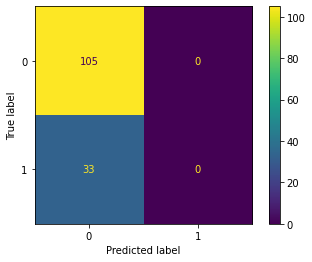

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


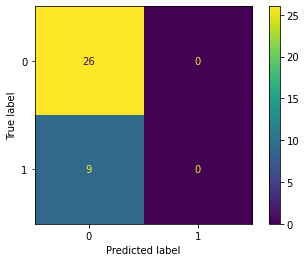

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:14:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


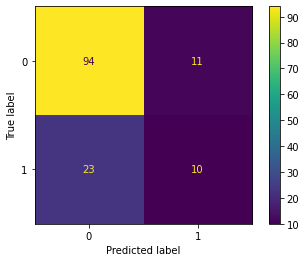

All metric scores:
 -  Accuracy :  0.7536231884057971
 -  Precision :  0.47619047619047616
 -  Recall :  0.30303030303030304
 -  F1 score :  0.37037037037037035
 -  F2 score :  0.32679738562091504
 -  ROC AUC :  0.5991341991341992
Validation Set: 
Confusion matrix:


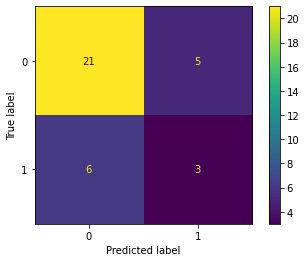

All metric scores:
 -  Accuracy :  0.6857142857142857
 -  Precision :  0.375
 -  Recall :  0.3333333333333333
 -  F1 score :  0.35294117647058826
 -  F2 score :  0.34090909090909094
 -  ROC AUC :  0.5705128205128205

 -- Untuned estimators -- 
- Hard Voting: 
Training Set: 
Confusion matrix:


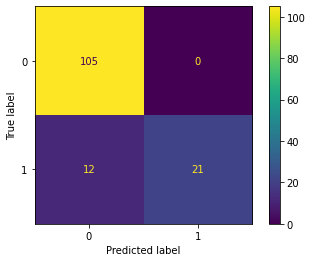

All metric scores:
 -  Accuracy :  0.9130434782608695
 -  Precision :  1.0
 -  Recall :  0.6363636363636364
 -  F1 score :  0.7777777777777778
 -  F2 score :  0.6862745098039215
 -  ROC AUC :  0.8181818181818181
Validation Set: 
Confusion matrix:


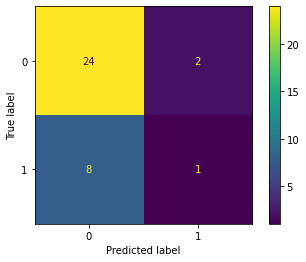

All metric scores:
 -  Accuracy :  0.7142857142857143
 -  Precision :  0.3333333333333333
 -  Recall :  0.1111111111111111
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.1282051282051282
 -  ROC AUC :  0.5170940170940171
- Soft Voting: 
Training Set: 
Confusion matrix:


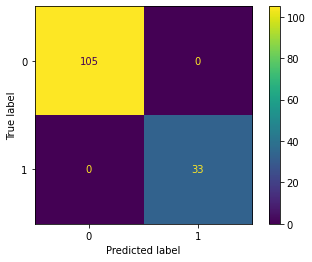

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


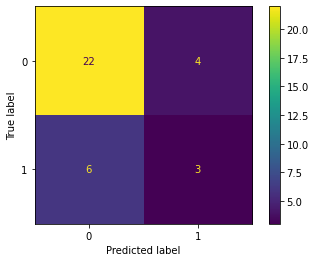

All metric scores:
 -  Accuracy :  0.7142857142857143
 -  Precision :  0.42857142857142855
 -  Recall :  0.3333333333333333
 -  F1 score :  0.375
 -  F2 score :  0.3488372093023256
 -  ROC AUC :  0.5897435897435898

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:14:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


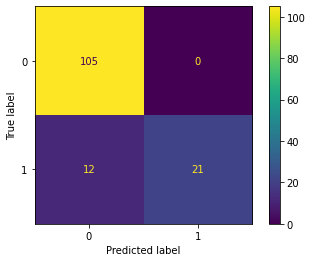

All metric scores:
 -  Accuracy :  0.9130434782608695
 -  Precision :  1.0
 -  Recall :  0.6363636363636364
 -  F1 score :  0.7777777777777778
 -  F2 score :  0.6862745098039215
 -  ROC AUC :  0.8181818181818181
Validation Set: 
Confusion matrix:


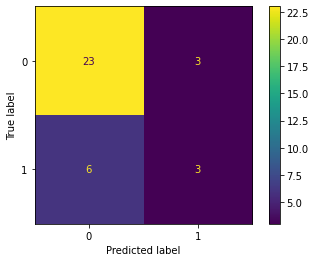

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.5
 -  Recall :  0.3333333333333333
 -  F1 score :  0.4
 -  F2 score :  0.3571428571428571
 -  ROC AUC :  0.6089743589743589
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:15:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


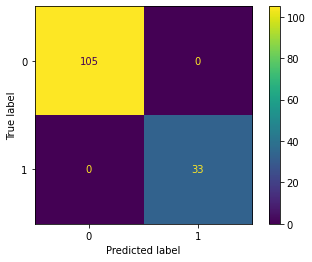

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


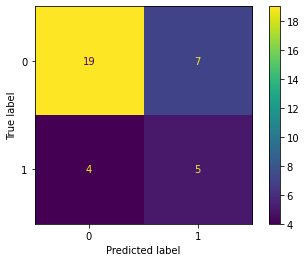

All metric scores:
 -  Accuracy :  0.6857142857142857
 -  Precision :  0.4166666666666667
 -  Recall :  0.5555555555555556
 -  F1 score :  0.4761904761904762
 -  F2 score :  0.5208333333333334
 -  ROC AUC :  0.6431623931623932
Best voting:  MIX_SoftVoting
Scores:  Confusion matrix    [[19, 7], [4, 5]]
Accuracy                     0.685714
Precision                    0.416667
Recall                       0.555556
F1 score                      0.47619
F2 score                     0.520833
ROC AUC                      0.643162
dtype: object

---------------------------------------------------
(114, 5000)
(30, 5000)
Number ASD Development: 33
Number ASD Development: 6

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


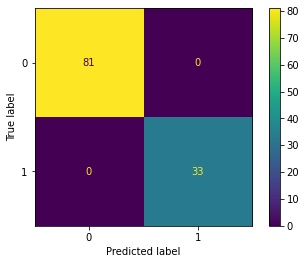

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


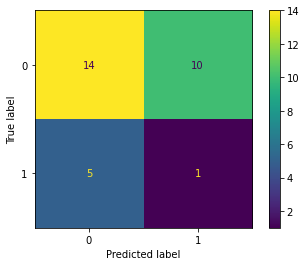

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.09090909090909091
 -  Recall :  0.16666666666666666
 -  F1 score :  0.11764705882352942
 -  F2 score :  0.14285714285714288
 -  ROC AUC :  0.37499999999999994

-------------------------
- NB Train
Confusion matrix:


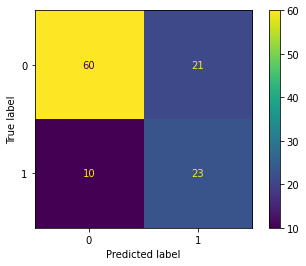

All metric scores:
 -  Accuracy :  0.7280701754385965
 -  Precision :  0.5227272727272727
 -  Recall :  0.696969696969697
 -  F1 score :  0.5974025974025974
 -  F2 score :  0.6534090909090908
 -  ROC AUC :  0.7188552188552189

- NB Test
Confusion matrix:


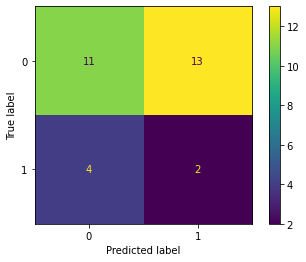

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

-------------------------
- LR Train
Confusion matrix:


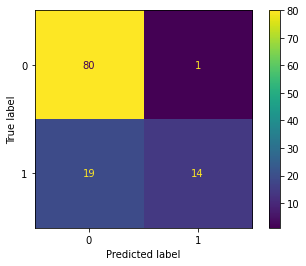

All metric scores:
 -  Accuracy :  0.8245614035087719
 -  Precision :  0.9333333333333333
 -  Recall :  0.42424242424242425
 -  F1 score :  0.5833333333333333
 -  F2 score :  0.4761904761904763
 -  ROC AUC :  0.7059483726150393

- LR Test
Confusion matrix:


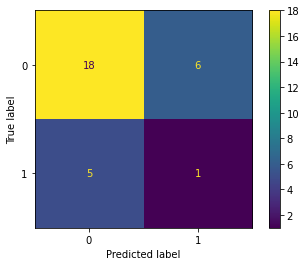

All metric scores:
 -  Accuracy :  0.6333333333333333
 -  Precision :  0.14285714285714285
 -  Recall :  0.16666666666666666
 -  F1 score :  0.15384615384615383
 -  F2 score :  0.16129032258064516
 -  ROC AUC :  0.4583333333333333

-------------------------
- SVM Train
Confusion matrix:


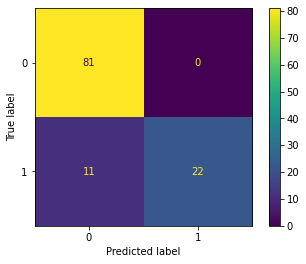

All metric scores:
 -  Accuracy :  0.9035087719298246
 -  Precision :  1.0
 -  Recall :  0.6666666666666666
 -  F1 score :  0.8
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.8333333333333333

- SVM Test
Confusion matrix:


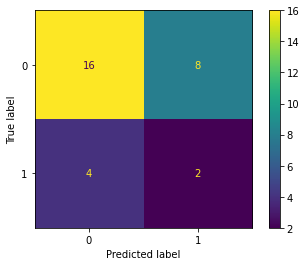

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.2
 -  Recall :  0.3333333333333333
 -  F1 score :  0.25
 -  F2 score :  0.29411764705882354
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


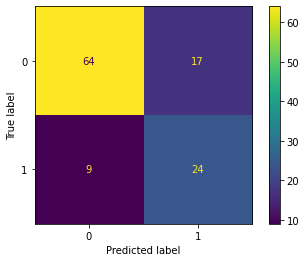

All metric scores:
 -  Accuracy :  0.7719298245614035
 -  Precision :  0.5853658536585366
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6486486486486487
 -  F2 score :  0.6936416184971098
 -  ROC AUC :  0.7586980920314254

- MLP Test
Confusion matrix:


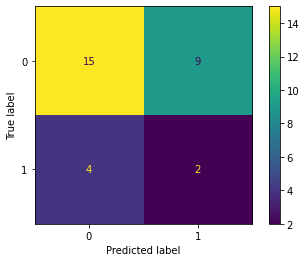

All metric scores:
 -  Accuracy :  0.5666666666666667
 -  Precision :  0.18181818181818182
 -  Recall :  0.3333333333333333
 -  F1 score :  0.23529411764705885
 -  F2 score :  0.28571428571428575
 -  ROC AUC :  0.47916666666666663

-------------------------
- RF-2 Train
Confusion matrix:


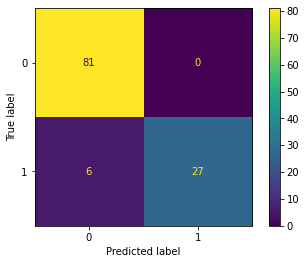

All metric scores:
 -  Accuracy :  0.9473684210526315
 -  Precision :  1.0
 -  Recall :  0.8181818181818182
 -  F1 score :  0.9
 -  F2 score :  0.8490566037735848
 -  ROC AUC :  0.9090909090909092

- RF-2 Test
Confusion matrix:


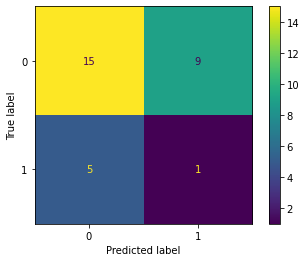

All metric scores:
 -  Accuracy :  0.5333333333333333
 -  Precision :  0.1
 -  Recall :  0.16666666666666666
 -  F1 score :  0.125
 -  F2 score :  0.14705882352941177
 -  ROC AUC :  0.39583333333333337

-------------------------
- XGB-4 Train
Confusion matrix:


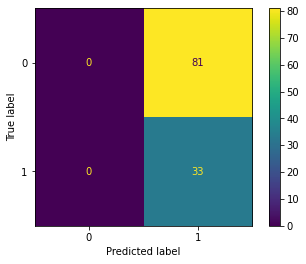

All metric scores:
 -  Accuracy :  0.2894736842105263
 -  Precision :  0.2894736842105263
 -  Recall :  1.0
 -  F1 score :  0.4489795918367347
 -  F2 score :  0.6707317073170732
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


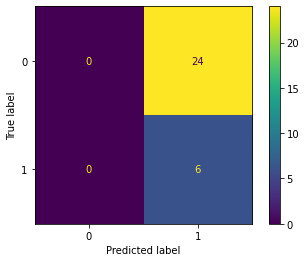

All metric scores:
 -  Accuracy :  0.2
 -  Precision :  0.2
 -  Recall :  1.0
 -  F1 score :  0.33333333333333337
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


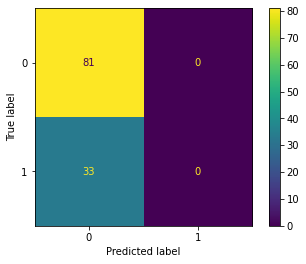

All metric scores:
 -  Accuracy :  0.7105263157894737
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


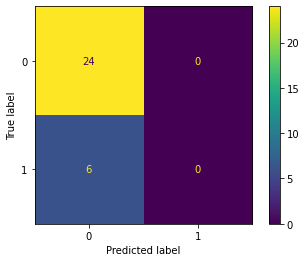

All metric scores:
 -  Accuracy :  0.8
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


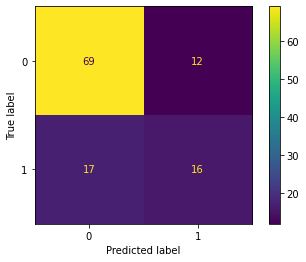

All metric scores:
 -  Accuracy :  0.7456140350877193
 -  Precision :  0.5714285714285714
 -  Recall :  0.48484848484848486
 -  F1 score :  0.5245901639344263
 -  F2 score :  0.5
 -  ROC AUC :  0.6683501683501684

- KNN(original) Test
Confusion matrix:


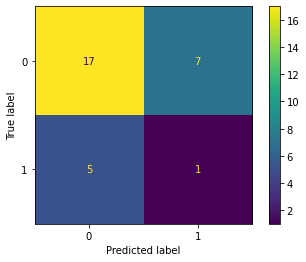

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.125
 -  Recall :  0.16666666666666666
 -  F1 score :  0.14285714285714288
 -  F2 score :  0.15625
 -  ROC AUC :  0.4375

-------------------------
- NB(original) Train
Confusion matrix:


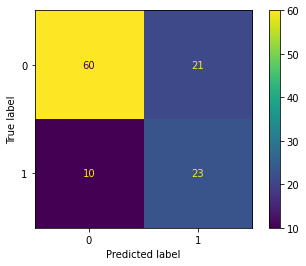

All metric scores:
 -  Accuracy :  0.7280701754385965
 -  Precision :  0.5227272727272727
 -  Recall :  0.696969696969697
 -  F1 score :  0.5974025974025974
 -  F2 score :  0.6534090909090908
 -  ROC AUC :  0.7188552188552189

- NB(original) Test
Confusion matrix:


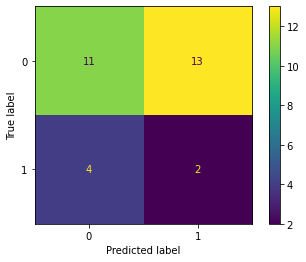

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

-------------------------
- LR(original) Train
Confusion matrix:


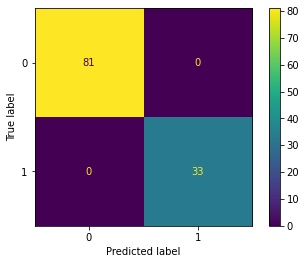

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


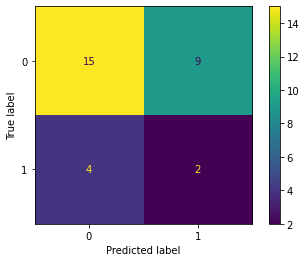

All metric scores:
 -  Accuracy :  0.5666666666666667
 -  Precision :  0.18181818181818182
 -  Recall :  0.3333333333333333
 -  F1 score :  0.23529411764705885
 -  F2 score :  0.28571428571428575
 -  ROC AUC :  0.47916666666666663

-------------------------
- SVM(original) Train
Confusion matrix:


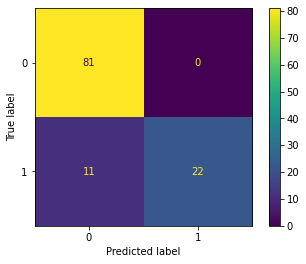

All metric scores:
 -  Accuracy :  0.9035087719298246
 -  Precision :  1.0
 -  Recall :  0.6666666666666666
 -  F1 score :  0.8
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.8333333333333333

- SVM(original) Test
Confusion matrix:


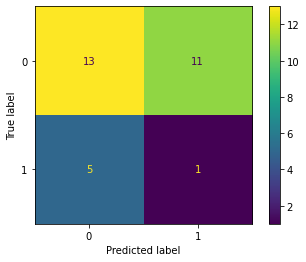

All metric scores:
 -  Accuracy :  0.4666666666666667
 -  Precision :  0.08333333333333333
 -  Recall :  0.16666666666666666
 -  F1 score :  0.1111111111111111
 -  F2 score :  0.13888888888888887
 -  ROC AUC :  0.3541666666666667

-------------------------
- MLP(original) Train
Confusion matrix:


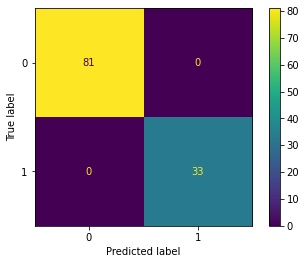

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


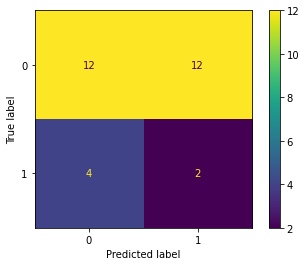

All metric scores:
 -  Accuracy :  0.4666666666666667
 -  Precision :  0.14285714285714285
 -  Recall :  0.3333333333333333
 -  F1 score :  0.2
 -  F2 score :  0.2631578947368421
 -  ROC AUC :  0.41666666666666663

-------------------------
- RF(original) Train
Confusion matrix:


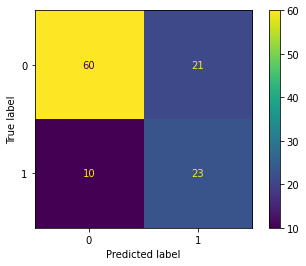

All metric scores:
 -  Accuracy :  0.7280701754385965
 -  Precision :  0.5227272727272727
 -  Recall :  0.696969696969697
 -  F1 score :  0.5974025974025974
 -  F2 score :  0.6534090909090908
 -  ROC AUC :  0.7188552188552189

- RF(original) Test
Confusion matrix:


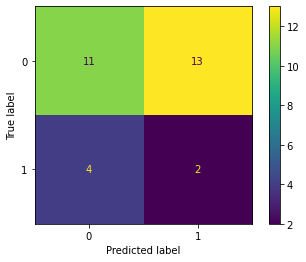

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

-------------------------
- XGB(original) Train
Confusion matrix:


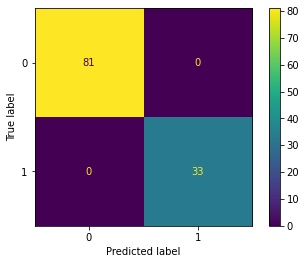

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


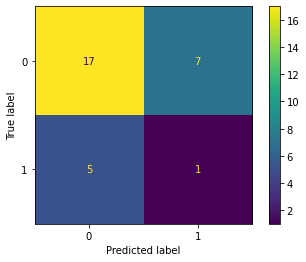

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.125
 -  Recall :  0.16666666666666666
 -  F1 score :  0.14285714285714288
 -  F2 score :  0.15625
 -  ROC AUC :  0.4375
[LightGBM] [Info] Number of positive: 33, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198290
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289474 -> initscore=-0.897942
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Confusion matrix:


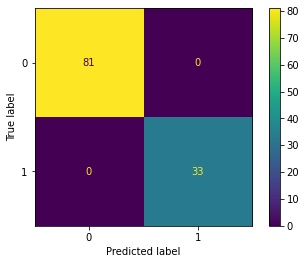

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


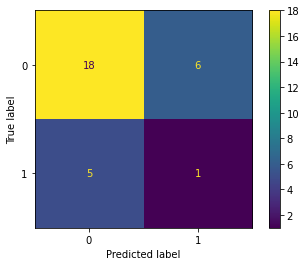

All metric scores:
 -  Accuracy :  0.6333333333333333
 -  Precision :  0.14285714285714285
 -  Recall :  0.16666666666666666
 -  F1 score :  0.15384615384615383
 -  F2 score :  0.16129032258064516
 -  ROC AUC :  0.4583333333333333
KNN(original)
NB(original)
LR(original)
SVM
MLP
RF(original)
XGB-4
LGBM(original)

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:15:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


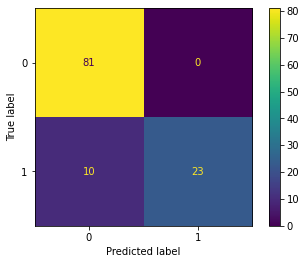

All metric scores:
 -  Accuracy :  0.9122807017543859
 -  Precision :  1.0
 -  Recall :  0.696969696969697
 -  F1 score :  0.8214285714285715
 -  F2 score :  0.7419354838709677
 -  ROC AUC :  0.8484848484848485
Validation Set: 
Confusion matrix:


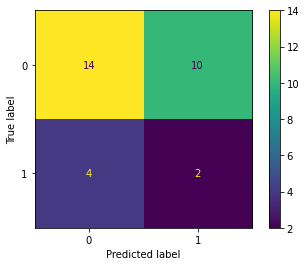

All metric scores:
 -  Accuracy :  0.5333333333333333
 -  Precision :  0.16666666666666666
 -  Recall :  0.3333333333333333
 -  F1 score :  0.2222222222222222
 -  F2 score :  0.27777777777777773
 -  ROC AUC :  0.45833333333333326
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:16:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


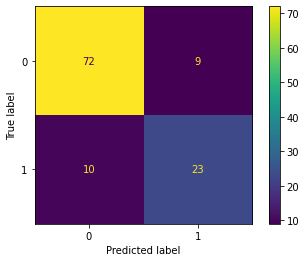

All metric scores:
 -  Accuracy :  0.8333333333333334
 -  Precision :  0.71875
 -  Recall :  0.696969696969697
 -  F1 score :  0.7076923076923077
 -  F2 score :  0.7012195121951219
 -  ROC AUC :  0.7929292929292929
Validation Set: 
Confusion matrix:


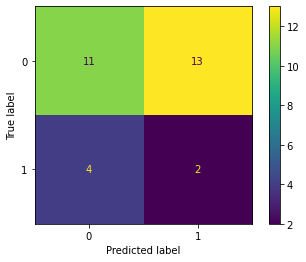

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of positive: 33, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238287
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239130 -> initscore=-1.157453
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

Training Set: 
Confusion matrix:


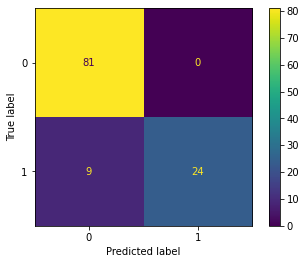

All metric scores:
 -  Accuracy :  0.9210526315789473
 -  Precision :  1.0
 -  Recall :  0.7272727272727273
 -  F1 score :  0.8421052631578948
 -  F2 score :  0.7692307692307693
 -  ROC AUC :  0.8636363636363636
Validation Set: 
Confusion matrix:


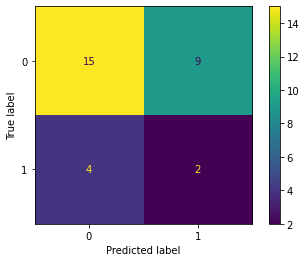

All metric scores:
 -  Accuracy :  0.5666666666666667
 -  Precision :  0.18181818181818182
 -  Recall :  0.3333333333333333
 -  F1 score :  0.23529411764705885
 -  F2 score :  0.28571428571428575
 -  ROC AUC :  0.47916666666666663
- Soft Voting: 
[LightGBM] [Info] Number of positive: 33, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238287
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239130 -> initscore=-1.157453
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

Training Set: 
Confusion matrix:


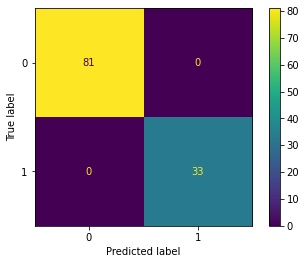

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


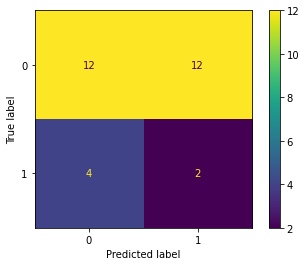

All metric scores:
 -  Accuracy :  0.4666666666666667
 -  Precision :  0.14285714285714285
 -  Recall :  0.3333333333333333
 -  F1 score :  0.2
 -  F2 score :  0.2631578947368421
 -  ROC AUC :  0.41666666666666663

 -- Mixed estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:16:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


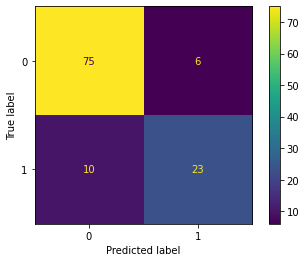

All metric scores:
 -  Accuracy :  0.8596491228070176
 -  Precision :  0.7931034482758621
 -  Recall :  0.696969696969697
 -  F1 score :  0.7419354838709677
 -  F2 score :  0.7142857142857143
 -  ROC AUC :  0.8114478114478114
Validation Set: 
Confusion matrix:


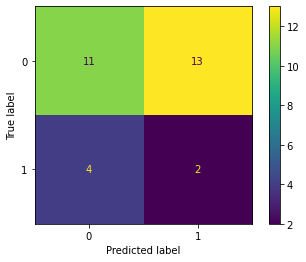

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337
- Soft Voting: 
[LightGBM] [Info] Number of positive: 33, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238287
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239130 -> initscore=-1.157453
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:16:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


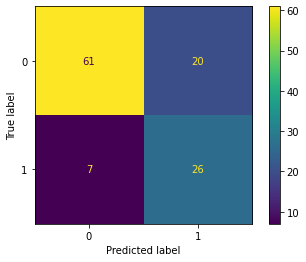

All metric scores:
 -  Accuracy :  0.7631578947368421
 -  Precision :  0.5652173913043478
 -  Recall :  0.7878787878787878
 -  F1 score :  0.6582278481012658
 -  F2 score :  0.7303370786516853
 -  ROC AUC :  0.7704826038159371
Validation Set: 
Confusion matrix:


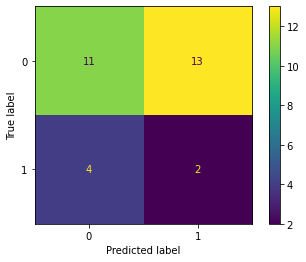

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337
Best voting:  OG_HardVoting
Scores:  Confusion matrix    [[15, 9], [4, 2]]
Accuracy                     0.566667
Precision                    0.181818
Recall                       0.333333
F1 score                     0.235294
F2 score                     0.285714
ROC AUC                      0.479167
dtype: object

---------------------------------------------------
(143, 5000)
(36, 5000)
Number ASD Development: 34
Number ASD Development: 8

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


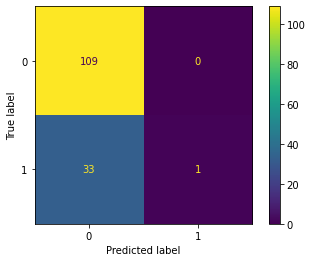

All metric scores:
 -  Accuracy :  0.7692307692307693
 -  Precision :  1.0
 -  Recall :  0.029411764705882353
 -  F1 score :  0.05714285714285715
 -  F2 score :  0.03649635036496351
 -  ROC AUC :  0.5147058823529411

- KNN Test
Confusion matrix:


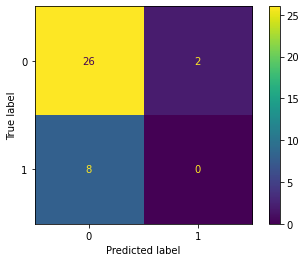

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4642857142857143

-------------------------
- NB Train
Confusion matrix:


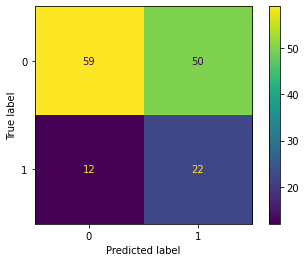

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.3055555555555556
 -  Recall :  0.6470588235294118
 -  F1 score :  0.41509433962264153
 -  F2 score :  0.528846153846154
 -  ROC AUC :  0.5941716135995683

- NB Test
Confusion matrix:


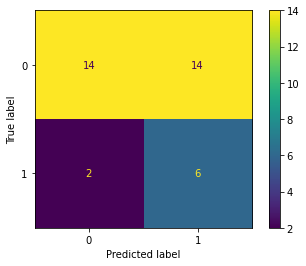

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.3
 -  Recall :  0.75
 -  F1 score :  0.4285714285714285
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.625

-------------------------
- LR Train
Confusion matrix:


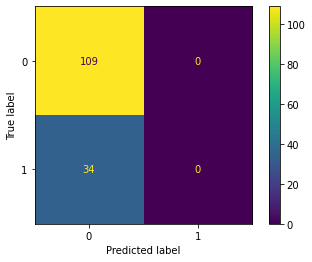

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


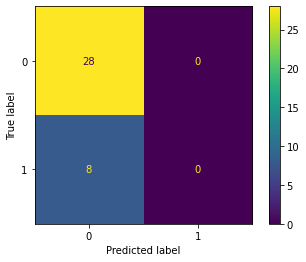

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


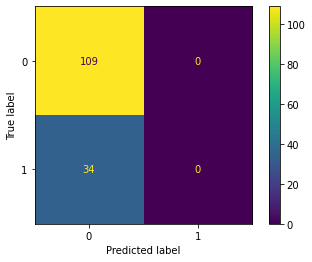

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


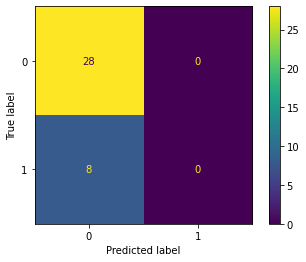

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


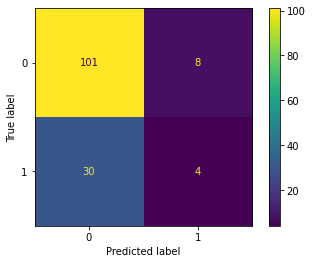

All metric scores:
 -  Accuracy :  0.7342657342657343
 -  Precision :  0.3333333333333333
 -  Recall :  0.11764705882352941
 -  F1 score :  0.1739130434782609
 -  F2 score :  0.13513513513513511
 -  ROC AUC :  0.5221262817053427

- MLP Test
Confusion matrix:


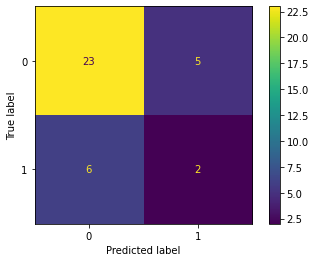

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.2857142857142857
 -  Recall :  0.25
 -  F1 score :  0.26666666666666666
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.5357142857142857

-------------------------
- RF-2 Train
Confusion matrix:


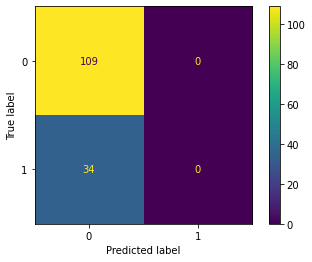

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


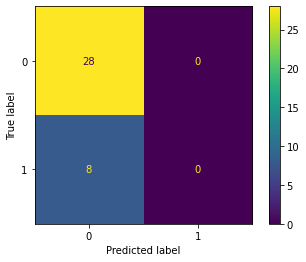

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


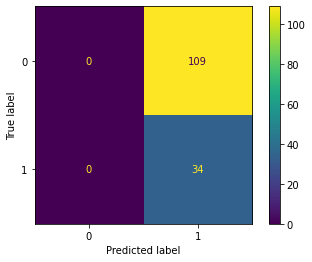

All metric scores:
 -  Accuracy :  0.23776223776223776
 -  Precision :  0.23776223776223776
 -  Recall :  1.0
 -  F1 score :  0.384180790960452
 -  F2 score :  0.6093189964157706
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


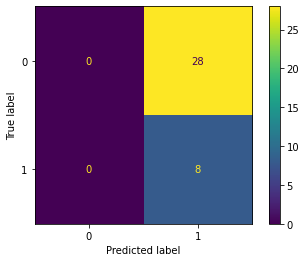

All metric scores:
 -  Accuracy :  0.2222222222222222
 -  Precision :  0.2222222222222222
 -  Recall :  1.0
 -  F1 score :  0.3636363636363636
 -  F2 score :  0.5882352941176471
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


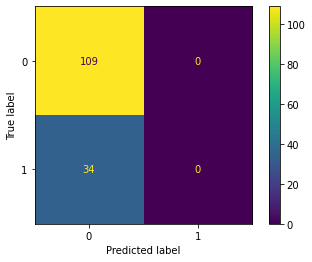

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


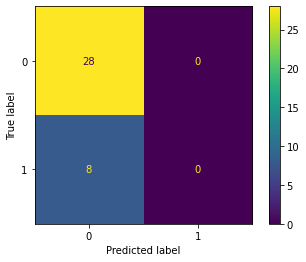

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


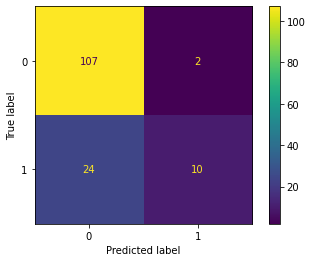

All metric scores:
 -  Accuracy :  0.8181818181818182
 -  Precision :  0.8333333333333334
 -  Recall :  0.29411764705882354
 -  F1 score :  0.4347826086956522
 -  F2 score :  0.3378378378378379
 -  ROC AUC :  0.6378845116028063

- KNN(original) Test
Confusion matrix:


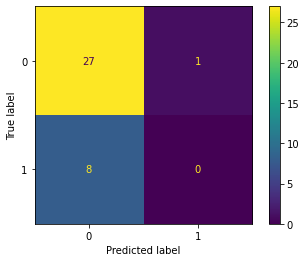

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.48214285714285715

-------------------------
- NB(original) Train
Confusion matrix:


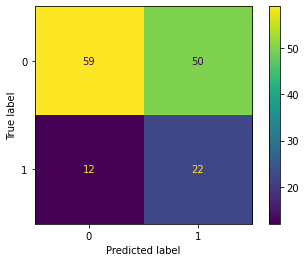

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.3055555555555556
 -  Recall :  0.6470588235294118
 -  F1 score :  0.41509433962264153
 -  F2 score :  0.528846153846154
 -  ROC AUC :  0.5941716135995683

- NB(original) Test
Confusion matrix:


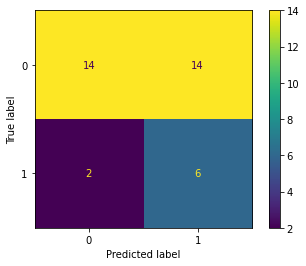

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.3
 -  Recall :  0.75
 -  F1 score :  0.4285714285714285
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.625

-------------------------
- LR(original) Train
Confusion matrix:


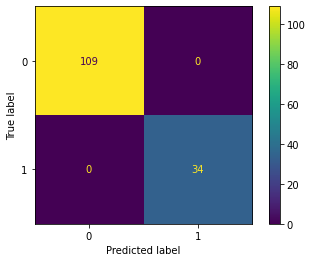

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


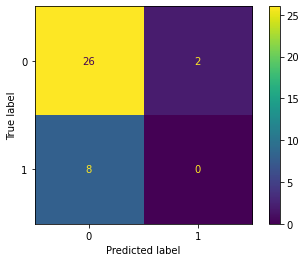

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4642857142857143

-------------------------
- SVM(original) Train
Confusion matrix:


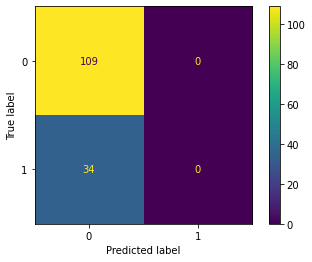

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM(original) Test
Confusion matrix:


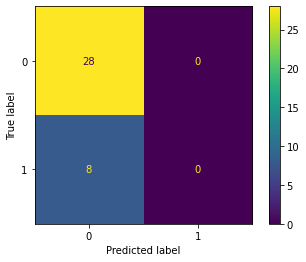

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


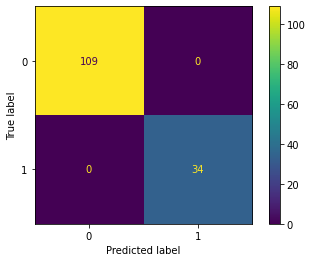

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


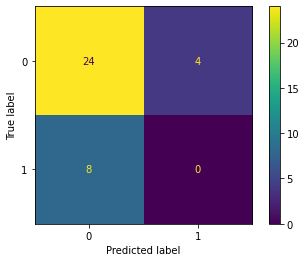

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4285714285714286

-------------------------
- RF(original) Train
Confusion matrix:


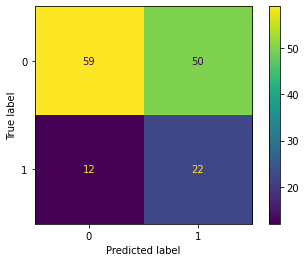

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.3055555555555556
 -  Recall :  0.6470588235294118
 -  F1 score :  0.41509433962264153
 -  F2 score :  0.528846153846154
 -  ROC AUC :  0.5941716135995683

- RF(original) Test
Confusion matrix:


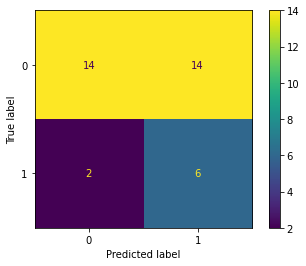

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.3
 -  Recall :  0.75
 -  F1 score :  0.4285714285714285
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.625

-------------------------
- XGB(original) Train
Confusion matrix:


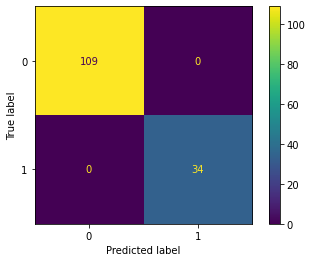

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


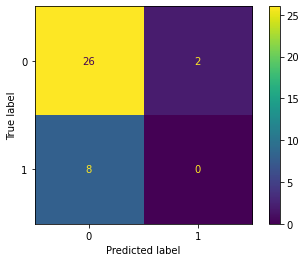

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4642857142857143
[LightGBM] [Info] Number of positive: 34, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246571
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237762 -> initscore=-1.164987
[LightGBM] [Info] Start training from score -1.164987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

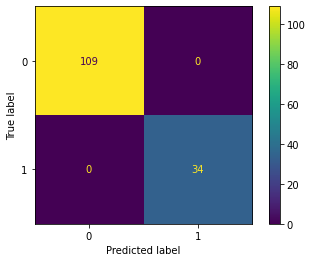

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


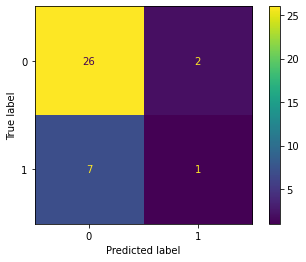

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.3333333333333333
 -  Recall :  0.125
 -  F1 score :  0.18181818181818182
 -  F2 score :  0.14285714285714285
 -  ROC AUC :  0.5267857142857143
KNN(original)
NB(original)
LR(original)
SVM(original)
MLP
RF(original)
XGB-4
LGBM(original)

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:17:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


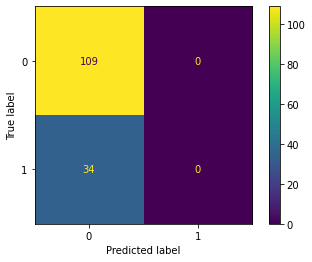

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


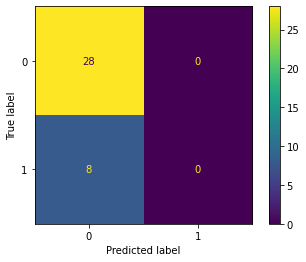

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:17:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


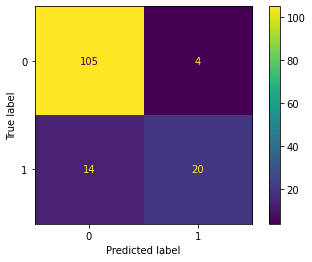

All metric scores:
 -  Accuracy :  0.8741258741258742
 -  Precision :  0.8333333333333334
 -  Recall :  0.5882352941176471
 -  F1 score :  0.6896551724137931
 -  F2 score :  0.625
 -  ROC AUC :  0.7757690232056126
Validation Set: 
Confusion matrix:


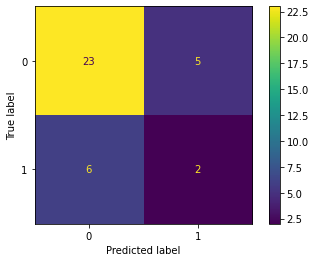

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.2857142857142857
 -  Recall :  0.25
 -  F1 score :  0.26666666666666666
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.5357142857142857

 -- Untuned estimators -- 
- Hard Voting: 
Training Set: 
Confusion matrix:


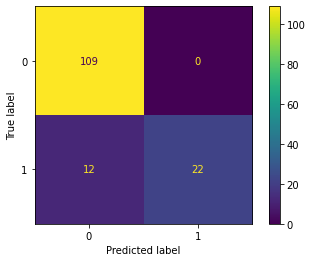

All metric scores:
 -  Accuracy :  0.916083916083916
 -  Precision :  1.0
 -  Recall :  0.6470588235294118
 -  F1 score :  0.7857142857142858
 -  F2 score :  0.6962025316455696
 -  ROC AUC :  0.8235294117647058
Validation Set: 
Confusion matrix:


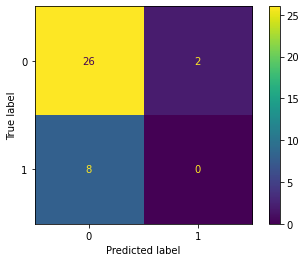

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4642857142857143
- Soft Voting: 
Training Set: 
Confusion matrix:


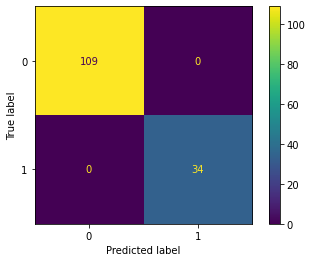

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


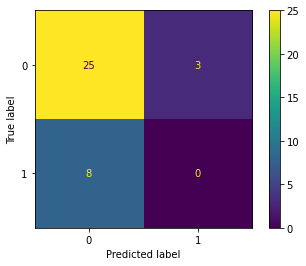

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.44642857142857145

 -- Mixed estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of positive: 33, number of negative: 105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238287
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239130 -> initscore=-1.157453
[LightGBM] [Info] Start training from score -1.157453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:18:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


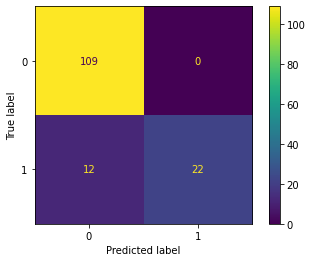

All metric scores:
 -  Accuracy :  0.916083916083916
 -  Precision :  1.0
 -  Recall :  0.6470588235294118
 -  F1 score :  0.7857142857142858
 -  F2 score :  0.6962025316455696
 -  ROC AUC :  0.8235294117647058
Validation Set: 
Confusion matrix:


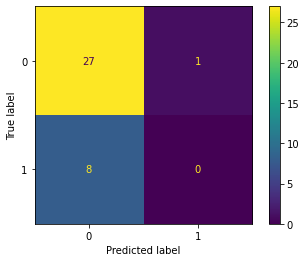

All metric scores:
 -  Accuracy :  0.75
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.48214285714285715
- Soft Voting: 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:18:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


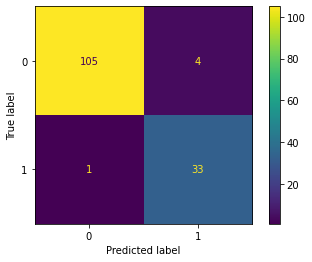

All metric scores:
 -  Accuracy :  0.965034965034965
 -  Precision :  0.8918918918918919
 -  Recall :  0.9705882352941176
 -  F1 score :  0.9295774647887325
 -  F2 score :  0.953757225433526
 -  ROC AUC :  0.9669454937938479
Validation Set: 
Confusion matrix:


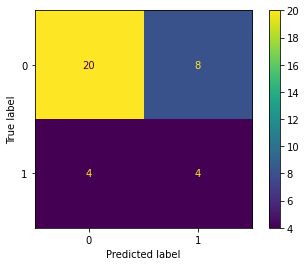

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.3333333333333333
 -  Recall :  0.5
 -  F1 score :  0.4
 -  F2 score :  0.45454545454545453
 -  ROC AUC :  0.6071428571428571
Best voting:  MIX_SoftVoting
Scores:  Confusion matrix    [[20, 8], [4, 4]]
Accuracy                     0.666667
Precision                    0.333333
Recall                            0.5
F1 score                          0.4
F2 score                     0.454545
ROC AUC                      0.607143
dtype: object

---------------------------------------------------
(108, 5000)
(33, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


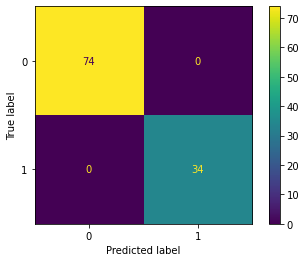

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


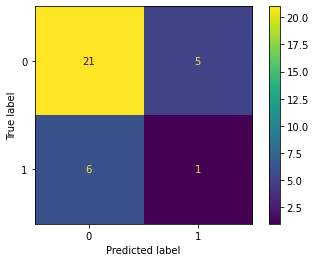

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.16666666666666666
 -  Recall :  0.14285714285714285
 -  F1 score :  0.15384615384615383
 -  F2 score :  0.14705882352941174
 -  ROC AUC :  0.47527472527472525

-------------------------
- NB Train
Confusion matrix:


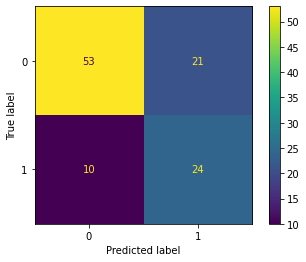

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- NB Test
Confusion matrix:


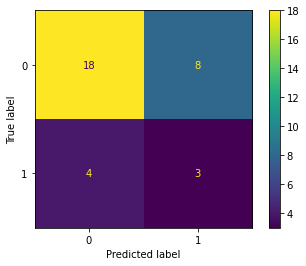

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.2727272727272727
 -  Recall :  0.42857142857142855
 -  F1 score :  0.33333333333333326
 -  F2 score :  0.38461538461538464
 -  ROC AUC :  0.5604395604395604

-------------------------
- LR Train
Confusion matrix:


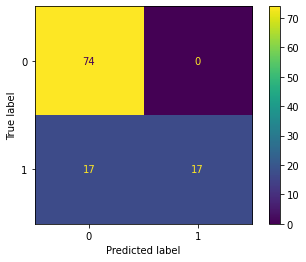

All metric scores:
 -  Accuracy :  0.8425925925925926
 -  Precision :  1.0
 -  Recall :  0.5
 -  F1 score :  0.6666666666666666
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.75

- LR Test
Confusion matrix:


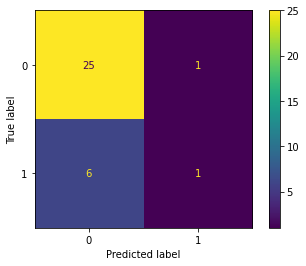

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.5
 -  Recall :  0.14285714285714285
 -  F1 score :  0.22222222222222224
 -  F2 score :  0.16666666666666666
 -  ROC AUC :  0.5521978021978021

-------------------------
- SVM Train
Confusion matrix:


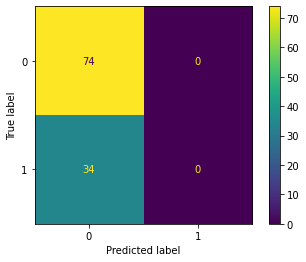

All metric scores:
 -  Accuracy :  0.6851851851851852
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


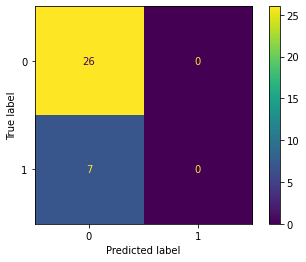

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


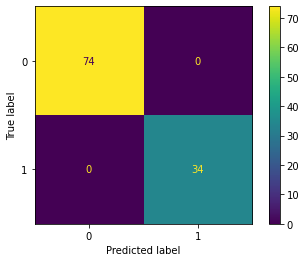

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


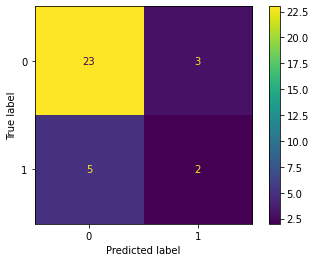

All metric scores:
 -  Accuracy :  0.7575757575757576
 -  Precision :  0.4
 -  Recall :  0.2857142857142857
 -  F1 score :  0.3333333333333333
 -  F2 score :  0.30303030303030304
 -  ROC AUC :  0.5851648351648351

-------------------------
- RF-2 Train
Confusion matrix:


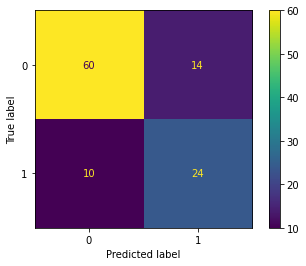

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.631578947368421
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6666666666666667
 -  F2 score :  0.6896551724137931
 -  ROC AUC :  0.7583465818759937

- RF-2 Test
Confusion matrix:


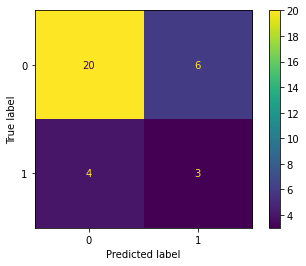

All metric scores:
 -  Accuracy :  0.696969696969697
 -  Precision :  0.3333333333333333
 -  Recall :  0.42857142857142855
 -  F1 score :  0.375
 -  F2 score :  0.4054054054054054
 -  ROC AUC :  0.5989010989010989

-------------------------
- XGB-4 Train
Confusion matrix:


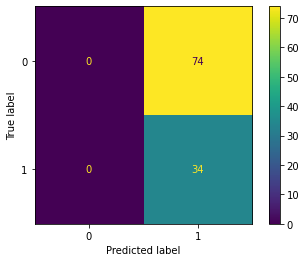

All metric scores:
 -  Accuracy :  0.3148148148148148
 -  Precision :  0.3148148148148148
 -  Recall :  1.0
 -  F1 score :  0.4788732394366197
 -  F2 score :  0.6967213114754098
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


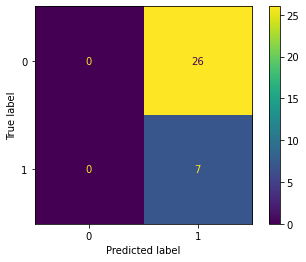

All metric scores:
 -  Accuracy :  0.21212121212121213
 -  Precision :  0.21212121212121213
 -  Recall :  1.0
 -  F1 score :  0.35
 -  F2 score :  0.5737704918032787
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


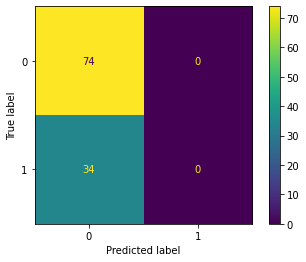

All metric scores:
 -  Accuracy :  0.6851851851851852
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


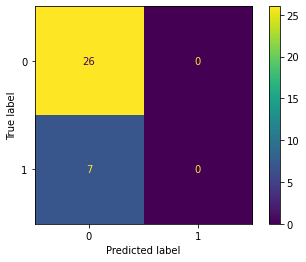

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


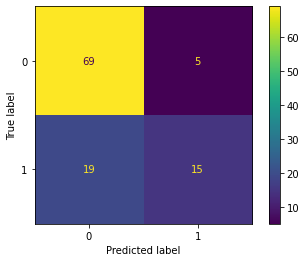

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.75
 -  Recall :  0.4411764705882353
 -  F1 score :  0.5555555555555556
 -  F2 score :  0.4807692307692307
 -  ROC AUC :  0.6868044515103339

- KNN(original) Test
Confusion matrix:


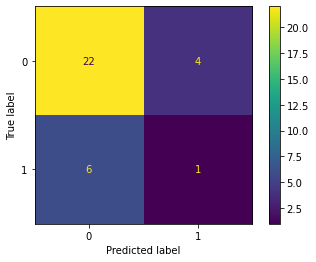

All metric scores:
 -  Accuracy :  0.696969696969697
 -  Precision :  0.2
 -  Recall :  0.14285714285714285
 -  F1 score :  0.16666666666666666
 -  F2 score :  0.15151515151515152
 -  ROC AUC :  0.49450549450549447

-------------------------
- NB(original) Train
Confusion matrix:


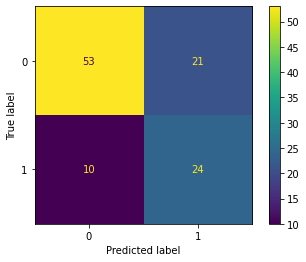

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- NB(original) Test
Confusion matrix:


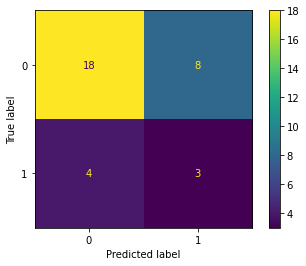

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.2727272727272727
 -  Recall :  0.42857142857142855
 -  F1 score :  0.33333333333333326
 -  F2 score :  0.38461538461538464
 -  ROC AUC :  0.5604395604395604

-------------------------
- LR(original) Train
Confusion matrix:


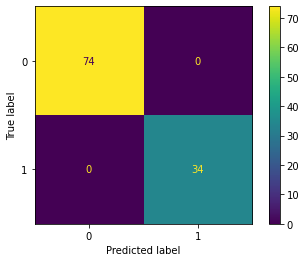

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


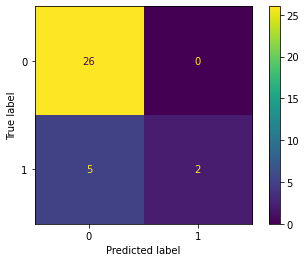

All metric scores:
 -  Accuracy :  0.8484848484848485
 -  Precision :  1.0
 -  Recall :  0.2857142857142857
 -  F1 score :  0.4444444444444445
 -  F2 score :  0.3333333333333333
 -  ROC AUC :  0.6428571428571428

-------------------------
- SVM(original) Train
Confusion matrix:


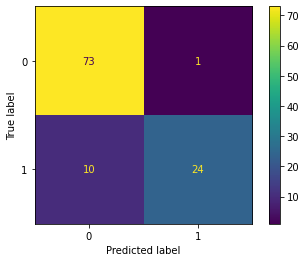

All metric scores:
 -  Accuracy :  0.8981481481481481
 -  Precision :  0.96
 -  Recall :  0.7058823529411765
 -  F1 score :  0.8135593220338982
 -  F2 score :  0.7453416149068323
 -  ROC AUC :  0.8461844197138316

- SVM(original) Test
Confusion matrix:


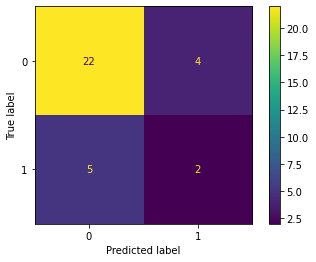

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.3333333333333333
 -  Recall :  0.2857142857142857
 -  F1 score :  0.30769230769230765
 -  F2 score :  0.2941176470588235
 -  ROC AUC :  0.5659340659340659

-------------------------
- MLP(original) Train
Confusion matrix:


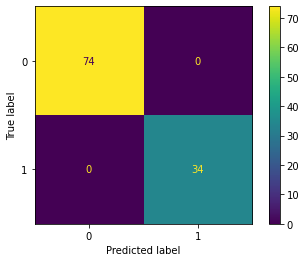

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


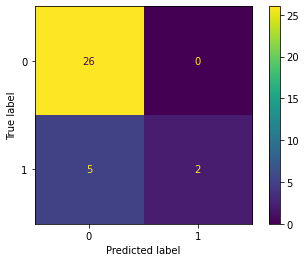

All metric scores:
 -  Accuracy :  0.8484848484848485
 -  Precision :  1.0
 -  Recall :  0.2857142857142857
 -  F1 score :  0.4444444444444445
 -  F2 score :  0.3333333333333333
 -  ROC AUC :  0.6428571428571428

-------------------------
- RF(original) Train
Confusion matrix:


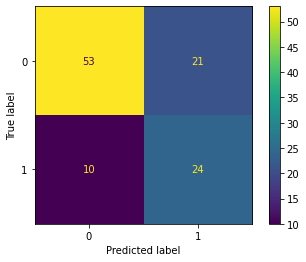

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- RF(original) Test
Confusion matrix:


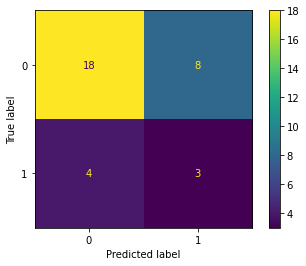

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.2727272727272727
 -  Recall :  0.42857142857142855
 -  F1 score :  0.33333333333333326
 -  F2 score :  0.38461538461538464
 -  ROC AUC :  0.5604395604395604

-------------------------
- XGB(original) Train
Confusion matrix:


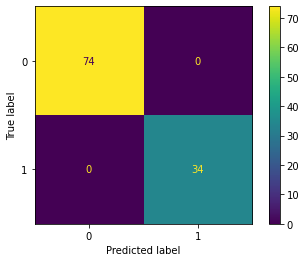

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


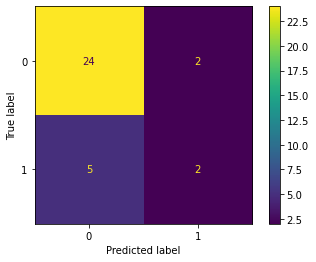

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.5
 -  Recall :  0.2857142857142857
 -  F1 score :  0.36363636363636365
 -  F2 score :  0.3125
 -  ROC AUC :  0.6043956043956044
[LightGBM] [Info] Number of positive: 34, number of negative: 74
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188302
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.314815 -> initscore=-0.777705
[LightGBM] [Info] Start training from score -0.777705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

Confusion matrix:


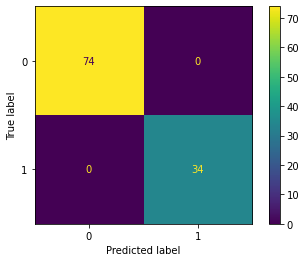

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


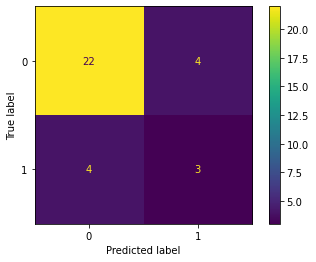

All metric scores:
 -  Accuracy :  0.7575757575757576
 -  Precision :  0.42857142857142855
 -  Recall :  0.42857142857142855
 -  F1 score :  0.42857142857142855
 -  F2 score :  0.42857142857142855
 -  ROC AUC :  0.6373626373626373
KNN(original)
NB(original)
LR(original)
SVM(original)
MLP(original)
RF-2
XGB-4
LGBM(original)

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:19:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


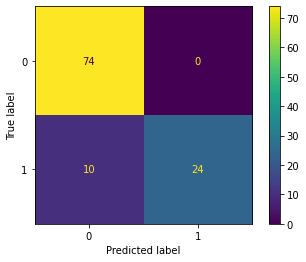

All metric scores:
 -  Accuracy :  0.9074074074074074
 -  Precision :  1.0
 -  Recall :  0.7058823529411765
 -  F1 score :  0.8275862068965517
 -  F2 score :  0.75
 -  ROC AUC :  0.8529411764705883
Validation Set: 
Confusion matrix:


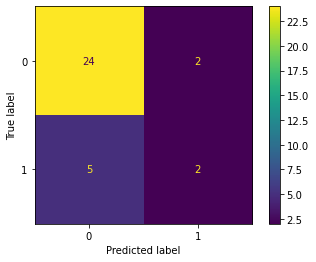

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.5
 -  Recall :  0.2857142857142857
 -  F1 score :  0.36363636363636365
 -  F2 score :  0.3125
 -  ROC AUC :  0.6043956043956044
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:19:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


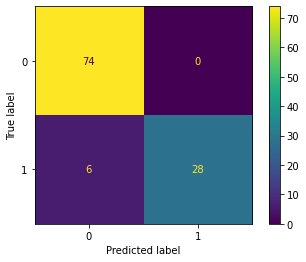

All metric scores:
 -  Accuracy :  0.9444444444444444
 -  Precision :  1.0
 -  Recall :  0.8235294117647058
 -  F1 score :  0.9032258064516129
 -  F2 score :  0.8536585365853658
 -  ROC AUC :  0.9117647058823529
Validation Set: 
Confusion matrix:


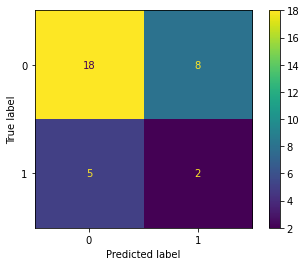

All metric scores:
 -  Accuracy :  0.6060606060606061
 -  Precision :  0.2
 -  Recall :  0.2857142857142857
 -  F1 score :  0.23529411764705882
 -  F2 score :  0.26315789473684204
 -  ROC AUC :  0.48901098901098894

 -- Untuned estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of positive: 34, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246571
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237762 -> initscore=-1.164987
[LightGBM] [Info] Start training from score -1.164987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Set: 
Confusion matrix:


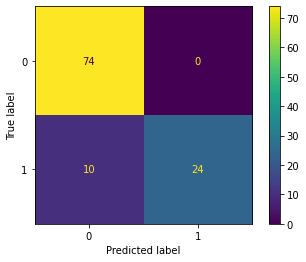

All metric scores:
 -  Accuracy :  0.9074074074074074
 -  Precision :  1.0
 -  Recall :  0.7058823529411765
 -  F1 score :  0.8275862068965517
 -  F2 score :  0.75
 -  ROC AUC :  0.8529411764705883
Validation Set: 
Confusion matrix:


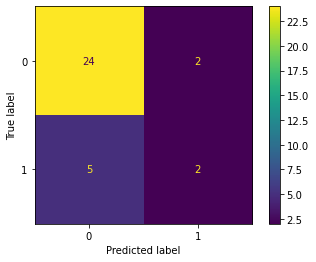

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.5
 -  Recall :  0.2857142857142857
 -  F1 score :  0.36363636363636365
 -  F2 score :  0.3125
 -  ROC AUC :  0.6043956043956044
- Soft Voting: 
[LightGBM] [Info] Number of positive: 34, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246571
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237762 -> initscore=-1.164987
[LightGBM] [Info] Start training from score -1.164987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Training Set: 
Confusion matrix:


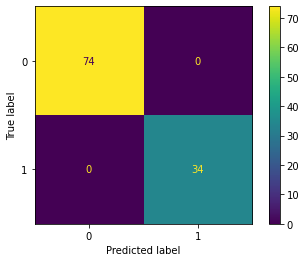

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


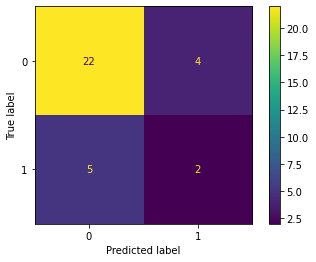

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.3333333333333333
 -  Recall :  0.2857142857142857
 -  F1 score :  0.30769230769230765
 -  F2 score :  0.2941176470588235
 -  ROC AUC :  0.5659340659340659

 -- Mixed estimators -- 
- Hard Voting: 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246571
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237762 -> initscore=-1.164987
[LightGBM] [Info] Start training from score -1.164987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:19:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


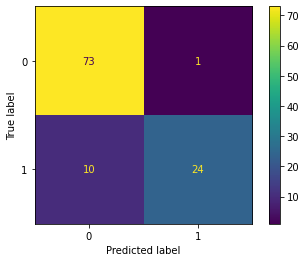

All metric scores:
 -  Accuracy :  0.8981481481481481
 -  Precision :  0.96
 -  Recall :  0.7058823529411765
 -  F1 score :  0.8135593220338982
 -  F2 score :  0.7453416149068323
 -  ROC AUC :  0.8461844197138316
Validation Set: 
Confusion matrix:


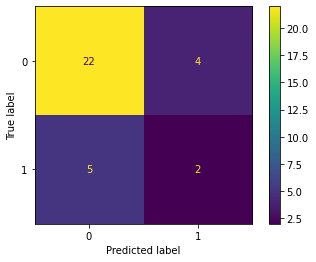

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.3333333333333333
 -  Recall :  0.2857142857142857
 -  F1 score :  0.30769230769230765
 -  F2 score :  0.2941176470588235
 -  ROC AUC :  0.5659340659340659
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:19:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

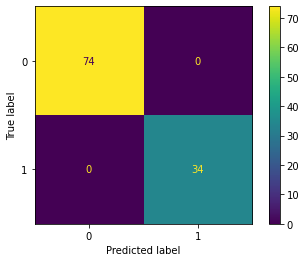

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


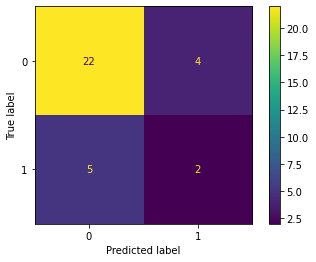

All metric scores:
 -  Accuracy :  0.7272727272727273
 -  Precision :  0.3333333333333333
 -  Recall :  0.2857142857142857
 -  F1 score :  0.30769230769230765
 -  F2 score :  0.2941176470588235
 -  ROC AUC :  0.5659340659340659
Best voting:  GS_HardVoting
Scores:  Confusion matrix    [[24, 2], [5, 2]]
Accuracy                     0.787879
Precision                         0.5
Recall                       0.285714
F1 score                     0.363636
F2 score                       0.3125
ROC AUC                      0.604396
dtype: object

---------------------------------------------------
(142, 5000)
(34, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---

--Grid Search Estimators

-------------------------
- KNN Train
Confusion matrix:


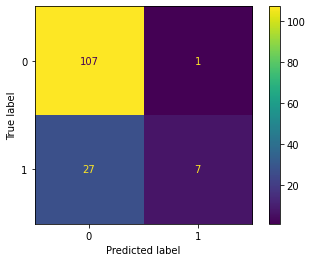

All metric scores:
 -  Accuracy :  0.8028169014084507
 -  Precision :  0.875
 -  Recall :  0.20588235294117646
 -  F1 score :  0.33333333333333337
 -  F2 score :  0.24305555555555552
 -  ROC AUC :  0.5983115468409586

- KNN Test
Confusion matrix:


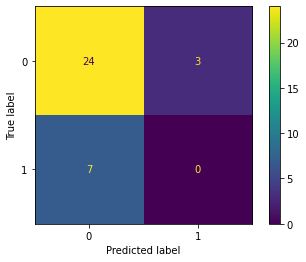

All metric scores:
 -  Accuracy :  0.7058823529411765
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4444444444444444

-------------------------
- NB Train
Confusion matrix:


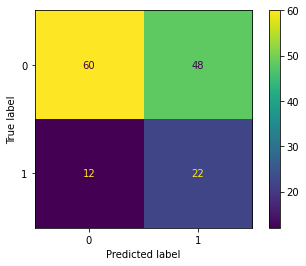

All metric scores:
 -  Accuracy :  0.5774647887323944
 -  Precision :  0.3142857142857143
 -  Recall :  0.6470588235294118
 -  F1 score :  0.4230769230769231
 -  F2 score :  0.5339805825242718
 -  ROC AUC :  0.6013071895424836

- NB Test
Confusion matrix:


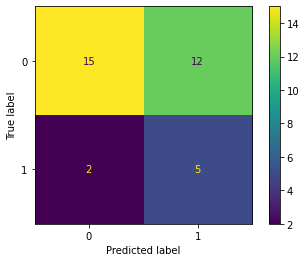

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.29411764705882354
 -  Recall :  0.7142857142857143
 -  F1 score :  0.4166666666666667
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.6349206349206349

-------------------------
- LR Train
Confusion matrix:


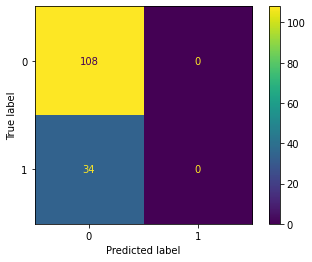

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


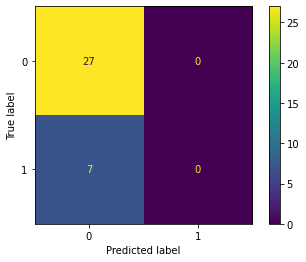

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


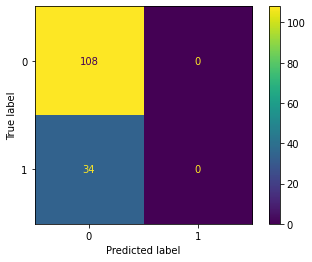

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


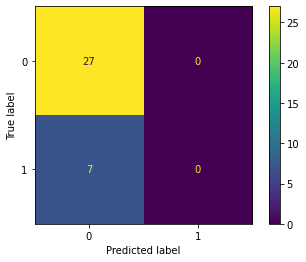

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


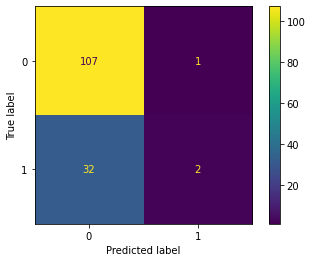

All metric scores:
 -  Accuracy :  0.7676056338028169
 -  Precision :  0.6666666666666666
 -  Recall :  0.058823529411764705
 -  F1 score :  0.10810810810810811
 -  F2 score :  0.07194244604316546
 -  ROC AUC :  0.5247821350762527

- MLP Test
Confusion matrix:


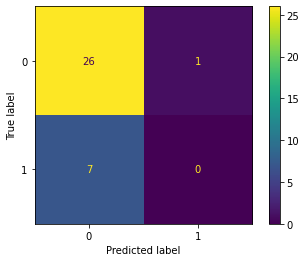

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815

-------------------------
- RF-2 Train
Confusion matrix:


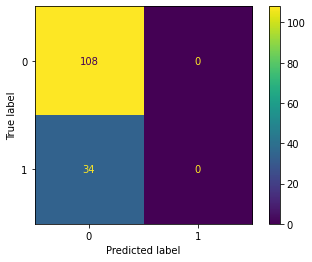

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


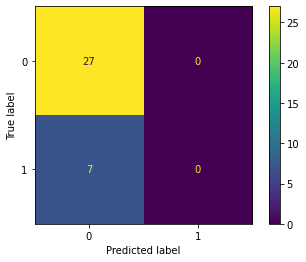

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


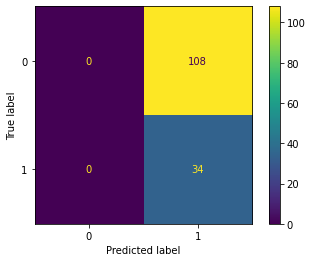

All metric scores:
 -  Accuracy :  0.23943661971830985
 -  Precision :  0.23943661971830985
 -  Recall :  1.0
 -  F1 score :  0.38636363636363635
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


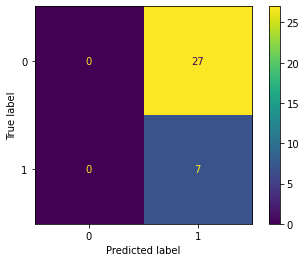

All metric scores:
 -  Accuracy :  0.20588235294117646
 -  Precision :  0.20588235294117646
 -  Recall :  1.0
 -  F1 score :  0.34146341463414637
 -  F2 score :  0.564516129032258
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


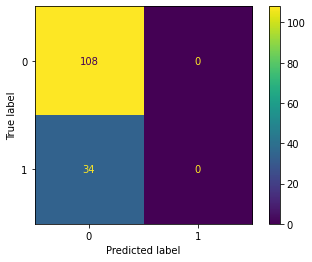

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


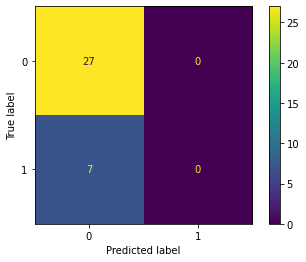

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

  --Original Estimators

-------------------------
- KNN(original) Train
Confusion matrix:


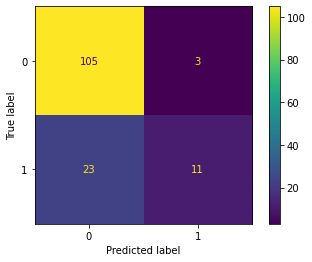

All metric scores:
 -  Accuracy :  0.8169014084507042
 -  Precision :  0.7857142857142857
 -  Recall :  0.3235294117647059
 -  F1 score :  0.45833333333333326
 -  F2 score :  0.36666666666666664
 -  ROC AUC :  0.647875816993464

- KNN(original) Test
Confusion matrix:


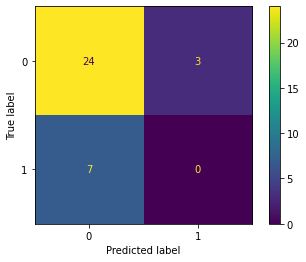

All metric scores:
 -  Accuracy :  0.7058823529411765
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4444444444444444

-------------------------
- NB(original) Train
Confusion matrix:


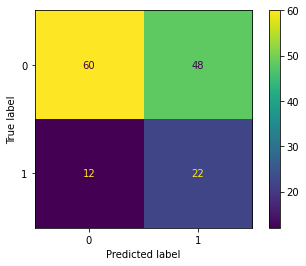

All metric scores:
 -  Accuracy :  0.5774647887323944
 -  Precision :  0.3142857142857143
 -  Recall :  0.6470588235294118
 -  F1 score :  0.4230769230769231
 -  F2 score :  0.5339805825242718
 -  ROC AUC :  0.6013071895424836

- NB(original) Test
Confusion matrix:


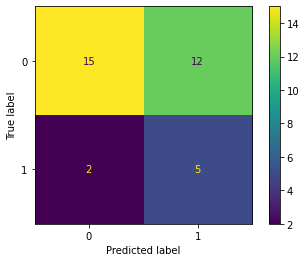

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.29411764705882354
 -  Recall :  0.7142857142857143
 -  F1 score :  0.4166666666666667
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.6349206349206349

-------------------------
- LR(original) Train
Confusion matrix:


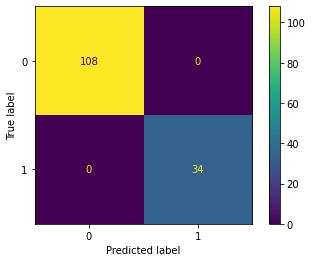

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LR(original) Test
Confusion matrix:


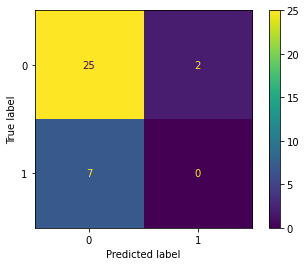

All metric scores:
 -  Accuracy :  0.7352941176470589
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.46296296296296297

-------------------------
- SVM(original) Train
Confusion matrix:


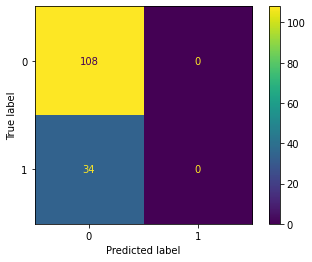

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM(original) Test
Confusion matrix:


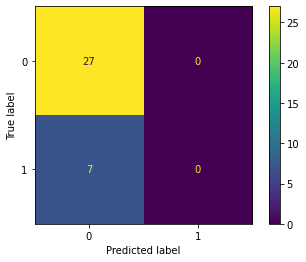

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP(original) Train
Confusion matrix:


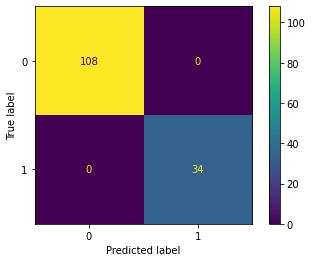

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP(original) Test
Confusion matrix:


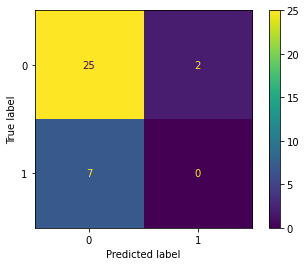

All metric scores:
 -  Accuracy :  0.7352941176470589
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.46296296296296297

-------------------------
- RF(original) Train
Confusion matrix:


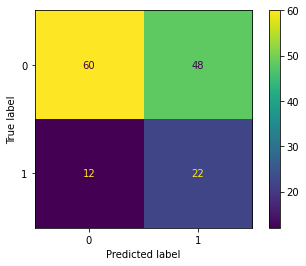

All metric scores:
 -  Accuracy :  0.5774647887323944
 -  Precision :  0.3142857142857143
 -  Recall :  0.6470588235294118
 -  F1 score :  0.4230769230769231
 -  F2 score :  0.5339805825242718
 -  ROC AUC :  0.6013071895424836

- RF(original) Test
Confusion matrix:


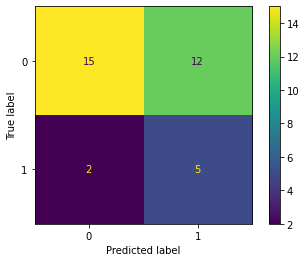

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.29411764705882354
 -  Recall :  0.7142857142857143
 -  F1 score :  0.4166666666666667
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.6349206349206349

-------------------------
- XGB(original) Train
Confusion matrix:


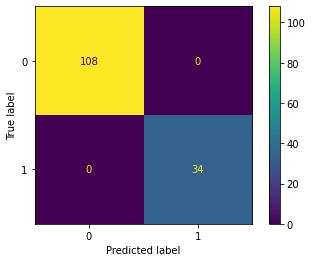

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- XGB(original) Test
Confusion matrix:


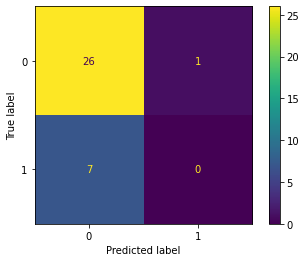

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815
[LightGBM] [Info] Number of positive: 34, number of negative: 108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244941
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239437 -> initscore=-1.155771
[LightGBM] [Info] Start training from score -1.155771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

Confusion matrix:


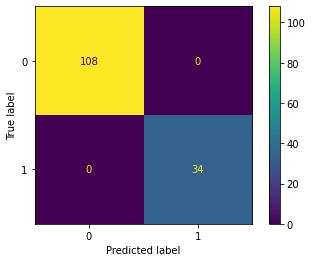

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- LGBM(original) Test
Confusion matrix:


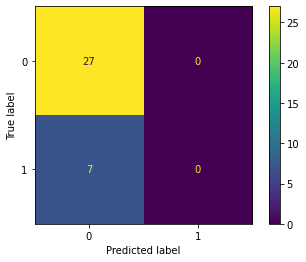

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
KNN(original)
NB(original)
LR(original)
SVM(original)
MLP(original)
RF(original)
XGB-4
LGBM(original)

 -- Grid Search estimators -- 
- Hard Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:20:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


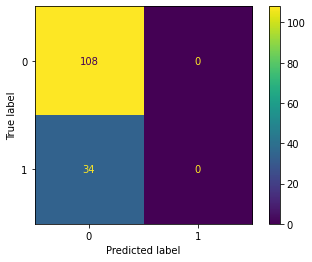

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
Validation Set: 
Confusion matrix:


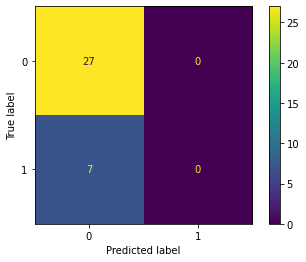

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:20:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


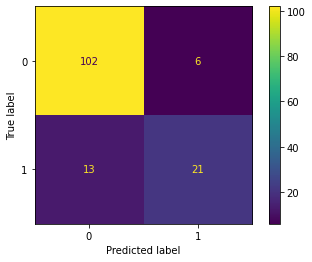

All metric scores:
 -  Accuracy :  0.8661971830985915
 -  Precision :  0.7777777777777778
 -  Recall :  0.6176470588235294
 -  F1 score :  0.6885245901639345
 -  F2 score :  0.6441717791411042
 -  ROC AUC :  0.7810457516339869
Validation Set: 
Confusion matrix:


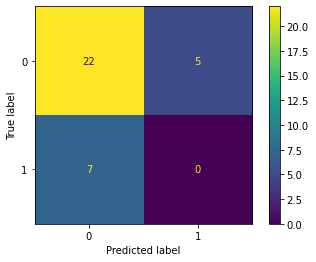

All metric scores:
 -  Accuracy :  0.6470588235294118
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.40740740740740744

 -- Untuned estimators -- 
- Hard Voting: 
Training Set: 
Confusion matrix:


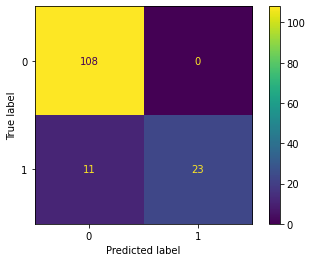

All metric scores:
 -  Accuracy :  0.9225352112676056
 -  Precision :  1.0
 -  Recall :  0.6764705882352942
 -  F1 score :  0.8070175438596492
 -  F2 score :  0.7232704402515724
 -  ROC AUC :  0.8382352941176471
Validation Set: 
Confusion matrix:


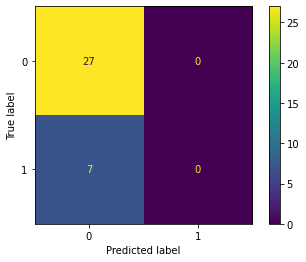

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5
- Soft Voting: 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198290
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289474 -> initscore=-0.897942
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Training Set: 
Confusion matrix:


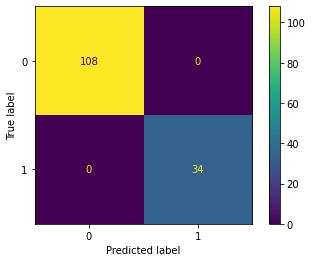

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0
Validation Set: 
Confusion matrix:


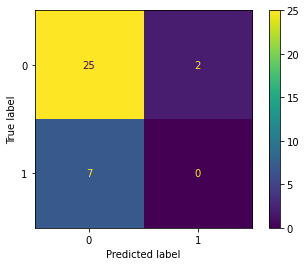

All metric scores:
 -  Accuracy :  0.7352941176470589
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.46296296296296297

 -- Mixed estimators -- 
- Hard Voting: 
[LightGBM] [Info] Number of positive: 33, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198290
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289474 -> initscore=-0.897942
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:21:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


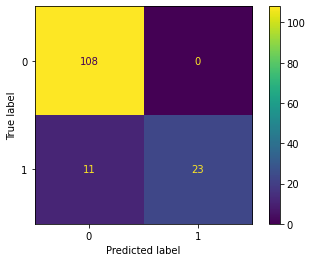

All metric scores:
 -  Accuracy :  0.9225352112676056
 -  Precision :  1.0
 -  Recall :  0.6764705882352942
 -  F1 score :  0.8070175438596492
 -  F2 score :  0.7232704402515724
 -  ROC AUC :  0.8382352941176471
Validation Set: 
Confusion matrix:


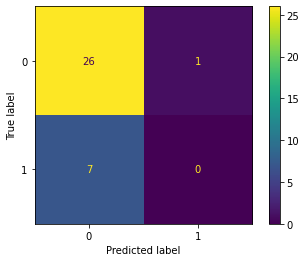

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815
- Soft Voting: 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:21:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


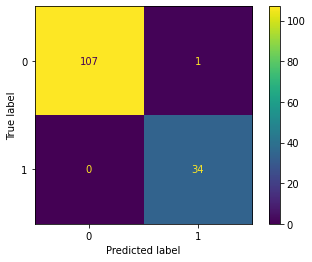

All metric scores:
 -  Accuracy :  0.9929577464788732
 -  Precision :  0.9714285714285714
 -  Recall :  1.0
 -  F1 score :  0.9855072463768115
 -  F2 score :  0.9941520467836256
 -  ROC AUC :  0.9953703703703703
Validation Set: 
Confusion matrix:


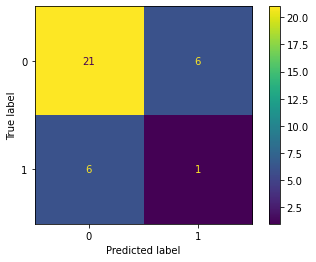

All metric scores:
 -  Accuracy :  0.6470588235294118
 -  Precision :  0.14285714285714285
 -  Recall :  0.14285714285714285
 -  F1 score :  0.14285714285714285
 -  F2 score :  0.14285714285714285
 -  ROC AUC :  0.4603174603174603
Best voting:  MIX_SoftVoting
Scores:  Confusion matrix    [[21, 6], [6, 1]]
Accuracy                     0.647059
Precision                    0.142857
Recall                       0.142857
F1 score                     0.142857
F2 score                     0.142857
ROC AUC                      0.460317
dtype: object

---------------------------------------------------


In [47]:
# for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
#     X_train_CV = X_train.iloc[train_index]    
#     X_train_CV = X_train_CV.iloc[model_1_prediction_train[i] == 1]
    
#     X_val_CV = X_train.iloc[test_index]
#     X_val_CV = X_val_CV.iloc[model_1_prediction_validation[i] == 1]
    
#     print(X_train_CV.shape)
#     print(X_val_CV.shape)

#     y_train_CV = is_ASD(pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])
#     y_val_CV = is_ASD(pd.Series(y_train).iloc[test_index].iloc[model_1_prediction_validation[i] == 1])
    
#     est_og = [("KNN(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', KNeighborsClassifier())])),
#               ("NB(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', GaussianNB())])),
#               ("LR(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', LogisticRegression(max_iter=5000))])),
#               ("SVM(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', svm.SVC(probability=True))])),
#               ("MLP(original)", Pipeline([('scaler', StandardScaler()), 
#                                           ('classifier', MLPClassifier(random_state=3))])),
#               ("RF(original)", Pipeline([('scaler', StandardScaler()), 
#                                          ('classifier', GaussianNB())])),
#               ("XGB(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', XGBClassifier(seed=3,scale_pos_weight=0.67 #sum(negative instances) / sum(positive instances)
#                                                                       ))])),
#               ("LGBM(original)", Pipeline([('scaler', StandardScaler()),
#                                           ('classifier', LGBMClassifier(random_state=3))]))
#              ]    
    
#     est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m1.items()]
    
#     est_gs.pop(5)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(6)
#     est_gs.pop(7)
    
#     print("\n---------------------------------------------------")
    
#     print("\n---Fold Summary---")
    
#     train_scores_gs = []
#     val_scores_gs = []
    
#     print("\n--Grid Search Estimators")
#     for (key, estimator) in est_gs:
#         estimator.fit(X_train_CV, y_train_CV)
        
#         print("\n-------------------------")
#         print("-", key, "Train")
        
#         train_scores_gs.append(all_scores(y_train_CV,
#                                           estimator.predict(X_train_CV),
#                                           to_print = True))
        
#         print("\n-", key, "Test")
#         val_scores_gs.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
#     train_scores_og = []
#     val_scores_og = []
    
#     print("\n  --Original Estimators")
#     for (key, estimator) in est_og:
#         estimator.fit(X_train_CV, y_train_CV)
        
#         print("\n-------------------------")
#         print("-", key, "Train")
        
#         train_scores_og.append(all_scores(y_true = y_train_CV,
#                                        y_pred = estimator.predict(X_train_CV),
#                                        to_print = True))
        
#         print("\n-", key, "Test")
#         val_scores_og.append(all_scores(y_true = y_val_CV,
#                                      y_pred = estimator.predict(X_val_CV),
#                                        to_print = True))
        
    
#     est_mix = []
    
#     for j, (key, _) in enumerate(est_gs):
#         if(val_scores_gs[j]["F2 score"] > val_scores_og[j]["F2 score"]):
#             est_mix.append(est_gs[j])
#         else:
#             est_mix.append(est_og[j])
      
        
#     [print(key) for (key, _) in est_mix]
    
    
#     voting_training_scores = []
#     voting_validation_scores = []
    
#     #hard voting
    
#     print("\n -- Grid Search estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_gs, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("GS_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_gs, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)
                
#     print("Training Set: ")
#     voting_training_scores.append(("GS_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("GS_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
    
    
    
#     print("\n -- Untuned estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_og, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_og, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("OG_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("OG_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True))) 
    
    
#     print("\n -- Mixed estimators -- ")
    
#     print("- Hard Voting: ")

#     hard_voting = VotingClassifier(estimators=est_mix, 
#                                    voting='hard', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     hard_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_HardVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = hard_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_HardVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = hard_voting.predict(X_val_CV),
#                                                 to_print = True)))
    
#     print("- Soft Voting: ")
    
#     soft_voting = VotingClassifier(estimators=est_mix, 
#                                    voting='soft', 
#                                    n_jobs=-1,
#                                    verbose=False)

#     soft_voting.fit(X_train_CV, y_train_CV)

#     print("Training Set: ")
#     voting_training_scores.append(("MIX_SoftVoting", 
#                                    all_scores(y_true = y_train_CV,
#                                               y_pred = soft_voting.predict(X_train_CV),
#                                               to_print = True)))
    
#     print("Validation Set: ")
#     voting_validation_scores.append(("MIX_SoftVoting", 
#                                      all_scores(y_true = y_val_CV,
#                                                 y_pred = soft_voting.predict(X_val_CV),
#                                                 to_print = True)))

#     best_scores = ("null", {"F2 score": -1})
#     for tup in voting_validation_scores:
#         if (tup[1]["F2 score"] > best_scores[1]["F2 score"]):
#             best_scores = tup
        
#     print("Best voting: ", best_scores[0])
#     print("Scores: ", best_scores[1])
    
#     print("\n---------------------------------------------------")

(138, 5000)
(35, 5000)
Number ASD Development: 33
Number ASD Development: 9

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


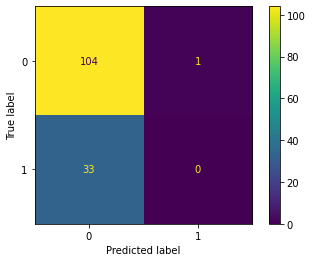

All metric scores:
 -  Accuracy :  0.7536231884057971
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.49523809523809526

- KNN Test
Confusion matrix:


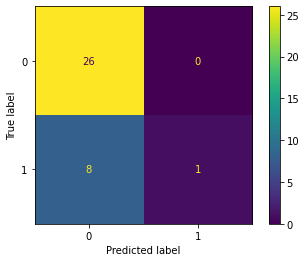

All metric scores:
 -  Accuracy :  0.7714285714285715
 -  Precision :  1.0
 -  Recall :  0.1111111111111111
 -  F1 score :  0.19999999999999998
 -  F2 score :  0.13513513513513514
 -  ROC AUC :  0.5555555555555556

-------------------------
- NB Train
Confusion matrix:


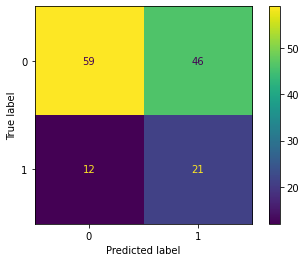

All metric scores:
 -  Accuracy :  0.5797101449275363
 -  Precision :  0.31343283582089554
 -  Recall :  0.6363636363636364
 -  F1 score :  0.42000000000000004
 -  F2 score :  0.5276381909547739
 -  ROC AUC :  0.5991341991341992

- NB Test
Confusion matrix:


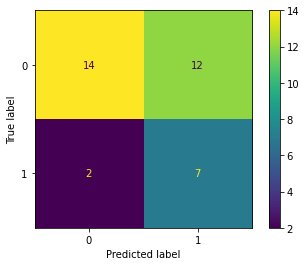

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.3684210526315789
 -  Recall :  0.7777777777777778
 -  F1 score :  0.5
 -  F2 score :  0.6363636363636364
 -  ROC AUC :  0.6581196581196581

-------------------------
- LR Train
Confusion matrix:


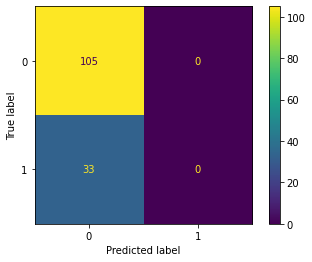

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


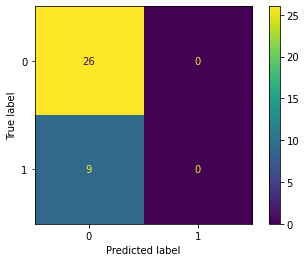

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


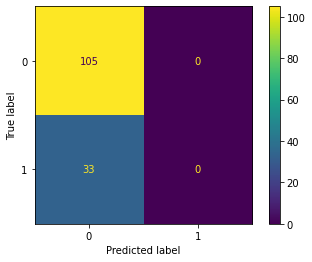

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


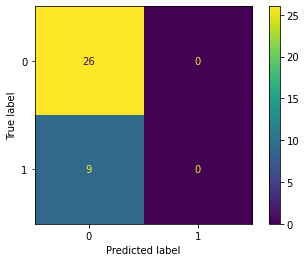

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


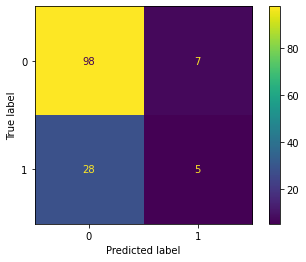

All metric scores:
 -  Accuracy :  0.7463768115942029
 -  Precision :  0.4166666666666667
 -  Recall :  0.15151515151515152
 -  F1 score :  0.2222222222222222
 -  F2 score :  0.1736111111111111
 -  ROC AUC :  0.5424242424242425

- MLP Test
Confusion matrix:


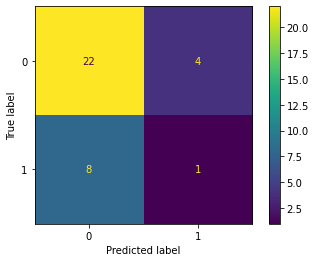

All metric scores:
 -  Accuracy :  0.6571428571428571
 -  Precision :  0.2
 -  Recall :  0.1111111111111111
 -  F1 score :  0.14285714285714285
 -  F2 score :  0.1219512195121951
 -  ROC AUC :  0.47863247863247865

-------------------------
- RF-2 Train
Confusion matrix:


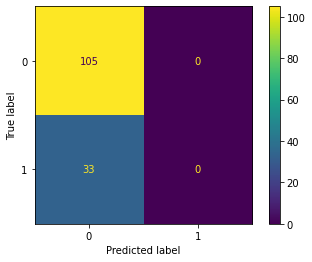

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


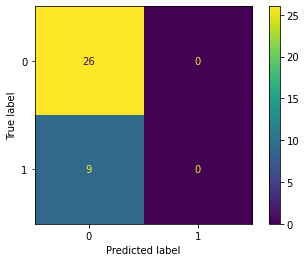

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


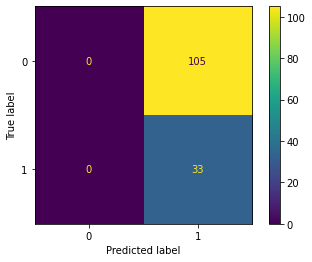

All metric scores:
 -  Accuracy :  0.2391304347826087
 -  Precision :  0.2391304347826087
 -  Recall :  1.0
 -  F1 score :  0.3859649122807018
 -  F2 score :  0.611111111111111
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


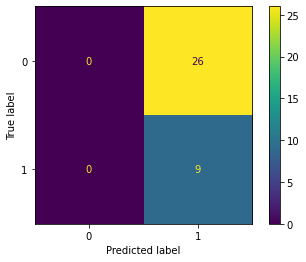

All metric scores:
 -  Accuracy :  0.2571428571428571
 -  Precision :  0.2571428571428571
 -  Recall :  1.0
 -  F1 score :  0.40909090909090906
 -  F2 score :  0.6338028169014084
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


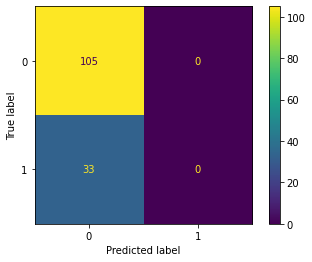

All metric scores:
 -  Accuracy :  0.7608695652173914
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


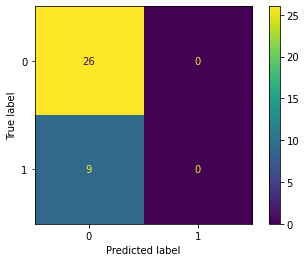

All metric scores:
 -  Accuracy :  0.7428571428571429
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:22:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


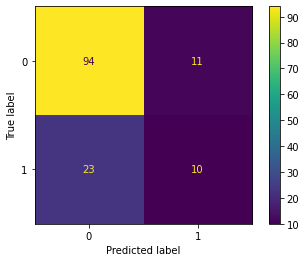

All metric scores:
 -  Accuracy :  0.7536231884057971
 -  Precision :  0.47619047619047616
 -  Recall :  0.30303030303030304
 -  F1 score :  0.37037037037037035
 -  F2 score :  0.32679738562091504
 -  ROC AUC :  0.5991341991341992
Validation Set: 
Confusion matrix:


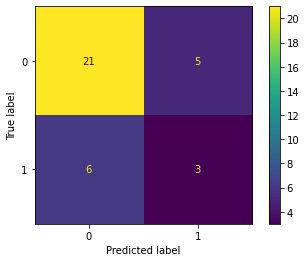

All metric scores:
 -  Accuracy :  0.6857142857142857
 -  Precision :  0.375
 -  Recall :  0.3333333333333333
 -  F1 score :  0.35294117647058826
 -  F2 score :  0.34090909090909094
 -  ROC AUC :  0.5705128205128205

---------------------------------------------------
(114, 5000)
(30, 5000)
Number ASD Development: 33
Number ASD Development: 6

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


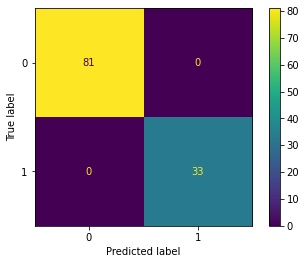

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


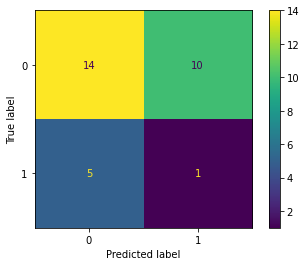

All metric scores:
 -  Accuracy :  0.5
 -  Precision :  0.09090909090909091
 -  Recall :  0.16666666666666666
 -  F1 score :  0.11764705882352942
 -  F2 score :  0.14285714285714288
 -  ROC AUC :  0.37499999999999994

-------------------------
- NB Train
Confusion matrix:


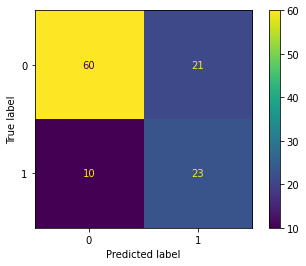

All metric scores:
 -  Accuracy :  0.7280701754385965
 -  Precision :  0.5227272727272727
 -  Recall :  0.696969696969697
 -  F1 score :  0.5974025974025974
 -  F2 score :  0.6534090909090908
 -  ROC AUC :  0.7188552188552189

- NB Test
Confusion matrix:


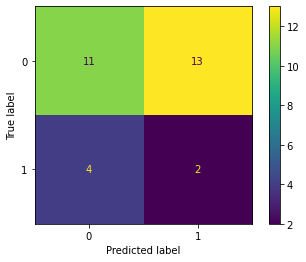

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

-------------------------
- LR Train
Confusion matrix:


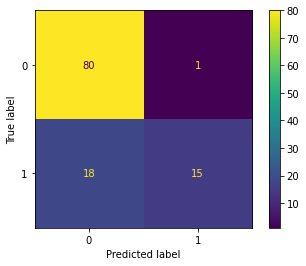

All metric scores:
 -  Accuracy :  0.8333333333333334
 -  Precision :  0.9375
 -  Recall :  0.45454545454545453
 -  F1 score :  0.6122448979591837
 -  F2 score :  0.5067567567567567
 -  ROC AUC :  0.7210998877665544

- LR Test
Confusion matrix:


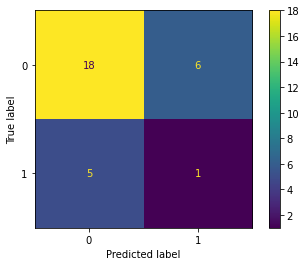

All metric scores:
 -  Accuracy :  0.6333333333333333
 -  Precision :  0.14285714285714285
 -  Recall :  0.16666666666666666
 -  F1 score :  0.15384615384615383
 -  F2 score :  0.16129032258064516
 -  ROC AUC :  0.4583333333333333

-------------------------
- SVM Train
Confusion matrix:


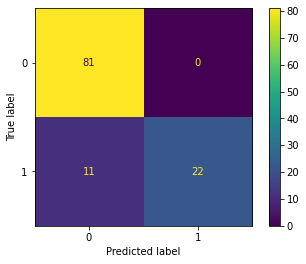

All metric scores:
 -  Accuracy :  0.9035087719298246
 -  Precision :  1.0
 -  Recall :  0.6666666666666666
 -  F1 score :  0.8
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.8333333333333333

- SVM Test
Confusion matrix:


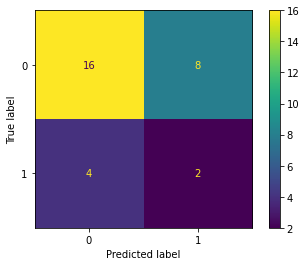

All metric scores:
 -  Accuracy :  0.6
 -  Precision :  0.2
 -  Recall :  0.3333333333333333
 -  F1 score :  0.25
 -  F2 score :  0.29411764705882354
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


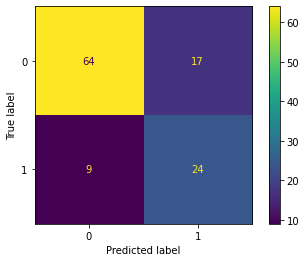

All metric scores:
 -  Accuracy :  0.7719298245614035
 -  Precision :  0.5853658536585366
 -  Recall :  0.7272727272727273
 -  F1 score :  0.6486486486486487
 -  F2 score :  0.6936416184971098
 -  ROC AUC :  0.7586980920314254

- MLP Test
Confusion matrix:


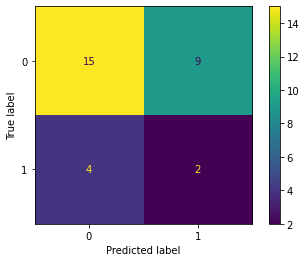

All metric scores:
 -  Accuracy :  0.5666666666666667
 -  Precision :  0.18181818181818182
 -  Recall :  0.3333333333333333
 -  F1 score :  0.23529411764705885
 -  F2 score :  0.28571428571428575
 -  ROC AUC :  0.47916666666666663

-------------------------
- RF-2 Train
Confusion matrix:


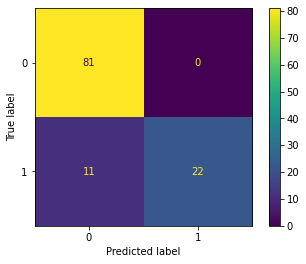

All metric scores:
 -  Accuracy :  0.9035087719298246
 -  Precision :  1.0
 -  Recall :  0.6666666666666666
 -  F1 score :  0.8
 -  F2 score :  0.7142857142857142
 -  ROC AUC :  0.8333333333333333

- RF-2 Test
Confusion matrix:


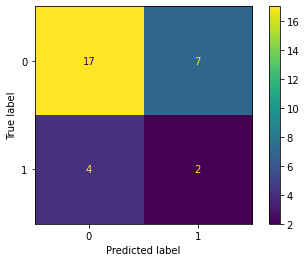

All metric scores:
 -  Accuracy :  0.6333333333333333
 -  Precision :  0.2222222222222222
 -  Recall :  0.3333333333333333
 -  F1 score :  0.26666666666666666
 -  F2 score :  0.30303030303030304
 -  ROC AUC :  0.5208333333333333

-------------------------
- XGB-4 Train
Confusion matrix:


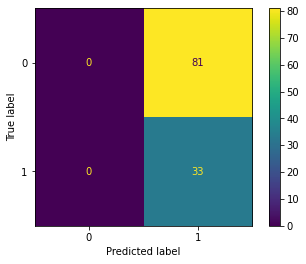

All metric scores:
 -  Accuracy :  0.2894736842105263
 -  Precision :  0.2894736842105263
 -  Recall :  1.0
 -  F1 score :  0.4489795918367347
 -  F2 score :  0.6707317073170732
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


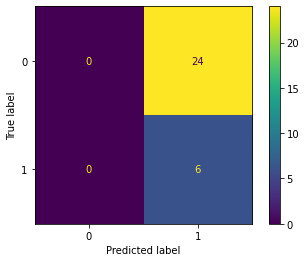

All metric scores:
 -  Accuracy :  0.2
 -  Precision :  0.2
 -  Recall :  1.0
 -  F1 score :  0.33333333333333337
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


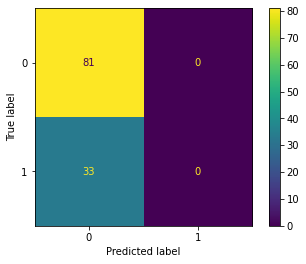

All metric scores:
 -  Accuracy :  0.7105263157894737
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


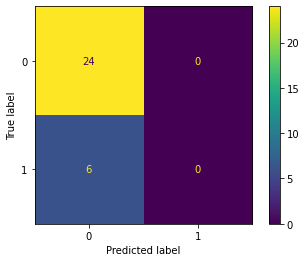

All metric scores:
 -  Accuracy :  0.8
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:22:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


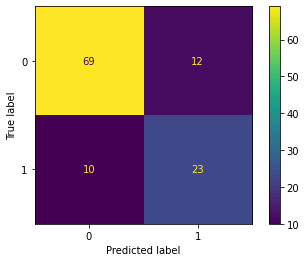

All metric scores:
 -  Accuracy :  0.8070175438596491
 -  Precision :  0.6571428571428571
 -  Recall :  0.696969696969697
 -  F1 score :  0.676470588235294
 -  F2 score :  0.6886227544910181
 -  ROC AUC :  0.7744107744107744
Validation Set: 
Confusion matrix:


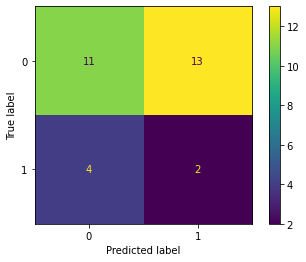

All metric scores:
 -  Accuracy :  0.43333333333333335
 -  Precision :  0.13333333333333333
 -  Recall :  0.3333333333333333
 -  F1 score :  0.19047619047619044
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.39583333333333337

---------------------------------------------------
(143, 5000)
(36, 5000)
Number ASD Development: 34
Number ASD Development: 8

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


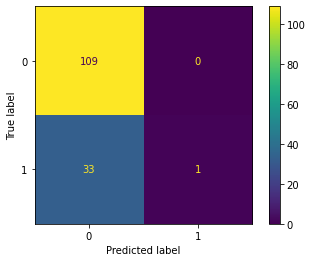

All metric scores:
 -  Accuracy :  0.7692307692307693
 -  Precision :  1.0
 -  Recall :  0.029411764705882353
 -  F1 score :  0.05714285714285715
 -  F2 score :  0.03649635036496351
 -  ROC AUC :  0.5147058823529411

- KNN Test
Confusion matrix:


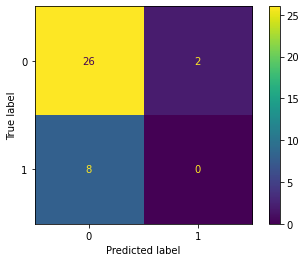

All metric scores:
 -  Accuracy :  0.7222222222222222
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4642857142857143

-------------------------
- NB Train
Confusion matrix:


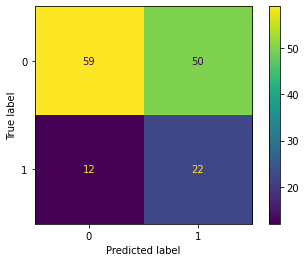

All metric scores:
 -  Accuracy :  0.5664335664335665
 -  Precision :  0.3055555555555556
 -  Recall :  0.6470588235294118
 -  F1 score :  0.41509433962264153
 -  F2 score :  0.528846153846154
 -  ROC AUC :  0.5941716135995683

- NB Test
Confusion matrix:


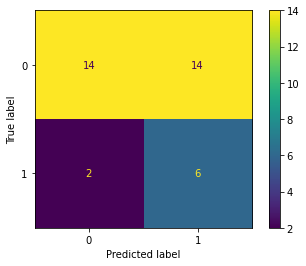

All metric scores:
 -  Accuracy :  0.5555555555555556
 -  Precision :  0.3
 -  Recall :  0.75
 -  F1 score :  0.4285714285714285
 -  F2 score :  0.576923076923077
 -  ROC AUC :  0.625

-------------------------
- LR Train
Confusion matrix:


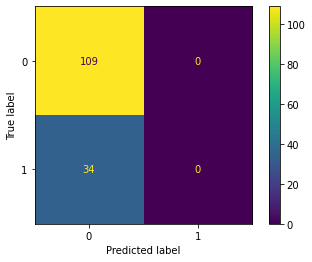

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


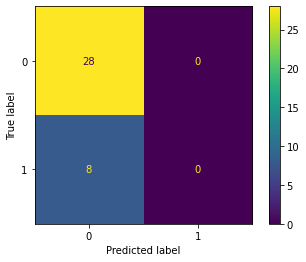

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


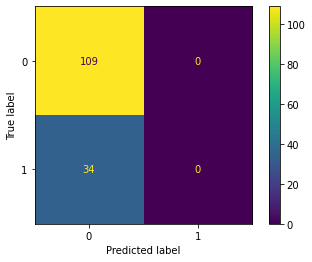

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


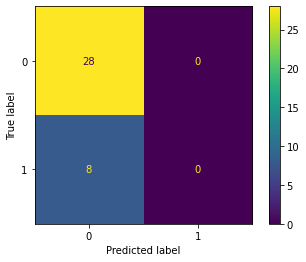

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


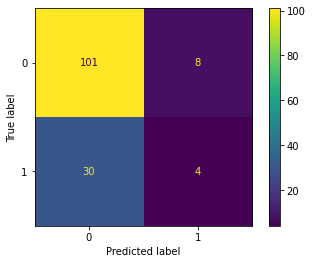

All metric scores:
 -  Accuracy :  0.7342657342657343
 -  Precision :  0.3333333333333333
 -  Recall :  0.11764705882352941
 -  F1 score :  0.1739130434782609
 -  F2 score :  0.13513513513513511
 -  ROC AUC :  0.5221262817053427

- MLP Test
Confusion matrix:


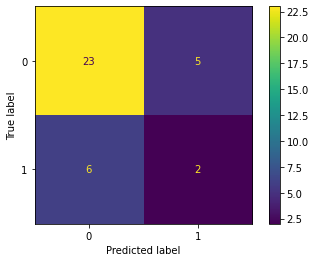

All metric scores:
 -  Accuracy :  0.6944444444444444
 -  Precision :  0.2857142857142857
 -  Recall :  0.25
 -  F1 score :  0.26666666666666666
 -  F2 score :  0.2564102564102564
 -  ROC AUC :  0.5357142857142857

-------------------------
- RF-2 Train
Confusion matrix:


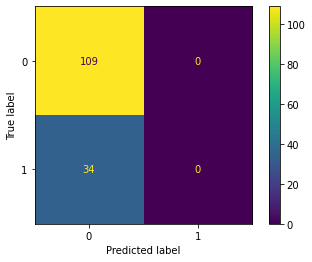

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


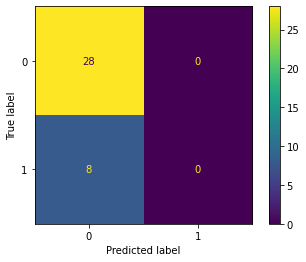

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


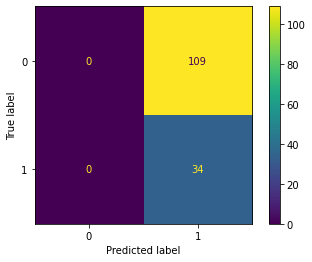

All metric scores:
 -  Accuracy :  0.23776223776223776
 -  Precision :  0.23776223776223776
 -  Recall :  1.0
 -  F1 score :  0.384180790960452
 -  F2 score :  0.6093189964157706
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


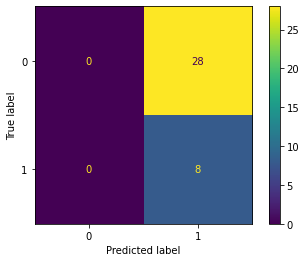

All metric scores:
 -  Accuracy :  0.2222222222222222
 -  Precision :  0.2222222222222222
 -  Recall :  1.0
 -  F1 score :  0.3636363636363636
 -  F2 score :  0.5882352941176471
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


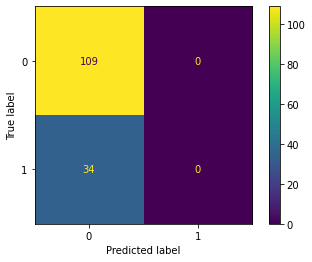

All metric scores:
 -  Accuracy :  0.7622377622377622
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


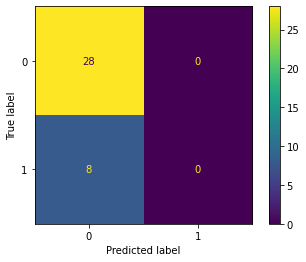

All metric scores:
 -  Accuracy :  0.7777777777777778
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:23:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


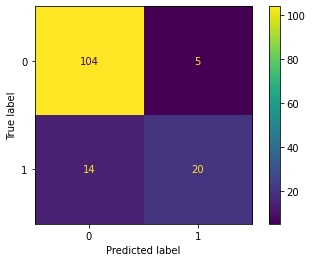

All metric scores:
 -  Accuracy :  0.8671328671328671
 -  Precision :  0.8
 -  Recall :  0.5882352941176471
 -  F1 score :  0.6779661016949153
 -  F2 score :  0.6211180124223602
 -  ROC AUC :  0.7711818672423099
Validation Set: 
Confusion matrix:


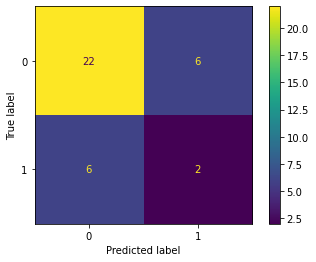

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.25
 -  Recall :  0.25
 -  F1 score :  0.25
 -  F2 score :  0.25
 -  ROC AUC :  0.5178571428571428

---------------------------------------------------
(108, 5000)
(33, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


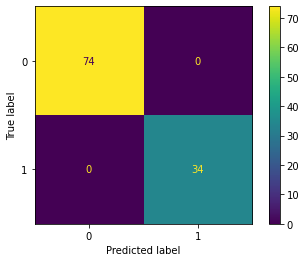

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- KNN Test
Confusion matrix:


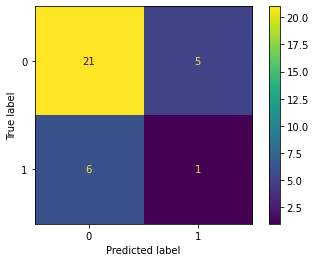

All metric scores:
 -  Accuracy :  0.6666666666666666
 -  Precision :  0.16666666666666666
 -  Recall :  0.14285714285714285
 -  F1 score :  0.15384615384615383
 -  F2 score :  0.14705882352941174
 -  ROC AUC :  0.47527472527472525

-------------------------
- NB Train
Confusion matrix:


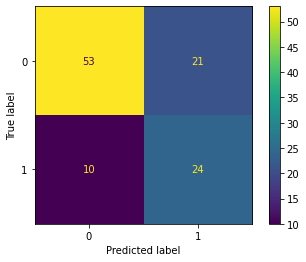

All metric scores:
 -  Accuracy :  0.7129629629629629
 -  Precision :  0.5333333333333333
 -  Recall :  0.7058823529411765
 -  F1 score :  0.6075949367088608
 -  F2 score :  0.6629834254143646
 -  ROC AUC :  0.7110492845786964

- NB Test
Confusion matrix:


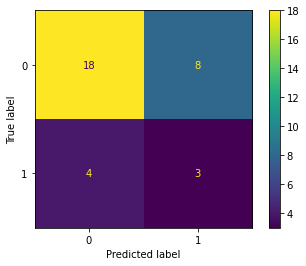

All metric scores:
 -  Accuracy :  0.6363636363636364
 -  Precision :  0.2727272727272727
 -  Recall :  0.42857142857142855
 -  F1 score :  0.33333333333333326
 -  F2 score :  0.38461538461538464
 -  ROC AUC :  0.5604395604395604

-------------------------
- LR Train
Confusion matrix:


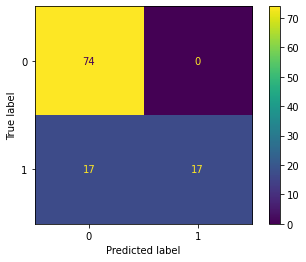

All metric scores:
 -  Accuracy :  0.8425925925925926
 -  Precision :  1.0
 -  Recall :  0.5
 -  F1 score :  0.6666666666666666
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.75

- LR Test
Confusion matrix:


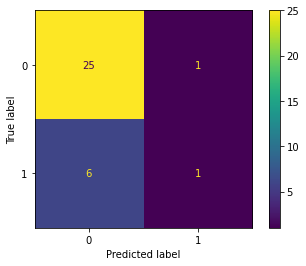

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.5
 -  Recall :  0.14285714285714285
 -  F1 score :  0.22222222222222224
 -  F2 score :  0.16666666666666666
 -  ROC AUC :  0.5521978021978021

-------------------------
- SVM Train
Confusion matrix:


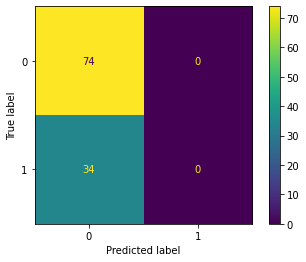

All metric scores:
 -  Accuracy :  0.6851851851851852
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


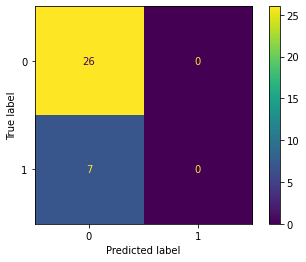

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


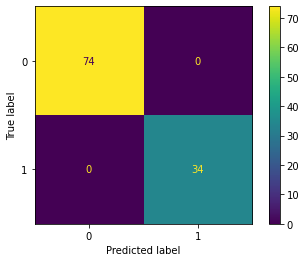

All metric scores:
 -  Accuracy :  1.0
 -  Precision :  1.0
 -  Recall :  1.0
 -  F1 score :  1.0
 -  F2 score :  1.0
 -  ROC AUC :  1.0

- MLP Test
Confusion matrix:


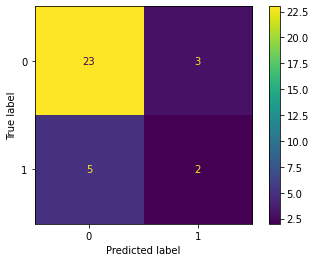

All metric scores:
 -  Accuracy :  0.7575757575757576
 -  Precision :  0.4
 -  Recall :  0.2857142857142857
 -  F1 score :  0.3333333333333333
 -  F2 score :  0.30303030303030304
 -  ROC AUC :  0.5851648351648351

-------------------------
- RF-2 Train
Confusion matrix:


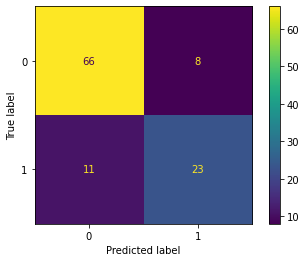

All metric scores:
 -  Accuracy :  0.8240740740740741
 -  Precision :  0.7419354838709677
 -  Recall :  0.6764705882352942
 -  F1 score :  0.7076923076923077
 -  F2 score :  0.688622754491018
 -  ROC AUC :  0.784181240063593

- RF-2 Test
Confusion matrix:


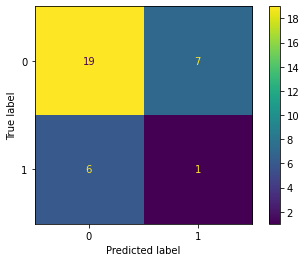

All metric scores:
 -  Accuracy :  0.6060606060606061
 -  Precision :  0.125
 -  Recall :  0.14285714285714285
 -  F1 score :  0.13333333333333333
 -  F2 score :  0.1388888888888889
 -  ROC AUC :  0.4368131868131868

-------------------------
- XGB-4 Train
Confusion matrix:


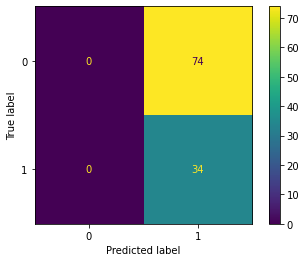

All metric scores:
 -  Accuracy :  0.3148148148148148
 -  Precision :  0.3148148148148148
 -  Recall :  1.0
 -  F1 score :  0.4788732394366197
 -  F2 score :  0.6967213114754098
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


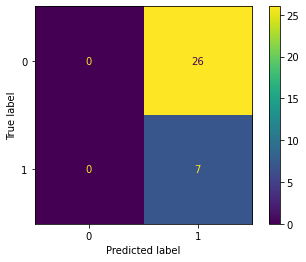

All metric scores:
 -  Accuracy :  0.21212121212121213
 -  Precision :  0.21212121212121213
 -  Recall :  1.0
 -  F1 score :  0.35
 -  F2 score :  0.5737704918032787
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


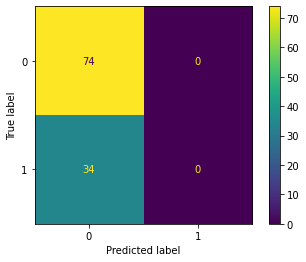

All metric scores:
 -  Accuracy :  0.6851851851851852
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


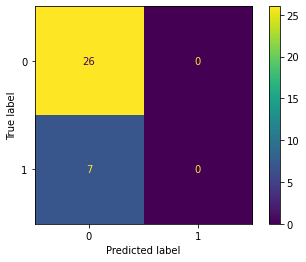

All metric scores:
 -  Accuracy :  0.7878787878787878
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:23:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


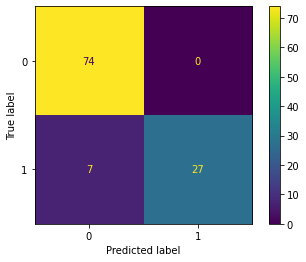

All metric scores:
 -  Accuracy :  0.9351851851851852
 -  Precision :  1.0
 -  Recall :  0.7941176470588235
 -  F1 score :  0.8852459016393442
 -  F2 score :  0.8282208588957055
 -  ROC AUC :  0.8970588235294117
Validation Set: 
Confusion matrix:


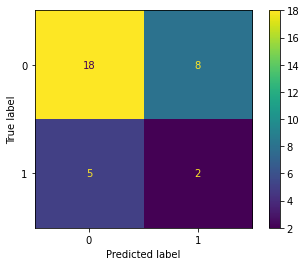

All metric scores:
 -  Accuracy :  0.6060606060606061
 -  Precision :  0.2
 -  Recall :  0.2857142857142857
 -  F1 score :  0.23529411764705882
 -  F2 score :  0.26315789473684204
 -  ROC AUC :  0.48901098901098894

---------------------------------------------------
(142, 5000)
(34, 5000)
Number ASD Development: 34
Number ASD Development: 7

---------------------------------------------------

---Fold Summary---

-------------------------
- KNN Train
Confusion matrix:


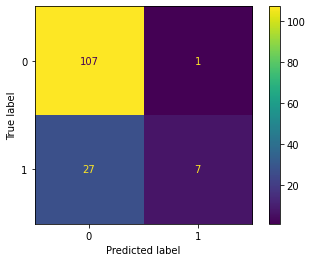

All metric scores:
 -  Accuracy :  0.8028169014084507
 -  Precision :  0.875
 -  Recall :  0.20588235294117646
 -  F1 score :  0.33333333333333337
 -  F2 score :  0.24305555555555552
 -  ROC AUC :  0.5983115468409586

- KNN Test
Confusion matrix:


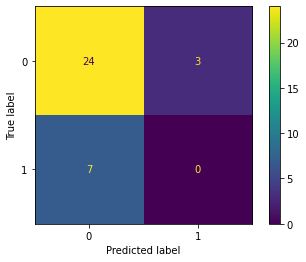

All metric scores:
 -  Accuracy :  0.7058823529411765
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4444444444444444

-------------------------
- NB Train
Confusion matrix:


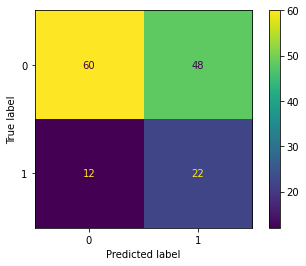

All metric scores:
 -  Accuracy :  0.5774647887323944
 -  Precision :  0.3142857142857143
 -  Recall :  0.6470588235294118
 -  F1 score :  0.4230769230769231
 -  F2 score :  0.5339805825242718
 -  ROC AUC :  0.6013071895424836

- NB Test
Confusion matrix:


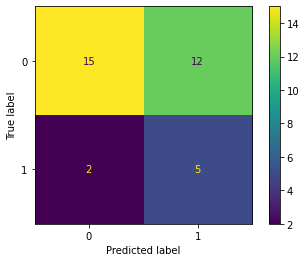

All metric scores:
 -  Accuracy :  0.5882352941176471
 -  Precision :  0.29411764705882354
 -  Recall :  0.7142857142857143
 -  F1 score :  0.4166666666666667
 -  F2 score :  0.5555555555555556
 -  ROC AUC :  0.6349206349206349

-------------------------
- LR Train
Confusion matrix:


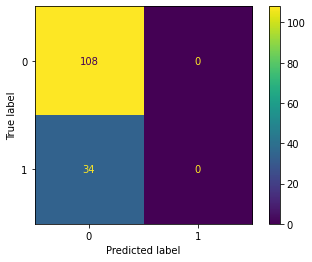

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LR Test
Confusion matrix:


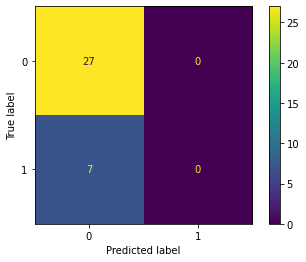

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- SVM Train
Confusion matrix:


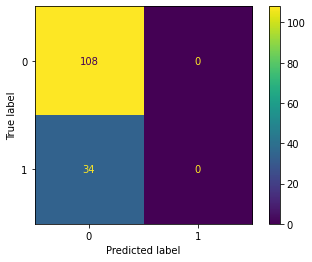

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- SVM Test
Confusion matrix:


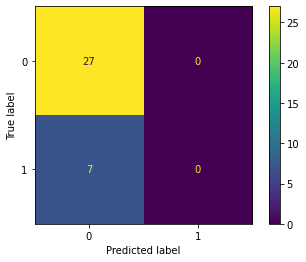

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- MLP Train
Confusion matrix:


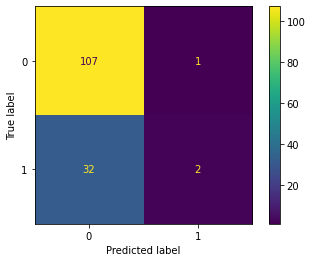

All metric scores:
 -  Accuracy :  0.7676056338028169
 -  Precision :  0.6666666666666666
 -  Recall :  0.058823529411764705
 -  F1 score :  0.10810810810810811
 -  F2 score :  0.07194244604316546
 -  ROC AUC :  0.5247821350762527

- MLP Test
Confusion matrix:


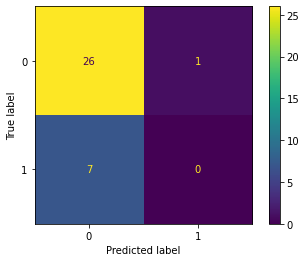

All metric scores:
 -  Accuracy :  0.7647058823529411
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.4814814814814815

-------------------------
- RF-2 Train
Confusion matrix:


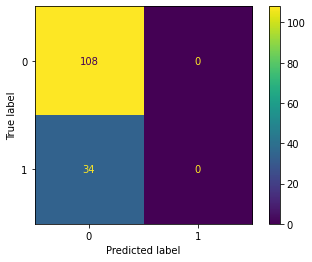

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- RF-2 Test
Confusion matrix:


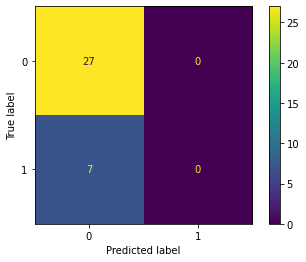

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

-------------------------
- XGB-4 Train
Confusion matrix:


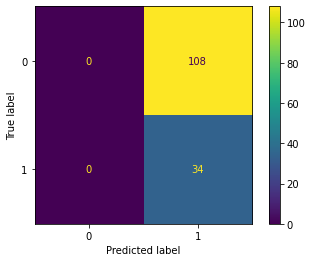

All metric scores:
 -  Accuracy :  0.23943661971830985
 -  Precision :  0.23943661971830985
 -  Recall :  1.0
 -  F1 score :  0.38636363636363635
 -  F2 score :  0.6115107913669064
 -  ROC AUC :  0.5

- XGB-4 Test
Confusion matrix:


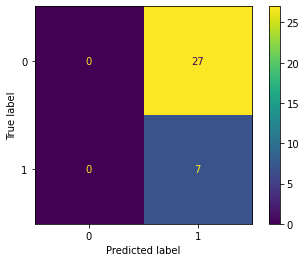

All metric scores:
 -  Accuracy :  0.20588235294117646
 -  Precision :  0.20588235294117646
 -  Recall :  1.0
 -  F1 score :  0.34146341463414637
 -  F2 score :  0.564516129032258
 -  ROC AUC :  0.5

-------------------------
- LGBM-2 Train
Confusion matrix:


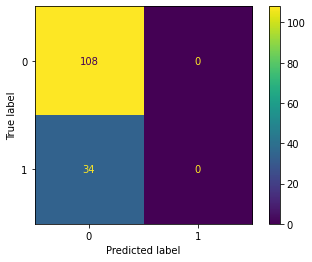

All metric scores:
 -  Accuracy :  0.7605633802816901
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

- LGBM-2 Test
Confusion matrix:


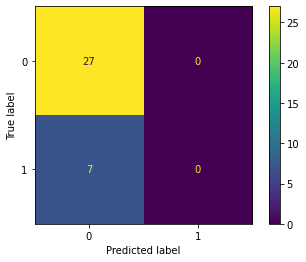

All metric scores:
 -  Accuracy :  0.7941176470588235
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.5

 -- Grid Search estimators -- 
- Soft Voting: 


/home/laura/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:24:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set: 
Confusion matrix:


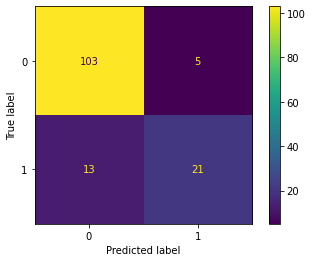

All metric scores:
 -  Accuracy :  0.8732394366197183
 -  Precision :  0.8076923076923077
 -  Recall :  0.6176470588235294
 -  F1 score :  0.7
 -  F2 score :  0.6481481481481481
 -  ROC AUC :  0.7856753812636166
Validation Set: 
Confusion matrix:


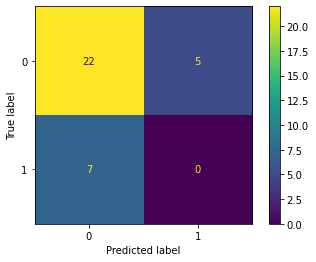

All metric scores:
 -  Accuracy :  0.6470588235294118
 -  Precision :  0.0
 -  Recall :  0.0
 -  F1 score :  0.0
 -  F2 score :  0.0
 -  ROC AUC :  0.40740740740740744

---------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239437 -> initscore=-1.155771
[LightGBM] [Info] Start training from score -1.155771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198290
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289474 -> initscore=-0.897942
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Info] Number of positive: 34, number of negative: 108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244941
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239437 -> initscore=-1.155771
[LightGBM] [Info] Start training from score -1.155771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [48]:
model_2_prediction_train = []
model_2_prediction_validation = []
view_scores = True

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    X_train_CV = X_train.iloc[train_index]    
    X_train_CV = X_train_CV.iloc[model_1_prediction_train[i] == 1]
    
    X_val_CV = X_train.iloc[test_index]
    X_val_CV = X_val_CV.iloc[model_1_prediction_validation[i] == 1]
    
    print(X_train_CV.shape)
    print(X_val_CV.shape)

    y_train_CV = is_ASD(pd.Series(y_train).iloc[train_index].iloc[model_1_prediction_train[i] == 1])
    y_val_CV = is_ASD(pd.Series(y_train).iloc[test_index].iloc[model_1_prediction_validation[i] == 1])
    
    est_gs = [(key,gs_results_list[i].best_estimator_) for key, gs_results_list in gs_results_dict_m2.items()]
    
    est_gs.pop(5)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(6)
    est_gs.pop(7)
    
    print("\n---------------------------------------------------")
    
    print("\n---Fold Summary---")
    
    for (key, estimator) in est_gs:
        estimator.fit(X_train_CV, y_train_CV)
        
        if(view_scores):
            print("-", key, "Train")

            all_scores(y_train_CV,
                       estimator.predict(X_train_CV),
                       to_print = True)

            print("\n-", key, "Test")
            all_scores(y_true = y_val_CV,
                       y_pred = estimator.predict(X_val_CV),
                       to_print = True)
        
            print("\n-------------------------")
    

    #soft voting
    
    print("\n -- Grid Search estimators -- ")
    
    print("- Soft Voting: ")

    voting = VotingClassifier(estimators=est_gs, 
                                   voting='soft', 
                                   n_jobs=-1,
                                   verbose=False)

    voting.fit(X_train_CV, y_train_CV)

    print("Training Set: ")
    all_scores(y_true = y_train_CV,
               y_pred = voting.predict(X_train_CV),
               to_print = True)
    
    print("Validation Set: ")
    all_scores(y_true = y_val_CV,
               y_pred = voting.predict(X_val_CV),
               to_print = True)
    
    print("\n---------------------------------------------------")
  
    model_2_prediction_train.append(voting.predict(X_train_CV))
    model_2_prediction_validation.append(voting.predict(X_val_CV))

In [49]:
t = [print("\nFold ", i, ": \n", pd.Series(model_2_prediction_train[i]).value_counts()) for i in range(K)]


Fold  0 : 
 0    117
1     21
Name: count, dtype: int64

Fold  1 : 
 0    79
1    35
Name: count, dtype: int64

Fold  2 : 
 0    118
1     25
Name: count, dtype: int64

Fold  3 : 
 0    81
1    27
Name: count, dtype: int64

Fold  4 : 
 0    116
1     26
Name: count, dtype: int64


In [50]:
t = [print("\nFold ", i, ": \n", pd.Series(model_2_prediction_validation[i]).value_counts()) for i in range(K)]


Fold  0 : 
 0    27
1     8
Name: count, dtype: int64

Fold  1 : 
 0    15
1    15
Name: count, dtype: int64

Fold  2 : 
 0    28
1     8
Name: count, dtype: int64

Fold  3 : 
 0    23
1    10
Name: count, dtype: int64

Fold  4 : 
 0    29
1     5
Name: count, dtype: int64


# Validation